# Setup

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({"font.size": 15, 
                            "font.family": "STIXGeneral",
                            "mathtext.fontset": "cm"})
import hparam_exploration
from importlib import reload
reload(hparam_exploration)

def smooth_series(x, N=5):
    return pd.Series(x).rolling(window=N).mean().iloc[N-1:].values

cls = ["#005096", "#FF4B4B", "#00927B", "#5A7800", "#F4AA00", "#FF2881", 
       "#00F283", "#171401", "#f3ff4d", "#81B9EF", "#B9F310", "#626262"]

def get_task_name(s):
    if "sst-2" in s: return "sst-2"
    if "sara" in s: return "sara"
    if "cola" in s: return "cola"
    return "cola"
def get_metric_name(task_name):
    if task_name == "cola": return "mcc"
    elif task_name == "sst-2": return "acc"
    elif task_name == "sara": return "f1-micro"
    else: raise ValueError(task_name)

Runtime of LSTM=300, FC=400, L=1: 6.2±0.00h
Runtime of LSTM=150, FC=200, L=1: 6.0±0.00h
Runtime of LSTM=75, FC=100, L=1: 4.2±0.00h
Runtime of LSTM=37, FC=50, L=1: 5.5±0.00h


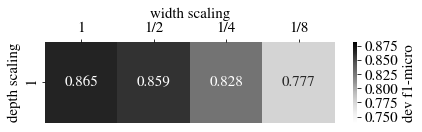

In [19]:
group = "size-sara"
task_name = get_task_name(group)
metric_name = get_metric_name(task_name)
param_name = "lr"
params_map = {"lr": 1, "n_params": 0}
param_idx = params_map[param_name]

if "cola" in group:
    if "bert" in group:
        width_factors = ["1", "2", "3", "4", "5"]
        depth_factors = ["1", "2", "3"]
    else:
        width_factors = ["1", "2", "3", "4", "5"]
        depth_factors = ["1", "2", "3", "4", "5"]
elif "sara" in group:
    if "bert" in group:
        width_factors = ["1", "1/2", "1/3"]
        depth_factors = ["1", "1/2", "1/3", "1/4"]
    else:
        width_factors = ["1", "1/2", "1/4", "1/8"]
        depth_factors = ["1"]
elif "sst-2" in group:
    if "bert" in group:
        width_factors = ["1", "1/2", "1/3", "1/4", "1/8", "1/16"]
        depth_factors = ["1", "1/2", "1/3", "1/4"]
    else:
        width_factors = ["1", "1/2", "1/4", "1/8", "1/16", "1/33", "1/60"]
        depth_factors = ["1"]
mtrx = np.zeros((len(depth_factors), len(width_factors)))
for i, (config, logs) in enumerate(log_files[group].items()):
    N = len(logs)
    if N == 0: continue
    if "bert" in group:
        width_factor, depth_factor = [param.split("=")[1] for param in config.split(", ")]
    else:
        lstm_width, _, _ = [float(param.split("=")[1]) for param in config.split(", ")]
        _, _, depth_factor = [param.split("=")[1] for param in config.split(", ")]
        if lstm_width >= 300:
            width_factor = str(int(lstm_width/300))
        else:
            width_factor = "1/{}".format(str(int(round(300/lstm_width))))
    w, d = width_factors.index(width_factor), depth_factors.index(depth_factor)
    if "params" not in group:
        log_dfs = np.array([pd.read_csv("logs/{}.csv".format(log_file), skiprows=1)[metric_name] for log_file in logs])
        maximum = log_dfs.max()
        mtrx[d, w] = maximum
    else:
        mtrx[d, w] = np.log10(logs[param_idx]) if ("params" in group and param_name == "lr") else logs[param_idx]
    
    runtimes = [float(pd.read_csv("logs/{}.csv".format(log_file), nrows=1, names=["runtime"])["runtime"][0])
                for log_file in logs]
    print("Runtime of {}: {:.1f}±{:.2f}h".format(config, np.mean(runtimes), np.std(runtimes)))
    
if "params" not in group or param_name != "lr":
    vmin, vmax = mtrx[mtrx > 0].min()*0.95, mtrx.max()*1.02
    mtrx[mtrx == 0] = None
else:
    vmin, vmax = mtrx.min()*1.1, mtrx.max()*0.9

fig = plt.figure(figsize=(1.7 + 1.2*mtrx.shape[1], 0.5 + mtrx.shape[0]))
ax = plt.gca()
sns.heatmap(mtrx, vmin=vmin, vmax=vmax, annot=True, fmt=".3f", cbar_kws={"label": "dev {}".format(metric_name)},
            cmap="Greys", ax=ax, xticklabels=width_factors, yticklabels=depth_factors)
ax.set_ylabel("depth scaling")
ax.set_xlabel("width scaling")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
plt.show()
fig.savefig("img/{}-mtrx.png".format(group + ("" if "params" not in group else "_{}".format(param_name))))

# Line plots

In [120]:
sf = 2.0
leg_kwargs = {
    "labelspacing": 0.1,
    "borderpad": 0.4, 
    "handletextpad": 0.4, 
    "borderaxespad": 0.3,
    "framealpha": 0.9,
    "columnspacing": 1.0,
    "handlelength": 1.0,
}
leg_lw = 7

In [121]:
def plot_linear(group, ax, smooth_factor=0.5, ylabel="MCC", xlabel="epoch", legcols=1, 
                title=None, shade=False, bottom=None, legtitle=None, yticks=None):    
    n_epochs = 60 if "bert" in group else 30
    task_name = get_task_name(group)
    metric_name = get_metric_name(task_name)
    for i, (config, logs) in enumerate(hparam_exploration.log_files[group].items()):
        N = len(logs)
        if N == 0: continue
        if N > 3:
            logs = logs[3:]
        runtimes = [float(pd.read_csv("logs/{}.csv".format(log_file), nrows=1, names=["runtime"])["runtime"][0])
                    for log_file in logs]

        log_dfs = np.array([pd.read_csv("logs/{}.csv".format(log_file), skiprows=1)[metric_name] 
                            for log_file in logs])
        mean, stdev = np.mean(log_dfs, axis=0), np.std(log_dfs, axis=0)
        maximum, minimum = log_dfs.max(axis=0), log_dfs.min(axis=0)

        smooth_n = int(len(log_dfs[0])/n_epochs*smooth_factor)
        mean_smooth = smooth_series(mean, N=smooth_n)
        stdev_smooth = smooth_series(stdev, N=smooth_n)
        start = n_epochs*(1 - len(mean_smooth)/len(mean))
        xs = np.linspace(start=start, stop=n_epochs, num=len(mean_smooth))
        ax.plot(xs, mean_smooth, label=config, c=cls[i], lw=2.5, zorder=1)

        if N > 1 and shade:
            lower = mean_smooth - stdev_smooth
            upper = mean_smooth + stdev_smooth
            color_transparent = [*colors.to_rgb(cls[i]), 0.35]
            ax.fill_between(xs, lower, upper, color=color_transparent, zorder=0)

        max_idx = np.argmax(maximum)
        max_val = maximum.max()
    #     print("Runtime of {}: {:.1f}±{:.2f}h, best score: {:.3f}".format(config, np.mean(runtimes), np.std(runtimes),
    #                                                                  max_val))
        ax.scatter(n_epochs/len(log_dfs[0])*max_idx, max_val, marker="x", lw=4, c=cls[i], s=70, zorder=2)
    ax.set_ylim(bottom=bottom)
    ax.set_xlim(0, n_epochs)
    ax.set_ylabel("evaluation-set " + ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    if yticks is not None:
        ax.set_yticks(yticks)
    legend = ax.legend(loc='lower right', ncol=legcols, title=legtitle, **leg_kwargs)
    for legobj in legend.legendHandles: legobj.set_linewidth(leg_lw)
    ax.set_axisbelow(True)
    ax.grid()
    return ax

## Learning rate

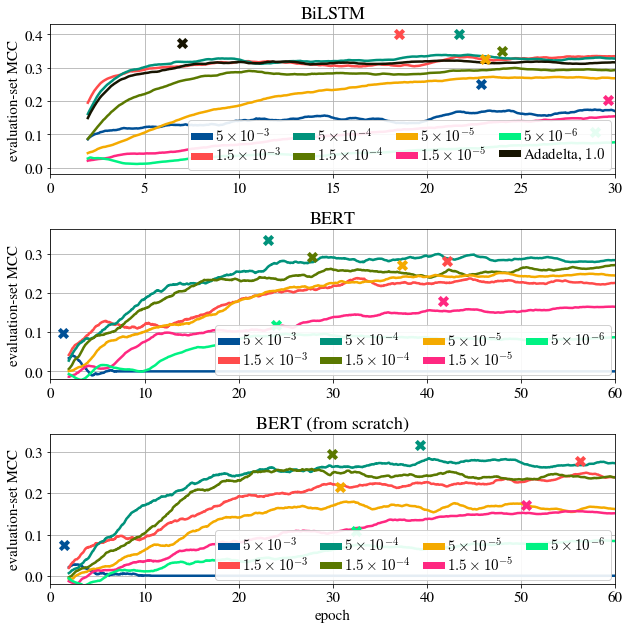

In [89]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 9))
for (model, title), ax in zip([("", "BiLSTM"), ("-bert", "BERT"), ("-bert-scratch", "BERT (from scratch)")], axs):
    plot_linear(group="lr"+model, ax=ax, smooth_factor=sf, legcols=4, xlabel=None, title=title,
               bottom=-0.02)
axs[-1].set_xlabel("epoch")
plt.tight_layout(w_pad=1.2)
plt.show()
fig.savefig("img/exploration-lr.pdf")

## Batch size

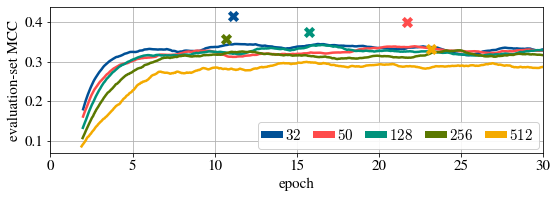

In [90]:
fig = plt.figure(figsize=(8, 3))
ax = plt.gca()
plot_linear(group="B", ax=ax, smooth_factor=sf, legcols=5, xlabel=None, title=None)
ax.set_xlabel("epoch")
plt.tight_layout(w_pad=1.2)
plt.show()
fig.savefig("img/exploration-B-lstm.pdf")

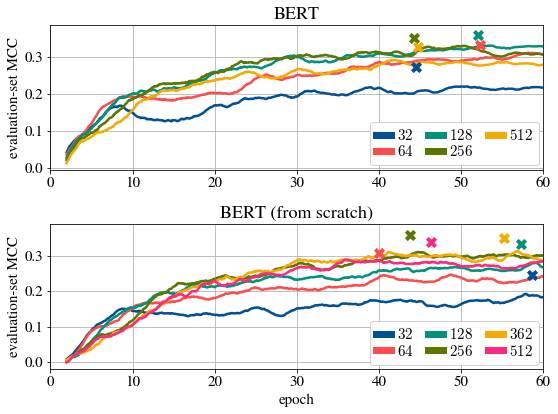

In [91]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
yticks = [0, 0.1, 0.2, 0.3]
for (model, title), ax in zip([("-bert", "BERT"), ("-bert-scratch", "BERT (from scratch)")], axs):
    plot_linear(group="B"+model, ax=ax, smooth_factor=sf, legcols=3, xlabel=None, title=title, 
                yticks=yticks)
axs[-1].set_xlabel("epoch")
plt.tight_layout(w_pad=1.2)
plt.show()
fig.savefig("img/exploration-B-bert.pdf")

## LR scheduling

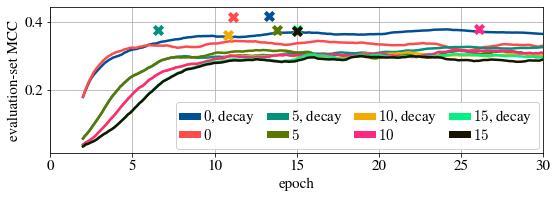

In [92]:
fig = plt.figure(figsize=(8, 3))
ax = plt.gca()
plot_linear(group="wp", ax=ax, smooth_factor=sf, legcols=4, xlabel=None, title=None)
ax.set_xlabel("epoch")
plt.tight_layout(w_pad=1.2)
plt.show()
fig.savefig("img/exploration-schedule-lstm.pdf")

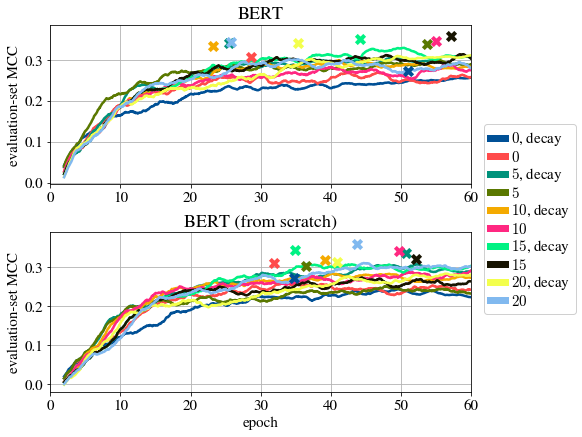

In [157]:
def unify_legend_outside(fig, axs):
    ax = fig.add_subplot(1, 1, 1)
    ax.set_axis_off()
    handles, labels = axs[-1].get_legend_handles_labels()
    legend = ax.legend(handles, labels, bbox_to_anchor=(1.0, 0.5), loc='center right', 
               bbox_transform=fig.transFigure, **leg_kwargs)
    for legobj in legend.legendHandles: legobj.set_linewidth(leg_lw)
    for a in axs:
        a.get_legend().remove()

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
yticks = [0, 0.1, 0.2, 0.3]
for (model, title), ax in zip([("-bert", "BERT"), ("-bert-scratch", "BERT (from scratch)")], axs):
    plot_linear(group="wp"+model, ax=ax, smooth_factor=sf, legcols=5, xlabel=None, title=title, 
                yticks=yticks)
axs[-1].set_xlabel("epoch")
unify_legend_outside(fig, axs)
plt.subplots_adjust(
    left  = 0.08,
    right = 0.81,
    bottom = 0.1,
    top = 0.95,
    hspace = 0.3)

plt.show()
fig.savefig("img/exploration-schedule-bert.pdf")

# ...OLD...
==================================================================================================================
# Comparing Adadelta and Adam (+ various LRs)
On CoLA, using BiLSTM (300 hidden, 400 fc units), with 800K GPT-2 augmentation, B=50, word2vec, temperature=3 and MSE loss, over 30 epochs.

In [14]:
bilstm_line_files = {
                "adadelta, B=50": "tb_Nov25_15-22-40_landonia11.inf.ed.ac.uk.csv",
                "adam (lr=5e-2), B=50": "tb_Nov26_14-38-26_landonia11.inf.ed.ac.uk.csv",
                "adam (lr=5e-3), B=50": "tb_Nov26_14-44-21_landonia11.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=50": "tb_Nov26_14-41-55_landonia11.inf.ed.ac.uk.csv",
                "adam (lr=1.5e-4), B=50": "tb_Nov27_00-42-15_landonia21.inf.ed.ac.uk.csv",
                "adam (lr=5e-5), B=50": "tb_Nov26_19-17-10_landonia11.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=128": "tb_Nov28_11-27-38_landonia11.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=50, w=0.1": "tb_Nov28_11-34-05_landonia11.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=64, w=0": "tb_Nov28_17-34-52_landonia11.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=50, w=0.333": "tb_Nov28_17-23-28_landonia11.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=50, w=0.1, wordpiece": "tb_Jan09_13-46-39_letha05.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=50, w=0.1 #1": "tb_Jan09_13-40-20_letha05.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=50, w=0": "tb_Jan10_08-18-09_damnii05.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=50, w=0, wordpiece": "tb_Jan10_08-05-21_letha06.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=50, w=0 #1": "tb_Jan12_20-44-56_letha06.inf.ed.ac.uk.csv",
                "adam (lr=5e-4), B=50, w=0, wordpiece #1": "tb_Jan12_20-45-35_letha06.inf.ed.ac.uk.csv",
             }
bilstm_line_data = {label: pd.read_csv(file)["mcc"] for label, file in bilstm_line_files.items()}

bilstm_in_progress = [
#     ("adam (lr=5e-4), B=50, w=0.33", 23.9, [0.0, 0.0, 0.0, 0.023844981660481778, 0.03299730953803639, 0.025208083291660098, 0.027408946028538616, 0.0, 0.0, 0.0, 0.015914225185656074, 0.010958999706170211, 0.009223341097056055, 0.01270272442349357, 0.017450042390633073, 0.017450042390633073, 0.022692091415238574, 0.03171027503783888, 0.03255770298659899, 0.02385387003549036, 0.024995752544662405, 0.0212999102468205, 0.025103723753819664, 0.026026506973377585, 0.030270097841277026, 0.02912203707704546, 0.03213339202722258, 0.026506716689118626, 0.04271871519438584, 0.018415809410322333, 0.021896378583677295, 0.017846176181624773, 0.014984012950160528, 0.012494182387580946, 0.010622227689607761, 0.009074515043469324, 0.0022337659315853544, 0.00707088348544633, 0.002903765990789235, 0.003052826168792764, 0.0015691600758433236, 0.012525329492156876, 0.019116052048064495, 0.009654071188680531, 0.011176923551194717, 0.018565563704550064, 0.013703931029720609, 0.0012438732397634547, 0.005906520368184415, 0.004813343932927987, 0.005930985286109681, 0.017405162582707658, 0.016013799273155094, 0.009223341097056055, 0.0027090969535673278, 0.010241095009877205, 0.013659554432812368, 0.008874995467744727, 0.018572728710520632, 0.03685588460844583, 0.0066463516455802845, 0.026026506973377585, 0.05382875525211206, 0.01154161672795584, 0.010742716736163237, 0.020034272469381557, 0.03192168701513281, 0.037467036153535895, 0.021341795859629396, 0.04346983344655927, 0.02030622677013148, 0.01797134156495028, 0.021463798483518905, 0.01953930152590578, 0.020212309320580456, 0.03816720998508198, 0.030460062984750465, 0.049708328073961375, 0.01609959999167811, 0.013659554432812368, 0.015282633630460726, 0.025059700081726127, 0.008947653867537366, 0.04737103823716464, 0.024472665859396434, 0.034859815223893025, 0.037576752663995946, 0.02385387003549036, 0.012488793085636095, 0.008430658741443782, 0.025983054387486677, 0.018415809410322333, 0.04366028751366058, 0.046198326521507356, 0.0300988858964781, 0.030029047278568748, 0.03049092395800874, 0.025915904453144473, 0.030804420088859908, 0.03619067517120768, 0.05586734795740187, 0.01917274661600919, 0.06342593836004289, 0.025735751198747926, 0.008088490609899983, 0.01561106341173342, 0.02674613601920812, 0.023723966131724544, 0.039023384705576716, 0.02908405390969934, 0.06819070418356517, 0.04943294928231988, 0.033596379355969756, 0.028844308520708854, 0.033781882506880606, 0.010673031799562986, 0.033728628304868204, 0.01646098085529892, 0.03366099622167745, 0.036019997092120386, 0.04737103823716464, 0.048893532356648096, 0.03740210252458401, 0.028062999557356298, 0.0078057794754490045, 0.028779589007371875, 0.04271871519438584, 0.05753823514292109, 0.03290005851024002, 0.023723941144438723, 0.04181191893687797, 0.02872527687891651, 0.03995108940301536, 0.037900821633292246, 0.04647548014605478, 0.047932464973473636, 0.07160538250772189, 0.027802949952054144, 0.03263093010696473, 0.03777168010741171, 0.06649950842111448, 0.05602004370974726, 0.051410165460067235, 0.059786071231032765, 0.048399353609068795, 0.045340552770743316, 0.044856179849865854, 0.03866412211248799, 0.03178213690578877, 0.033890699626879496, 0.0302544455634105, 0.029358377166242917, 0.022067101449159066, 0.013825904947404447, 0.03128831096121105, 0.025544257401197916, 0.045232999182118545, 0.06535581322151869, 0.05885292991536946, 0.0719158420648774, 0.06692046409660439, 0.0008683810395846793, 0.015936165417096203, 0.02908405390969934, 0.028906539729059093, 0.06593610795950694, 0.05753823514292109, 0.055365159770778424, 0.04084741062251689, 0.04592471018065786, 0.05849980037922285, 0.03398483972715838, 0.05911730043906231, 0.025511258654130203, 0.05006307776562236, 0.06476145037177082, 0.05950348658831357, 0.050586982903098154, 0.04965079680219604, 0.06687920524842031, 0.049016722398077604, 0.014996636135616644, 0.05723454998326968, 0.07546469224044726, 0.05355488378935774, 0.07213843124610197, 0.03649796867953749, 0.04944176992936813, 0.054410982890180655, 0.050025101530917104, 0.048125887255212316, 0.059276558096691905, 0.04307317852735145, 0.07674883670312843, 0.06472553308183067, 0.05041759675662686, 0.04151689700276776, 0.06099737459901692, 0.06280376398791969, 0.06277337359960121, 0.06787939379502084, 0.05909037138493013, 0.047196052591121224, 0.04765077978808297, 0.08437193152578576, 0.03248225142941315, 0.040804535863040836, 0.05763614284446515, 0.06987053263668808, 0.05307976850687949, 0.027400092626903412, 0.05140223965425994, 0.055313685224611275, 0.02473606184608316, 0.053474547726482274, 0.04180368478208929, 0.021907821001993105, 0.04629674529718093, 0.05972357882323046, 0.07834075453269701, 0.06457903110011716, 0.05140446946588715, 0.07051986065319861, 0.05262389099883156, 0.06123812496455764, 0.04307317852735145, 0.036081175524456124, 0.04937615012030914, 0.03695721409682404, 0.07671348626989796, 0.07021506981631827, 0.06342593836004289, 0.06397279928968853, 0.06278848183967892, 0.06286228893540544, 0.02538357867101951, 0.04959819347810151, 0.06307407488404682, 0.05725485682972918, 0.05417227485149244, 0.07164254807763447, 0.07854230017632119, 0.041278070839342915, 0.0353125990458036, 0.09360605095101081, 0.06682779350124014, 0.10349897776251187, 0.08358395003502136, 0.08278282756852208, 0.04647548014605478, 0.03717218958814298, 0.07749142464202105, 0.07287342856481928, 0.02080123669607089, 0.019745789684722202, 0.026926502047285437, 0.04527072126948271, 0.026799617768355065, 0.06845010889121395, 0.04090658354854943, 0.011689481735491312, 0.04530229810092909, 0.03878219083725949, 0.06535581322151869, 0.05365794227153013, 0.07101874429936635, 0.09454691083767781, 0.05763614284446515, 0.05332651849551546, 0.08525229511786316, 0.06295144301430694, 0.0915684223547905, 0.07151611228771693, 0.08010106464819099, 0.11594367242723415, 0.06644731312992483, 0.06278848183967892, 0.08509705808006848, 0.07552845006017701, 0.09676842158844572, 0.08636939320170842, 0.04765118573947667, 0.06562058832421862, 0.09402829896622907, 0.07516787112764689, 0.10100998770277704, 0.06562058832421862, 0.04593521500171843, 0.05316602771375881, 0.046272392555511035, 0.07683234381179825, 0.10766869297609662, 0.09318236882843431, 0.10636033982166733, 0.07320814925710716, 0.08987782248314084, 0.06282936136223807, 0.060955822501494714, 0.05783663714067065, 0.08148216162413352, 0.0808417344884979, 0.06814365287237048, 0.09165108277504685, 0.07021506981631827, 0.06770502447586792, 0.07385318167867208, 0.08020606006614589, 0.06457903110011716, 0.08680354080858402, 0.08342146557730178, 0.09165108277504685, 0.07042095541892264, 0.03234728389432891, 0.0718733793721173, 0.07698132347776336, 0.05382875525211206, 0.098720398117113, 0.08010353557927898, 0.07592440042634159, 0.07213843124610197, 0.08286492529845838, 0.06457230365019842, 0.0643406632993554, 0.08849986305713059, 0.06578783318978124, 0.10878095835272167, 0.08294222652033967, 0.10581095489519525, 0.07404272693058336, 0.09034840020879953, 0.07562004435105749, 0.07197483492789723, 0.08377869819273433, 0.05763614284446515, 0.06849185347307034, 0.09676842158844572, 0.07197483492789723, 0.08961786890867358, 0.08861030298138443, 0.11059096292676392, 0.10005091028656733, 0.0991789643841323, 0.0822929309939614, 0.079393914078019, 0.0495086786186171, 0.08535463346513071, 0.07731897804953623, 0.07332323025553386, 0.08155359081459872, 0.06692046409660439, 0.07355184699311824, 0.059627469968929314, 0.0849010209487621, 0.09788642648165943, 0.0754658870542644, 0.08913478144365089, 0.08569951407246647, 0.10271336076768928, 0.08834511787256859, 0.13195756346988302, 0.0834401861698737, 0.1049917489606169, 0.10852058234949144, 0.053378867574987124, 0.07568945120824479, 0.09990234865271709, 0.11957545052162556, 0.11102272574395852, 0.10509476725389434, 0.09360605095101081, 0.07001227538804344, 0.11757980904334828, 0.10178831079319654, 0.08032987279303862, 0.08432787964009426, 0.1007213816329287, 0.06925819357864041, 0.0942162388060591, 0.12126625542722314, 0.08610370349548085, 0.11510140889517931, 0.09788642648165943, 0.09176090034150314, 0.13166508543139832, 0.07690078593394421, 0.09247935026538981, 0.09415297522248196, 0.10271336076768928, 0.07738473272434816, 0.07779676224739243, 0.07572065513550859, 0.10451124263480288, 0.09034840020879953, 0.11320847253358887, 0.09595893364226347, 0.12183138161681191, 0.11574608074311962, 0.12106933044866976, 0.10825134293917836, 0.10569679566761644, 0.10995605912172093, 0.10638368578630042, 0.12237836244272593, 0.11891147397938004, 0.10168570665597802, 0.12416376577280364, 0.11658348355677788, 0.1197750004046856, 0.13389711693006517, 0.09085802855676943, 0.12289126926078815, 0.12234371203667882, 0.09148841849492134, 0.10685895273482728, 0.0996916869431609, 0.0889647792916452, 0.09034840020879953, 0.10878095835272167, 0.10938806518761544, 0.09305897560752993, 0.0910511387434359, 0.09253272633727094, 0.11856379152345058, 0.11538689540953473, 0.0858708443805421, 0.10124530770557133, 0.10314175077095872, 0.10826916930722472, 0.112327763443674, 0.07843883805171416, 0.1007213816329287, 0.07893986331660625, 0.08157344878043489, 0.08254689584504264, 0.11198048157834023, 0.08894188139620744, 0.07117182343331617, 0.09474597290626137, 0.11347822969145376, 0.08237903942226402, 0.08698993447920254, 0.08811408651094657, 0.12090225670740633, 0.1240676644990556, 0.10252536758772093, 0.11861970572219362, 0.11451075499127257, 0.0995577834985163, 0.11648596626456433, 0.09702614755535717, 0.10678073898460734, 0.10071039688788999, 0.12815195996316056, 0.10548048715926805, 0.09133893434302506, 0.09717849682767489, 0.11268444493004938, 0.1367129852888476, 0.11429164698211637, 0.1155546942522672, 0.11834975008997632, 0.12247466060491209, 0.12284688780758954, 0.13628369409157895, 0.121202265288346, 0.11688203895914688, 0.0792500019020215, 0.10300144446877145, 0.08332630908455557, 0.08801919690309869, 0.11187651150735063, 0.09005052104634213, 0.13486840575852976, 0.12514552480826815, 0.10708516813630359, 0.10638368578630042, 0.10148788998901415, 0.14208465951920585, 0.11451075499127257, 0.07965962331190174, 0.09620445703087042, 0.09717849682767489, 0.13641266158052265, 0.132140208204227, 0.13925069231659018, 0.1258213821505869, 0.1352112068431589, 0.11718605887952105, 0.13863244404031252, 0.14909670185279636, 0.11375354440328246, 0.1251591159068797, 0.11540087560863899, 0.10840057398002138, 0.14130962950692585, 0.1099530154818208, 0.12183138161681191, 0.11335189203790383, 0.07863994341226557, 0.1164638713613227, 0.11415043333891922, 0.1197750004046856, 0.13337945354014985, 0.11980110428765138, 0.09757318129656664, 0.10196510278640546, 0.14412496021603272, 0.09426976277858662, 0.14750388305466128, 0.16722744396677502, 0.15589658910760806, 0.16156800088255333, 0.1630058431167719, 0.1357038960680196, 0.1250816049417772, 0.11268021696428915, 0.15635842598374397, 0.152795979990646, 0.14951460328009086, 0.12893787975317236, 0.1282178349773743, 0.13110405634743488, 0.12611807765809996, 0.10263677230474762, 0.1255260512509306, 0.13609896592036314, 0.1312625867300468, 0.13667652633742342, 0.15700623621046172, 0.15040124525819165, 0.10962781931858787, 0.1310560130179328, 0.16015423707043774, 0.128246004353107, 0.11677094224694864, 0.1504377688337382, 0.1602402703538782, 0.1865199413173589, 0.15247704491527725, 0.19430846146733508, 0.14042341917676304, 0.16715675992190288, 0.14571954076301957, 0.11497285700769203, 0.16049993832304957, 0.13893522193801636, 0.14821106646634613, 0.16704271425966785, 0.17593921069334956, 0.20694517638203058, 0.18142534021863846, 0.16098499004461977, 0.18725459421801624, 0.17459410618133459, 0.1560303904795034, 0.18676999539433584, 0.13806817981746097, 0.13817391149738298, 0.1676228897001714, 0.1426548528713053, 0.1687606174284995, 0.1396965788394421, 0.15124849710977026, 0.16721563377103382, 0.15124849710977026, 0.17735448289037614, 0.1466702905961095, 0.1600539307931092, 0.14817560886707942, 0.16721563377103382, 0.11655756029622782, 0.14369050121150678, 0.14367047924596674, 0.1712045161065497, 0.14073426760849095, 0.15383429960714817, 0.14502149131354858, 0.13791443269328946, 0.16039452795747666, 0.16091837323651975, 0.13713480218962398, 0.1229288843319562, 0.12690597402782433, 0.19427998209244765, 0.19024337211076706, 0.1774682630662371, 0.17068957443884722, 0.13543270693362658, 0.1394079945890785, 0.17991731506633946, 0.16575686006800203, 0.15247704491527725, 0.13966430567756255, 0.16647242410801416, 0.16422741507958707, 0.16039452795747666, 0.16131046191325002, 0.1803327393364879, 0.18737377765581165, 0.1664414876598719, 0.17725639805834, 0.15239553298952815, 0.1927422341664739, 0.17446315256722567, 0.19955176173637962, 0.1475501827091433, 0.15137987674105044, 0.20737809972235108, 0.20217562003031586, 0.17590163953317436, 0.17469818746270194, 0.1567229872202615, 0.15579463780856576, 0.2058111938795722, 0.20077136364562512, 0.186036028332034, 0.17840087706256427, 0.15552849242936764, 0.15930352913904275, 0.18399349870832948, 0.148274632152742, 0.17136644342821492, 0.15579463780856576, 0.21156498071994503, 0.19121121131464267, 0.17795434984072278, 0.1648908450011503, 0.1547236806397544, 0.18754063831605286, 0.18850013538163093, 0.16054112787889724, 0.16798768818302992, 0.1362584635393116, 0.18587359866855782, 0.17567822996520532, 0.19628266305197425, 0.1810080690297251, 0.16647242410801416, 0.1547236806397544, 0.16283341065704757, 0.21160282069831832, 0.1880215589526709, 0.15461611119786836, 0.1820081432026257, 0.15031249915725298, 0.16376508994759698, 0.17662629568144358, 0.20518689293356138, 0.21536460552609665, 0.19071853921694057, 0.17774255474203954, 0.16336848932033965, 0.1757794806337226, 0.1631996211106378, 0.1631996211106378, 0.18105450364782608, 0.19246877678066251, 0.172806594200955, 0.21664790532564207, 0.20653335949136387, 0.17362003866441414, 0.21221698887663182, 0.18372979704922268, 0.19917446639499126, 0.21786929926509574, 0.19333980863862107, 0.21228422615985293, 0.21672446142022367, 0.18918528736867418, 0.20167336388742935, 0.19753931888472284, 0.19949326819345128, 0.20772423516658342, 0.21756808664486996, 0.20286423875683054, 0.2297420218339181, 0.21840579693676135, 0.2153216199980261, 0.19482194962546984, 0.22976528537442897, 0.22573819311612775, 0.20279438538683178, 0.20121015060635897, 0.19314060306309833, 0.16647242410801416, 0.1917292390957614, 0.1616230121252686, 0.23985667152646728, 0.1583546690158471, 0.2235131095078494, 0.20400877855830188, 0.19956791718515104, 0.20518689293356138, 0.21770473657108047, 0.19208820610985453, 0.16140071467144057, 0.20772423516658342, 0.21786929926509574, 0.19836291897338604, 0.20858966172976115, 0.2110931909022847, 0.23908230161096033, 0.1957913784516469, 0.15786530893114534, 0.19736696389598857, 0.15818516361076118, 0.21417617485609874, 0.22424193394048839, 0.1820081432026257, 0.19242064877594958, 0.19996741209690314, 0.17662629568144358, 0.1726560570995838, 0.20775442805908936, 0.20251793939932783, 0.22544483431155077, 0.18129424059436985, 0.2271320033748531, 0.19810129061698262, 0.20400877855830188, 0.20518123758237117, 0.1951787419998599, 0.22896296148887765, 0.22000053228059496, 0.24537804125365995, 0.18832996568833038, 0.18393415053505277, 0.20076044272736998, 0.1706296949230754, 0.18912365474121887, 0.20737809972235108, 0.20100910423052637, 0.20163803646984613, 0.2037351935559132, 0.19432520872256864, 0.17970618963824728, 0.22201293282295845, 0.21383481724304787, 0.21789250337255767, 0.20967889104919693, 0.22688533709443207, 0.20965463814321775, 0.1718926967776894, 0.1896785513172281, 0.20912923576493098, 0.2098628816456837, 0.1951787419998599, 0.18261346715072632, 0.17533901190131632, 0.18062364017960464, 0.18054976357926977, 0.20292007709196375, 0.1836019811506833, 0.1836019811506833, 0.18361105636195904, 0.23303186605794415, 0.20342770054560735, 0.20416506678926993, 0.21425411211342046, 0.23217743403041677, 0.2007882419023762, 0.21322857645056367, 0.20286423875683054, 0.2121877435292352, 0.22555289334143488, 0.19652610059869435, 0.2198619682090848, 0.20769102959717195, 0.19567970922722008, 0.20492784255971525, 0.18707119980355433, 0.2260121804049405, 0.20676738952334175, 0.21786929926509574, 0.19858270449557083, 0.21407145191241214, 0.21355012764725054, 0.22552275265291963, 0.2186757266420954, 0.21190858159771814, 0.1905170901085668, 0.23920231163583514, 0.2186788425154879, 0.20297269733489484, 0.2173670091821626, 0.23491561124405602, 0.2638979838270277, 0.2496817428764705, 0.23956771164798327, 0.1951787419998599, 0.22306616606673543, 0.2522840784502164, 0.1849462370750438, 0.19220271945322823, 0.22756698369445286, 0.2385760513496379, 0.22000053228059496, 0.23957712438913295, 0.24346333467165276, 0.26065476917241576, 0.23339883669757286, 0.21213756412974807, 0.22366058640932485, 0.23791661651885057, 0.21873291773454392, 0.2398080289138087, 0.22776701101446373, 0.2038900908330898, 0.21477688175782397, 0.20694517638203058, 0.20624907655056632, 0.24304544654485274, 0.18954364972242177, 0.20863125889432763, 0.21262089304852563, 0.19561981206233847, 0.21709032142453535, 0.2199819302827297, 0.19056373283634923, 0.19183352844256124, 0.21062146241001228, 0.20769102959717195, 0.21756808664486996, 0.19747622243334254, 0.19289163440612536, 0.21438954707710337, 0.22104757466884675, 0.21840579693676135, 0.22896296148887765, 0.22104757466884675, 0.20325589485182494, 0.23502315253799716, 0.23305004784427488, 0.2371583518910576, 0.2233378124843827, 0.22756698369445286, 0.20653806057727706, 0.23410883524483442, 0.22000053228059496, 0.2402481538264528, 0.22859262486027096, 0.22104757466884675, 0.2371583518910576, 0.23524228402920183, 0.24607647129467225, 0.23721102430784513, 0.2180884417877342, 0.25008140718708816, 0.24376144713768347, 0.22857519391530792, 0.24300916285043445, 0.23622330175897896, 0.2434698345678934, 0.25125577104871455, 0.2113681789602433, 0.23660709796833249, 0.24253187944228916, 0.2624109207554264, 0.22766279592720273, 0.2559819918220285, 0.2444116923458399, 0.25648807152198616, 0.2728855367382852, 0.264254032847127, 0.2187531434369704, 0.25247294540379317, 0.27378019116435004, 0.26848105059243127, 0.22445442354403852, 0.24493514255898144, 0.24221283140723873, 0.21770396781193882, 0.250331824855595, 0.27658235273861353, 0.23557589395964054, 0.2225790113772402, 0.2221431154499795, 0.22803242636043547, 0.22100646381239317, 0.22815052890294182, 0.25865652980192283, 0.24411927784804502, 0.23249392936641397, 0.23788393606779704, 0.24020610683347723, 0.2435297956527129, 0.24493514255898144, 0.24295421433913034, 0.23119604155133006, 0.23491561124405602, 0.24034147305189313, 0.23011563653426548, 0.23764017400129975, 0.2319194590428974, 0.2557422457873449, 0.24997980552758983, 0.24917934861225993, 0.24254261934815094, 0.23737595665814953, 0.2597654483414127, 0.26003944383054384, 0.2855236858154425, 0.25629866769803317, 0.2565261421807296, 0.2220438201787924, 0.24701697196693306, 0.23788393606779704, 0.2913597994529053, 0.27199939066640827, 0.25795298930485244, 0.27759533635508193, 0.2802458060175705, 0.27203836793757347, 0.26425145230152075, 0.24684059492240898, 0.2640097847675175, 0.2781722504654837, 0.27020692631724524, 0.23968325937560422, 0.2653118537861736, 0.22648089699966292, 0.2659060643459623, 0.2637376463665616, 0.25865652980192283, 0.2554748368866417, 0.2505809042883241, 0.26441965889727126, 0.26281922791737194, 0.25247294540379317, 0.22648089699966292, 0.27421832802953416, 0.25171427288253206, 0.26919147281820544, 0.25038743653153106, 0.24718576234275103, 0.25334582177435566, 0.22317225695623735, 0.2635098894314153, 0.2814761662567701, 0.23920231163583514, 0.25350827667067966, 0.24493514255898144, 0.26527750281270746, 0.24917934861225993, 0.26735658039153454, 0.26854789956063607, 0.29508796635528606, 0.24912551078491946, 0.24196394023163992, 0.26802701811767227, 0.2761738120106561, 0.28102793758016653, 0.2619273305091235, 0.24634183134400275, 0.2906992368113672, 0.2696711544143285, 0.289546048589382, 0.24524075500453182, 0.24596836934473465, 0.22864054610053589, 0.24411927784804502, 0.2501870257423586, 0.2783911920924365, 0.30229530917129227, 0.27741727341507266, 0.2554748368866417, 0.25586712591525285, 0.22573988997298566, 0.24176047047454946, 0.2501870257423586, 0.2689846776195044, 0.254022295493983, 0.28763498253742686, 0.2561029304493678, 0.2782173990810887, 0.2844772546819903, 0.26493511382264406, 0.28470418356231675, 0.2822772820078471, 0.3026188331537463, 0.2547689272999074, 0.2557422457873449, 0.29230910937537136, 0.29532386002959804, 0.2968029123939562, 0.28728961154323857, 0.2769953231473414, 0.2832509988197733, 0.29164563729813114, 0.2513413354546134, 0.2852679092106396, 0.24504541353343146, 0.22917949300884982, 0.24168765058017067, 0.2559819918220285, 0.2423326650297505, 0.2629274105257189, 0.2461565287284972, 0.29361519230959404, 0.27545334517549547, 0.25962462163046973, 0.25021946798388356, 0.25354343142717417, 0.2883297471740628, 0.26598512266278473, 0.24918095081522423, 0.2675204346386867, 0.2894277945266684, 0.21835821132977204, 0.2575458824380498, 0.21625956498974205, 0.2470622994215344, 0.23432709352021644, 0.22276061386583426, 0.23555886962889966, 0.22619395751403965, 0.24321177040819328, 0.22145265792608676, 0.23481097845044813, 0.28000471804552507, 0.25125577104871455, 0.23636368380458236, 0.26115266671909476, 0.2751765230586013, 0.26145028096632705, 0.25334224849788056, 0.2545936220289859, 0.2816983248426219, 0.27423353371981735, 0.23166467931220255, 0.26707419141575683, 0.2576975871954666, 0.22037445237760042, 0.28729540414952465, 0.2585842975224861, 0.2710739590789707, 0.27921308990518034, 0.28478501314230686, 0.27208056235907824, 0.281605244064602, 0.28020484941709195, 0.24650757572414878, 0.24911967633884038, 0.27135653879569793, 0.25499375075452474, 0.2832509988197733, 0.23985260898664917, 0.287471579219673, 0.29082256094738845, 0.25546328403280993, 0.267456279131036, 0.28785692050866546, 0.28881730435127095, 0.286819724414106, 0.26371128024409524, 0.2585842975224861, 0.2520743578979739, 0.2743104445963026, 0.25354343142717417, 0.2557422457873449, 0.2565261421807296, 0.2906992368113672, 0.27511766499365503, 0.2638263465470916, 0.2468068651932591, 0.26463576516286386, 0.25543890892573584, 0.2655545335790408, 0.2638263465470916, 0.25920194711915806, 0.25858826874125307, 0.2617913001253491, 0.2724314333870315, 0.2859384332416509, 0.24820330504878688, 0.2527785086940359, 0.2515212877815903, 0.25440198512136486, 0.3353596799742206, 0.29214400190986406, 0.2792495423268956, 0.279531844467591, 0.30140571370330893, 0.29618307719420406, 0.29220209120937635, 0.30229530917129227, 0.29031360228665876, 0.28563205054053603, 0.2743104445963026, 0.25568022782833466, 0.2555746390165751, 0.2496817428764705, 0.2617109489068458, 0.28435062091861607, 0.28929834748075606, 0.27138196212530014, 0.2761738120106561, 0.28456230043725383, 0.3093610363623291, 0.310226746170175, 0.2993134853251883, 0.2908169934949995, 0.2805392662725715, 0.24504541353343146, 0.297091750822572, 0.2589425983962536, 0.2663661507087368, 0.26794086863927735, 0.2956371164107212, 0.2997283049764168, 0.29061352428167453, 0.2812190355850046, 0.2563853745348146, 0.25962462163046973, 0.26337476887974637, 0.25414711537189905, 0.24917934861225993, 0.27355290121417347, 0.26069079210911306, 0.2825334577873775, 0.20508319858966723, 0.27413395358243453, 0.19885639835274488, 0.2460234705754429, 0.23363727832276643, 0.256620445981431, 0.26275202370418477, 0.28034813481951787, 0.2783911920924365, 0.25302940997968987, 0.2617913001253491, 0.2771508666002082, 0.23833210539224078, 0.28125077323107056, 0.2765807254221808, 0.25191262632014555, 0.2719735085825945, 0.2968029123939562, 0.2661620675620489, 0.28000471804552507, 0.2735080628226337, 0.26824015586994615, 0.26482148183174375, 0.24395671210315503, 0.25785725704832546, 0.29375517630160247, 0.26378573164384417, 0.2720551756915914, 0.2883130817517677, 0.27248770819981843, 0.2826495738883443, 0.29027797762462887, 0.28929834748075606, 0.28125077323107056, 0.27919603798989306, 0.29462987684037784, 0.29259559721243, 0.289546048589382, 0.2733005537292625, 0.2374695309664015, 0.26628498108195825, 0.2983092770236731, 0.31765323876865625, 0.29030685179896215, 0.29082256094738845, 0.25414711537189905, 0.25025972568408966, 0.3150914299447438, 0.2765234089619828, 0.26919147281820544, 0.2704118661114224, 0.2785930983893837, 0.25568022782833466, 0.29431995206773565, 0.2873568961550182, 0.2733005537292625, 0.2563853745348146, 0.267965079833602, 0.2782560540392304, 0.3088110762547024, 0.28563205054053603, 0.2902533099778686, 0.2987646685790714, 0.2757350749964273, 0.2660795870457473, 0.28435062091861607, 0.29170470165144197, 0.26824015586994615, 0.28291893924176187, 0.26527750281270746, 0.25806700779996966, 0.2658047747759422, 0.25774901127968214, 0.28632770305658134, 0.2814761662567701, 0.2898720294015409, 0.28125077323107056, 0.27613190086358996, 0.2710739590789707, 0.2782560540392304, 0.26248713901731147, 0.2659060643459623, 0.279193214798645, 0.27101653691483113, 0.3022859435165595, 0.25139498644785346, 0.28479454264551357, 0.29170470165144197, 0.2883885526086265, 0.257590557689401, 0.29469430172062516, 0.2903562313160724, 0.28245017581131066, 0.2822357565113682, 0.30490211832855096, 0.3131528264872866, 0.2729084509621747, 0.30229530917129227, 0.3075050316707203, 0.29656598879025137, 0.31116462894368313, 0.25017246180708885, 0.24586561188062908, 0.2802458060175705, 0.2751153692198536, 0.32475479765701964, 0.32218122589365616, 0.30229530917129227, 0.29841600727810763, 0.2905066796130043, 0.27511766499365503, 0.28529203384052887, 0.3212893003993058, 0.2834224281266878, 0.26940239940260746, 0.31424706395063334, 0.33241875118214503, 0.3062258897991413, 0.329919794913804, 0.2621324183151987, 0.2883130817517677, 0.30388597024968944, 0.26726109738705967, 0.26412971157779075, 0.2822465575088251, 0.3009588782487708, 0.2659060643459623, 0.26441965889727126, 0.2953592953626779, 0.2883130817517677, 0.28929834748075606, 0.24701697196693306, 0.28394344943178657, 0.2557422457873449, 0.29546640268740265, 0.2781722504654837, 0.30680941041647297, 0.26806949041371675, 0.2730625093611827, 0.3044360341730938, 0.2826495738883443, 0.2903792182639658, 0.2648544956244197, 0.2402481538264528, 0.28975482390876023, 0.28703296799983263, 0.27528924240720937, 0.28728961154323857, 0.28668463412513145, 0.2721280464476273, 0.2855236858154425, 0.2953901169883043, 0.279193214798645, 0.2737454167321685, 0.25334224849788056, 0.27073566514466924, 0.2720551756915914, 0.2899934756825026, 0.2659060643459623, 0.2952786406947246, 0.29778342230764354, 0.2781722504654837, 0.25943691839193506, 0.28763498253742686, 0.2986707129707095, 0.2853886026025468, 0.26419032454585817, 0.2903905003262487, 0.25238299162330763, 0.2505673095695208, 0.283314984115815, 0.2964148315801809, 0.31049637459073537, 0.28435062091861607, 0.2853886026025468, 0.28022221613462045, 0.2956825972622334, 0.27726536908519445, 0.2646584447344102, 0.2751296651139075, 0.27936788041327987, 0.3148825849983572, 0.2792495423268956, 0.2973072046670093, 0.27886564655840074, 0.28881730435127095, 0.279531844467591, 0.2934402825424501, 0.2801337199061549, 0.26832069120795693, 0.2782964672856627, 0.29164563729813114, 0.29340849552835235, 0.2679233058643157, 0.2834283893466289, 0.27020692631724524, 0.27608865435047825, 0.24701697196693306, 0.2984872438826419, 0.28291893924176187, 0.2796401076044281, 0.26850363206923633, 0.28734224841744194, 0.3013314307013483, 0.2688217002795981, 0.2769953231473414, 0.294506020567356, 0.27763702946265867, 0.2689846776195044, 0.2628076864258833, 0.26378573164384417, 0.29048366675421594, 0.29149823245901346, 0.2855236858154425, 0.2918881924738517, 0.31424706395063334, 0.3040879244765172, 0.29546640268740265, 0.29532386002959804, 0.29311417483488755, 0.2934827587999682, 0.26964102403879237, 0.279193214798645, 0.30837420944189176, 0.297091750822572, 0.29773490453114415, 0.3056407715342765, 0.27317980126080893, 0.29469430172062516, 0.30657094525475637, 0.28919426738496123, 0.28425812239735154, 0.26854789956063607, 0.26794086863927735, 0.2885888022141451, 0.27566655551339625, 0.2973072046670093, 0.2812448191224038, 0.289546048589382, 0.2812190355850046, 0.30428158293996094, 0.2906992368113672, 0.29924341661010545, 0.28310749240939714, 0.29778342230764354, 0.2964301813868557, 0.27467166539231563, 0.3297402781477889, 0.2885888022141451, 0.27921308990518034, 0.27529253115778446, 0.31403563513642563, 0.29311417483488755, 0.3013314307013483, 0.29702791053644684, 0.30981882633606694, 0.31765323876865625, 0.2814761662567701, 0.2956825972622334, 0.31013906111435474, 0.2766843372048529, 0.27613190086358996, 0.2884274315268988, 0.28642892355155736, 0.28109372814534056, 0.3307320736393275, 0.2956825972622334, 0.3128207029605262, 0.30229530917129227, 0.3042924950956828, 0.30926432344529714, 0.26724058324613786, 0.294506020567356, 0.3052591174566493, 0.2802458060175705, 0.294368075110789, 0.30169649215765915, 0.27955249362090806, 0.2846543438150085, 0.28785147252210397, 0.3131893689186146, 0.2773361281331565, 0.28940175197778567, 0.25440198512136486, 0.2932224794905037, 0.2711916361183895, 0.2784682260846313, 0.25028757907382854, 0.28642892355155736, 0.29546640268740265, 0.3152873142455979, 0.30490211832855096, 0.292343466575109, 0.31330356993153113, 0.3161588636015889, 0.31627003157834804, 0.29929884243462473, 0.31263464089650894, 0.29220209120937635, 0.2802458060175705, 0.3316525174842014, 0.31355901616800796, 0.3249754592006664, 0.2863577373812176, 0.31313514835273165, 0.307224064948855, 0.31116462894368313, 0.32298258125787244, 0.3366806107924566, 0.2969602727977341, 0.3001447270323111, 0.29532386002959804, 0.3285933772838864, 0.31424706395063334, 0.2903562313160724, 0.2984722450443177, 0.30680941041647297, 0.28427674289377647, 0.2949505848339587, 0.30339133880021857, 0.3179163938691431, 0.32148732168179506, 0.28929834748075606, 0.3092040203260313, 0.3114281845691139, 0.29532386002959804, 0.2783168864798623, 0.29340849552835235, 0.28919426738496123, 0.2783911920924365, 0.31313514835273165, 0.307957740759508, 0.31053301142901596, 0.3083054722955785, 0.3348372399381204, 0.33362024164749055, 0.3056407715342765, 0.3084429860027673, 0.2776951892462538, 0.3032690423946194, 0.31313514835273165, 0.29967725602241585, 0.3300062607657598, 0.2947502696729345, 0.30530026767951607, 0.3054018915194878, 0.2983088791326218, 0.3149965951811772, 0.30920430575398694, 0.3123639302787582, 0.31450307368076574, 0.28829259472164825, 0.3365346387034814, 0.3005402588446584, 0.301500563320806, 0.2855283362508503, 0.28573780417599426, 0.31049637459073537, 0.27103119975121914, 0.30231358949740306, 0.2883130817517677, 0.3297442893062653, 0.32192968884906814, 0.32977817334258536, 0.3052591174566493, 0.3299063495693934, 0.3188022372998002, 0.2993415566547152, 0.3004772936352364, 0.28734224841744194, 0.2855283362508503, 0.25558283032139295, 0.3013314307013483, 0.262936005402615, 0.2816650342166786, 0.32002736351520755, 0.30821143190016126, 0.3023365198270648, 0.316123487599861, 0.3184406099643209, 0.2983092770236731, 0.32772045179820203, 0.2955091054142884, 0.292343466575109, 0.3023365198270648, 0.30451914619237247, 0.30055358711083957, 0.26482148183174375, 0.2949505848339587, 0.30981882633606694, 0.29739732160697946, 0.3223913407304516, 0.31119286183583783, 0.31851818164332685, 0.30128719543591925, 0.2993134853251883, 0.31671170912265706, 0.3128207029605262, 0.27218497294180105, 0.2597240588267028, 0.3056407715342765, 0.32421254496130575, 0.3013272259040038, 0.3035659922369315, 0.3005206897193301, 0.3181495321806122, 0.31255888670259074, 0.30763374373814034, 0.2894226648963897, 0.310226746170175, 0.2924379393260588, 0.33884936308085734, 0.32969952187952256, 0.3259325330443582, 0.32016200359722624, 0.32605098190985565, 0.3072575131790004, 0.2873568961550182, 0.33647294225555174, 0.33595649649943027, 0.3054506815147162, 0.30680941041647297, 0.3089139944145203, 0.30490211832855096, 0.28425812239735154, 0.30639861601277335, 0.3172078216909915, 0.3417909149749236, 0.3421173403886123, 0.3249467207966829, 0.2754787388118465, 0.3023365198270648, 0.2863577373812176, 0.289546048589382, 0.31909512618278557, 0.29531272159621313, 0.2984872438826419, 0.305324461190715, 0.29340849552835235, 0.33742028399420493, 0.3300972610242775, 0.32196047653815735, 0.3099767879597962, 0.29973891523541424, 0.29149823245901346, 0.31155888807018756, 0.2832771897693353, 0.2900365916701191, 0.27317813596301926, 0.31622535634921445, 0.26113249900570834, 0.28658163333784603, 0.29739732160697946, 0.28427674289377647, 0.2973072046670093, 0.2722542884719846, 0.3123639302787582, 0.27517258382359316, 0.30926432344529714, 0.3113491269966505, 0.2802458060175705, 0.2606668423815302, 0.2822357565113682, 0.30031859139346406, 0.2883297471740628, 0.3121930556127927, 0.29500636269010566, 0.29758810575837946, 0.3052591174566493, 0.2975580231085609, 0.27483526817467135, 0.26806264747051367, 0.28425812239735154, 0.2898720294015409, 0.30366207236773435, 0.2949505848339587, 0.2832623980208684, 0.2835928496373093, 0.31077288899495514, 0.3027852665738464, 0.2855283362508503, 0.3024564223765172, 0.2848752912469912, 0.29377641266433707, 0.3083054722955785, 0.2858273217306786, 0.297347822084264, 0.30592383185417427, 0.3150914299447438, 0.32000558994693673, 0.2863577373812176, 0.26707419141575683, 0.30525189772575834, 0.3170523381514719, 0.30029148874312367, 0.30330737465962576, 0.2825114601341239, 0.29333019254192805, 0.2983092770236731, 0.3052591174566493, 0.30867739983352055, 0.30245117663884985, 0.30031859139346406, 0.2973072046670093, 0.29333019254192805, 0.301500563320806, 0.305324461190715, 0.2983147634007881, 0.2989215503890599, 0.25916871995887864, 0.2944734194553456, 0.3032690423946194, 0.29233205041101373, 0.2969602727977341, 0.3190211085561885, 0.308229205656617, 0.27726536908519445, 0.30142917760472815, 0.2821688570005672, 0.26378573164384417, 0.2949505848339587, 0.2737454167321685, 0.2771776752562876, 0.28956388163517705, 0.27073566514466924, 0.27546780517263275, 0.27546780517263275, 0.2760761525088715, 0.2703459631628719, 0.26689575563296203, 0.2834283893466289, 0.279531844467591, 0.2658592618190061, 0.29765361824843944, 0.279193214798645, 0.26527750281270746, 0.25191262632014555, 0.2663661507087368, 0.28030969534258937, 0.2894226648963897, 0.3041563196829309, 0.30920203291585135, 0.2939033947386733, 0.2944734194553456, 0.282880893555858, 0.27175174392605883, 0.2740889462090747, 0.28238174189902265, 0.28273461412781214, 0.30122991248992015, 0.2986473667694459, 0.2832771897693353, 0.2853762428152874, 0.2711916361183895, 0.2737454167321685, 0.2761738120106561, 0.26998493242213667, 0.2883130817517677, 0.2718318359743438, 0.2792551383067969, 0.24912551078491946, 0.28000471804552507, 0.27811483928582853, 0.2783168864798623, 0.30763374373814034, 0.29401686904588564, 0.26998493242213667, 0.28811260061543803, 0.28435062091861607, 0.28811260061543803, 0.30040498843869706, 0.297347822084264, 0.27634692688265905, 0.2658047747759422, 0.2549364077956714, 0.26469561382439305, 0.27613190086358996, 0.27101898260477614, 0.2889289674911699, 0.2956371164107212, 0.3001447270323111, 0.3121498061480919, 0.31330356993153113, 0.32016200359722624, 0.3231096954426098, 0.31904481670224233, 0.2772679936978313, 0.28668463412513145, 0.2774015183348359, 0.2778320821244322, 0.30328771544759087, 0.297347822084264, 0.3556712912302624, 0.3339313568259835, 0.3152873142455979, 0.3248705403834006, 0.3073502250529115, 0.3053388692306635, 0.3062258897991413, 0.31013906111435474, 0.319157275858331, 0.3022859435165595, 0.3073502250529115, 0.3210982246150684, 0.30245117663884985, 0.294368075110789, 0.3103303309879659, 0.267965079833602, 0.2928197892635431, 0.2964148315801809, 0.3062892554044258, 0.2668990606188593, 0.30642664773318484, 0.29531272159621313, 0.329195285466642, 0.29334871587062417, 0.30920203291585135, 0.26806949041371675, 0.2822357565113682, 0.3007256329027907, 0.2718318359743438, 0.2899934756825026, 0.3102635241943173, 0.287471579219673, 0.29531272159621313, 0.28956388163517705, 0.30029148874312367, 0.2964708729977612, 0.28399488590506733, 0.28238174189902265, 0.29483536585245923, 0.302344742141332, 0.2994443756197271, 0.29230910937537136, 0.2925396781345721, 0.28628034178741113, 0.31450307368076574, 0.29633947890009227, 0.3103835958950346, 0.2956371164107212, 0.2832771897693353, 0.26069559052326474, 0.2745864342531917, 0.28059744588212326, 0.2822465575088251, 0.2899934756825026, 0.29531272159621313, 0.28622805214839675, 0.2964301813868557, 0.287327731021994, 0.2984722450443177, 0.2913099103437517, 0.3121498061480919, 0.3102635241943173, 0.2883885526086265, 0.2835928496373093, 0.28642892355155736, 0.3054018915194878, 0.2782560540392304, 0.2844772546819903, 0.31533620078521685, 0.2883297471740628, 0.30786134839793533, 0.2834283893466289, 0.3121498061480919, 0.3118951762466477, 0.29375517630160247, 0.2961613097391884, 0.2821688570005672, 0.2944734194553456, 0.3285933772838864, 0.2973072046670093, 0.32484842221880567, 0.2904592266195773, 0.3056407715342765, 0.31263464089650894, 0.31424706395063334, 0.3052270407975163, 0.29618307719420406, 0.2943031110820273, 0.3228816608427438, 0.31724125323656477, 0.31608122806485056, 0.2747264624021882, 0.2825334577873775, 0.29883947070681, 0.2936282815569034, 0.3286200446738462, 0.29778342230764354, 0.3149965951811772, 0.2844772546819903, 0.30881596525783916, 0.29463345949533754, 0.291363741229606, 0.29358356036677524, 0.29214400190986406, 0.27599600889306164, 0.269501409621421, 0.28082236201644684, 0.30575644675835323, 0.2908169934949995, 0.2855283362508503, 0.29358356036677524, 0.29061352428167453, 0.2835928496373093, 0.2658047747759422, 0.282880893555858, 0.2726341796691046, 0.28065800016331444, 0.2802951122044603, 0.2786691331847389, 0.28439779545813876, 0.28642892355155736, 0.2834283893466289, 0.2958966514066687, 0.3111927100254938, 0.2984722450443177, 0.2853009820017112, 0.3084846740286587, 0.2958966514066687, 0.31913791000857217, 0.26012842341219927, 0.25008140718708816, 0.26854789956063607, 0.24772891433362496, 0.27265721492278644, 0.2918813879331707, 0.29483536585245923, 0.29358356036677524, 0.2843716657240369, 0.2830877685303082, 0.27936788041327987, 0.28059744588212326, 0.26012842341219927, 0.25916871995887864, 0.2853886026025468, 0.31554206766675447, 0.29431995206773565, 0.3131382990769449, 0.30864474059122105, 0.30328771544759087, 0.3022859435165595, 0.3307320736393275, 0.31998701107735766, 0.31904481670224233, 0.3307342690552027, 0.3215566034550075, 0.319264090406835, 0.3330300219666051, 0.2986473667694459, 0.3145861132733294, 0.29939488958913424, 0.2927197891402417, 0.2866687653761302, 0.29119622760580144, 0.26425145230152075, 0.26365606005688336, 0.2984722450443177, 0.2939033947386733, 0.2957275464729565, 0.26837820604955304, 0.28703296799983263, 0.2869361956662986, 0.31413008856684815, 0.3190051414984657, 0.30867739983352055, 0.28956388163517705, 0.2640097847675175, 0.2726341796691046, 0.2842296534254365, 0.29097779931067663, 0.3026188331537463, 0.28829259472164825, 0.2781722504654837, 0.28030969534258937, 0.26990386074126377, 0.28956388163517705, 0.2986473667694459, 0.296334438141132, 0.30920203291585135, 0.30745424399984905, 0.30451914619237247, 0.2995049297719954, 0.3258578981249546, 0.32195487015485186, 0.31812987735050746, 0.3209565460669475, 0.3345285033756445, 0.2848797709771427, 0.28632770305658134, 0.3144063704156539, 0.33758172246465695, 0.31608122806485056, 0.30642664773318484, 0.29758810575837946, 0.3179163938691431, 0.3026293211432925, 0.30530026767951607, 0.31682969600485, 0.2855283362508503, 0.28869487568923285, 0.32685740215823184, 0.2908169934949995, 0.3181495321806122, 0.34338040615655363, 0.2814761662567701, 0.31019584881212997, 0.28658163333784603, 0.28975482390876023, 0.2834283893466289, 0.3028299889889281, 0.2792495423268956, 0.3062892554044258, 0.2932224794905037, 0.2943822912122686, 0.30328771544759087, 0.2983088791326218, 0.3102635241943173, 0.31904481670224233, 0.34745986685968516, 0.3003210073570313, 0.2908169934949995, 0.307224064948855, 0.302344742141332, 0.3180514157072531, 0.33747141814158593, 0.30157822779984683, 0.3248825922099715, 0.3136477909953966, 0.2983147634007881, 0.33699323685845844, 0.304379982703613, 0.31622535634921445, 0.32203842924574155, 0.32751530460320494, 0.31706137223093045, 0.31511367846321237, 0.3033609297218601, 0.3026489736543776, 0.3099767879597962, 0.3280698587046075, 0.29297036702151047, 0.3277750806723562, 0.31712506569205456, 0.3153515837775181, 0.31463062884210263, 0.31805886480530204, 0.3210416272370845, 0.32684876273498914, 0.31724125323656477, 0.32971005489363514, 0.31119286183583783, 0.336501103389377, 0.31812987735050746, 0.3063002256022073, 0.271038022702, 0.28273461412781214, 0.3103835958950346, 0.29431610192928853, 0.31116462894368313, 0.30920203291585135, 0.3199867895439762, 0.30575644675835323, 0.29119622760580144, 0.2883130817517677, 0.29508796635528606, 0.31622535634921445, 0.31350453045280735, 0.3089177497767276, 0.291363741229606, 0.3089177497767276, 0.31622535634921445, 0.30659281457347426, 0.31316975968103294, 0.30157822779984683, 0.30451914619237247, 0.2821688570005672, 0.2894226648963897, 0.2778320821244322, 0.27613190086358996, 0.29319515875406266, 0.2771508666002082, 0.29431995206773565, 0.32192968884906814, 0.2924515686557269, 0.29567862616982893, 0.29483536585245923, 0.3023368694753684, 0.3003210073570313, 0.28929834748075606, 0.29939488958913424, 0.31607470395139264, 0.31119286183583783, 0.30821143190016126, 0.3121930556127927, 0.2983639989950205, 0.3133072756895831, 0.3239420675403406, 0.30732473899465496, 0.31313514835273165, 0.304379982703613, 0.2995049297719954, 0.27811483928582853, 0.3030880558993617, 0.28785147252210397, 0.3112750676665229, 0.2900617044779663, 0.30231358949740306, 0.2844772546819903, 0.28728961154323857, 0.2898720294015409, 0.28728961154323857, 0.31724125323656477, 0.3167570859357241, 0.32884094965580934, 0.3462712719397569, 0.3374863303395076, 0.32507490499214914, 0.31607470395139264, 0.30867739983352055, 0.291363741229606, 0.305324461190715, 0.2934402825424501, 0.29508796635528606, 0.2918813879331707, 0.2658047747759422, 0.2838061910116904, 0.301500563320806, 0.30666950079089705, 0.2776951892462538, 0.2792215934064937, 0.28406641144717065, 0.27811483928582853, 0.26780634193827346, 0.2754438017689772, 0.3099081361398238, 0.2859127637797799, 0.2832913239420344, 0.27175174392605883, 0.2774015183348359, 0.276728557823837, 0.28656617272002355, 0.2574925985647346, 0.28811260061543803, 0.24646367443094677, 0.2968237443699131, 0.2613034488387609, 0.2792215934064937, 0.260365330464087, 0.2964708729977612, 0.29778342230764354, 0.29008604093683793, 0.3092040203260313, 0.2806845740880299, 0.2780955560059235, 0.2740288216566056, 0.27776031566864945, 0.28361496999207925, 0.2819018091425088, 0.2980262342397159, 0.2627809720581954, 0.26837820604955304, 0.29027381014479714, 0.285151585512546, 0.2939033947386733, 0.2924515686557269, 0.28956388163517705, 0.2990945406658584, 0.2953901169883043, 0.2911154421283564, 0.3008326802786537, 0.2643272751149776, 0.28147830498611687, 0.2848797709771427, 0.2838061910116904, 0.27378019116435004, 0.2983147634007881, 0.2830877685303082, 0.3008326802786537, 0.29654733548917334, 0.29166549337361847, 0.2832913239420344, 0.3068075813055303, 0.3028299889889281, 0.3267958873842601, 0.30214466612907925, 0.28764169129035033, 0.29400815300040684, 0.28511059930774424, 0.29342443647687405, 0.29400815300040684, 0.2943031110820273, 0.320966249210189, 0.28804689033087655, 0.29587420473930703, 0.28080870505418004, 0.29973891523541424, 0.28030969534258937, 0.30388597024968944, 0.27811483928582853, 0.31388216843760386, 0.2929480114615408, 0.3041274000628709, 0.28042097388902115, 0.30128719543591925, 0.2844772546819903, 0.27674843509551117, 0.287327731021994, 0.2627908683331423, 0.25079674398130253, 0.27811483928582853, 0.28109372814534056, 0.26786684100337327, 0.27716229620528465, 0.29119622760580144, 0.27423353371981735, 0.3374863303395076, 0.3004772936352364, 0.3113491269966505, 0.27062591500267613, 0.276728557823837, 0.26837247694014116, 0.24890493957700205, 0.27936788041327987, 0.275926780883833, 0.25144887522076376, 0.28042097388902115, 0.3030880558993617, 0.2900617044779663, 0.2983147634007881, 0.29358356036677524, 0.2924515686557269, 0.2963665912682672, 0.2958966514066687, 0.28020484941709195, 0.2918813879331707, 0.27265721492278644, 0.2740288216566056, 0.2797448059948399, 0.2832913239420344, 0.307247274144712, 0.28658163333784603, 0.29286036931463655, 0.2877224713483438, 0.29611137531114584, 0.27614900824651367, 0.29342443647687405, 0.28656617272002355, 0.27697103570085874, 0.3267958873842601, 0.2954203864604795, 0.2859127637797799, 0.27954906406311253, 0.29071563682574125, 0.2951577728516522, 0.2935414709022145, 0.281245432152047, 0.297442210137952, 0.3052591174566493, 0.3322587912326802, 0.30972378168908454, 0.3020222437555959, 0.2830877685303082, 0.29967725602241585, 0.30663890058559345, 0.2998949957437938, 0.2943031110820273, 0.29500636269010566, 0.30451914619237247, 0.2918813879331707, 0.30525189772575834, 0.30920430575398694, 0.3178464954368372, 0.3157767068345015, 0.2995049297719954, 0.31904481670224233, 0.3095369255782876, 0.31971790014868506, 0.3357373258054799, 0.3127915074882426, 0.303738270203019, 0.30447146778072276, 0.3190051414984657, 0.2968237443699131, 0.32218122589365616, 0.3009588782487708, 0.30530026767951607, 0.31423938499943266, 0.3077262237541038, 0.31061775121842844, 0.3070201207022974, 0.3154058536757502, 0.31497536585696156, 0.2742373621137945, 0.28651825047229584, 0.3028299889889281, 0.32607163217697593, 0.29233205041101373, 0.31476085860450614, 0.29358356036677524, 0.3182602590011827, 0.31724125323656477, 0.3026188331537463, 0.3238801944300833, 0.30128719543591925, 0.2884682513039052, 0.30142917760472815, 0.3077262237541038, 0.31049637459073537, 0.31512515686914677, 0.2995049297719954, 0.283314984115815, 0.2995049297719954, 0.303738270203019, 0.2597914084042546, 0.26724058324613786, 0.26964102403879237, 0.302344742141332, 0.3063002256022073, 0.2975580231085609, 0.3211635939553337, 0.3199867895439762, 0.30951793254725773, 0.31367917987052424, 0.3007256329027907, 0.2838061910116904, 0.3004772936352364, 0.2928024567197187, 0.2747264624021882, 0.2873568961550182, 0.28622805214839675, 0.2980262342397159, 0.28194746040862234, 0.26990386074126377, 0.27013082998258214, 0.25794244839980424, 0.27901443640359025, 0.2747264624021882, 0.27073566514466924, 0.27759533635508193, 0.26309950233764196, 0.30666950079089705, 0.3153515837775181, 0.3095346353646944, 0.2719788106615571, 0.2736673157081941, 0.25426472469271877, 0.2821688570005672, 0.31512515686914677, 0.3131893689186146, 0.3055350559228751, 0.3102635241943173, 0.31724125323656477, 0.29611137531114584, 0.32897577660891575, 0.3121498061480919, 0.2929480114615408, 0.2983092770236731, 0.3070691558862452, 0.31627003157834804, 0.3004046865469022, 0.3141115707360199, 0.29939488958913424, 0.3200415588872786, 0.3145861132733294, 0.3316525174842014, 0.3205149474506486, 0.3070691558862452, 0.3304363768369423, 0.2990945406658584, 0.3271111989540818, 0.3341780259719782, 0.31049637459073537, 0.31533620078521685, 0.29431610192928853, 0.3042924950956828, 0.3062892554044258, 0.32203842924574155, 0.2873568961550182, 0.3034864138815035, 0.31658028866392957, 0.3082496143994025, 0.31998701107735766, 0.31055401526793563, 0.3229524790114318, 0.32192968884906814, 0.32034207058246783, 0.3054018915194878, 0.28511059930774424, 0.29654733548917334, 0.28729540414952465, 0.2843716657240369, 0.2924097006519685, 0.28082236201644684, 0.307224064948855, 0.31116462894368313, 0.3112750676665229, 0.3028299889889281, 0.3041563196829309, 0.3022859435165595, 0.2832771897693353, 0.3157767068345015, 0.3111927100254938, 0.27265721492278644, 0.28059744588212326, 0.31851818164332685, 0.294368075110789, 0.29508796635528606, 0.3368527935426281, 0.29334871587062417, 0.2855283362508503, 0.30525189772575834, 0.2792114108385874, 0.3028299889889281, 0.30366207236773435, 0.3141115707360199, 0.3258578981249546, 0.33166632208534363, 0.33166632208534363, 0.31116462894368313, 0.28869487568923285, 0.30663890058559345, 0.31511367846321237, 0.2983677903622078, 0.31851818164332685, 0.31802698375448735, 0.33185517098485445, 0.294368075110789, 0.3181495321806122, 0.3124374984873525, 0.33457168756846456, 0.31413008856684815, 0.31119286183583783, 0.29929884243462473, 0.29149823245901346, 0.3157767068345015, 0.3150914299447438, 0.3026188331537463, 0.3055546143989127, 0.28892141205575383, 0.29214400190986406, 0.3024564223765172, 0.31969271324956117, 0.3238801944300833, 0.2963084792305036, 0.3163782564053993, 0.3281342305072655, 0.29358356036677524, 0.2913816808463447, 0.2854679888939716, 0.31313514835273165, 0.29758810575837946, 0.30142917760472815, 0.3083414144900867, 0.3001651977057222, 0.33551716733321324, 0.34130211992256837, 0.31316975968103294, 0.3325976823332806, 0.3042924950956828, 0.3115929188554648, 0.3230516885850138, 0.3133072756895831, 0.32875524736170086, 0.3034864138815035, 0.29883947070681, 0.30388597024968944, 0.310323172209788, 0.29567862616982893, 0.2993415566547152, 0.3008326802786537, 0.30642664773318484, 0.28869487568923285, 0.297347822084264, 0.2924515686557269, 0.31228965484595184, 0.305324461190715, 0.33272490024571094, 0.3081353108309912, 0.2990945406658584, 0.31077288899495514, 0.29864040580754025, 0.30192867417453645, 0.30152377248305023, 0.27248770819981843, 0.2623744406802895, 0.30951793254725773, 0.28082236201644684, 0.3009588782487708, 0.2832771897693353, 0.28406641144717065, 0.29863141327292025, 0.27811483928582853, 0.2970001061110575, 0.3063002256022073, 0.3099767879597962, 0.31367917987052424, 0.28147830498611687, 0.31913791000857217, 0.29483536585245923, 0.30642664773318484, 0.31913791000857217, 0.3003210073570313, 0.3210416272370845, 0.30732473899465496, 0.3062480298225157, 0.329393428675445, 0.30388597024968944, 0.31913791000857217, 0.3084846740286587, 0.3032726586146737, 0.3039050389104643, 0.30592383185417427, 0.3070691558862452, 0.2860108871910029, 0.2943031110820273, 0.3041563196829309, 0.32508326489238554, 0.3346737544751992, 0.2955091054142884, 0.291363741229606, 0.29462987684037784, 0.3190051414984657, 0.304379982703613, 0.30920430575398694, 0.3258203274665371, 0.31805886480530204, 0.31511367846321237, 0.3073502250529115, 0.31414971596838626, 0.2964148315801809, 0.3012382116634925, 0.30920430575398694, 0.306335200681366, 0.31019584881212997, 0.3258578981249546, 0.3142029265322857, 0.3143279212779149, 0.3042924950956828, 0.3052270407975163, 0.3210982246150684, 0.3033609297218601, 0.27062591500267613, 0.29431610192928853, 0.29567862616982893, 0.2995049297719954, 0.3022823589230048, 0.306311019720283, 0.294368075110789, 0.30451914619237247, 0.3077250120519094, 0.30451914619237247, 0.338505353224936, 0.3118247222750874, 0.3115929188554648, 0.30763374373814034, 0.31119286183583783, 0.31055401526793563, 0.2838061910116904, 0.30623995273070653, 0.3131893689186146, 0.3102635241943173, 0.29500636269010566, 0.3026489736543776, 0.3300972610242775, 0.32444957958961307, 0.29938295727551417, 0.3267958873842601, 0.29778342230764354, 0.28642892355155736, 0.282880893555858, 0.30245117663884985, 0.3034864138815035, 0.3415649981683717, 0.3262508077522703, 0.31909512618278557, 0.2980262342397159, 0.32697655067803705, 0.3062892554044258, 0.31805886480530204, 0.302344742141332, 0.31554206766675447, 0.2852679092106396, 0.296334438141132, 0.2740288216566056, 0.26209378093381486, 0.2842974833882153, 0.2735080628226337, 0.2846543438150085, 0.2816650342166786, 0.3099767879597962, 0.27545334517549547, 0.2778320821244322, 0.297442210137952, 0.2857179431490607, 0.2835928496373093, 0.2857179431490607, 0.30031859139346406, 0.2918813879331707, 0.29778342230764354, 0.28656617272002355, 0.278917506334148, 0.26309950233764196, 0.2718318359743438, 0.2933111793877204, 0.29567862616982893, 0.2737454167321685, 0.28728961154323857, 0.27483526817467135, 0.30575644675835323, 0.3024564223765172, 0.2883297471740628, 0.2986707129707095, 0.27423353371981735, 0.28238174189902265, 0.2844772546819903, 0.2797448059948399, 0.29027797762462887, 0.3115929188554648, 0.3509729416147739, 0.31627003157834804, 0.3020222437555959, 0.2983147634007881, 0.292343466575109, 0.3210982246150684, 0.2904592266195773, 0.30881596525783916, 0.28919426738496123, 0.2980262342397159, 0.28361496999207925, 0.3093610363623291, 0.287471579219673, 0.31998701107735766, 0.30920430575398694, 0.297347822084264, 0.3009588782487708, 0.29463345949533754, 0.30157822779984683, 0.2904592266195773, 0.3017765436856042, 0.2958966514066687, 0.26806264747051367, 0.3039050389104643, 0.3154058536757502, 0.3012382116634925, 0.29061352428167453, 0.3054018915194878, 0.3084846740286587, 0.31724125323656477, 0.32133585505277173, 0.3082496143994025, 0.30642664773318484, 0.31607470395139264, 0.3249467207966829, 0.3239478987392294, 0.3024564223765172, 0.3134805838230471, 0.2995049297719954, 0.29483536585245923, 0.3112796434913869, 0.3134688294173516, 0.3133072756895831, 0.3008326802786537, 0.308229205656617, 0.28273461412781214, 0.3044027819235244, 0.30451914619237247, 0.3042924950956828, 0.3102635241943173, 0.306311019720283, 0.3147265351220761, 0.2969602727977341, 0.31450307368076574, 0.285151585512546, 0.28975482390876023, 0.31367917987052424, 0.30494448969740334, 0.29531272159621313, 0.30867739983352055, 0.3056407715342765, 0.2904592266195773, 0.28082236201644684, 0.28658163333784603, 0.30575644675835323, 0.32218122589365616, 0.307247274144712, 0.3121930556127927, 0.3134688294173516, 0.30657094525475637, 0.28785147252210397, 0.27546780517263275, 0.3089177497767276, 0.3343404843922916, 0.3259144263071854, 0.33747141814158593, 0.3180514157072531, 0.30302690968837037, 0.3304363768369423, 0.2983147634007881, 0.3055539852461615, 0.28956388163517705, 0.30122991248992015, 0.3001251360952178, 0.28785147252210397, 0.29462987684037784, 0.2944734194553456, 0.2924515686557269, 0.3089177497767276, 0.2844772546819903, 0.30330737465962576, 0.3052591174566493, 0.3012988673174647, 0.3070691558862452, 0.3229524790114318, 0.2993415566547152, 0.3151943748837006, 0.3307202302980572, 0.3111927100254938, 0.30031859139346406, 0.2955091054142884, 0.2925396781345721, 0.3432542675520254, 0.3112750676665229, 0.302344742141332, 0.302344742141332, 0.32097190753319904, 0.31706137223093045, 0.31216218638115056, 0.3248705403834006, 0.3103303309879659, 0.3337497220166942, 0.316123487599861, 0.32897577660891575, 0.3055539852461615, 0.3054018915194878, 0.28919426738496123, 0.2889289674911699, 0.27566655551339625, 0.29377641266433707, 0.30575644675835323, 0.30494448969740334, 0.28218454806649457, 0.282880893555858, 0.27189663828678806, 0.29097779931067663, 0.3015619849860602, 0.2842296534254365, 0.2972184477634794, 0.3143279212779149, 0.30763374373814034, 0.30447146778072276, 0.2784417789232325, 0.3001651977057222, 0.29654733548917334, 0.30811876489592777, 0.30366207236773435, 0.3016676533962117, 0.29071563682574125, 0.3041274000628709, 0.3163782564053993, 0.32133585505277173, 0.3258578981249546, 0.3034864138815035, 0.28658163333784603, 0.3022859435165595, 0.3068075813055303, 0.30122991248992015, 0.26724058324613786, 0.2899934756825026, 0.31055401526793563, 0.307247274144712, 0.3047079438166005, 0.31116462894368313, 0.29377641266433707, 0.278917506334148, 0.28623868841442474, 0.2964708729977612, 0.28804689033087655, 0.29939488958913424, 0.2765234089619828, 0.30152377248305023, 0.3015619849860602, 0.3068075813055303, 0.30128719543591925, 0.2925396781345721, 0.2998979550859433, 0.3042924950956828, 0.3190051414984657, 0.2944734194553456, 0.3150914299447438, 0.29149823245901346, 0.3118951762466477, 0.3093610363623291, 0.31061775121842844, 0.3190051414984657, 0.30328771544759087, 0.3052270407975163, 0.3016676533962117, 0.28703296799983263, 0.291390070343638, 0.2835928496373093, 0.29567862616982893, 0.29061352428167453, 0.2983147634007881, 0.30642664773318484, 0.31658028866392957, 0.3201491522871005, 0.32298258125787244, 0.30471455774649664, 0.29358356036677524, 0.31805886480530204, 0.304379982703613, 0.30388597024968944, 0.33166632208534363, 0.29654733548917334, 0.3048298857299561, 0.3112750676665229, 0.3134688294173516, 0.3113491269966505, 0.3012382116634925, 0.3114090854613444, 0.3345285033756445, 0.32192968884906814, 0.3124374984873525, 0.3121930556127927, 0.3081353108309912, 0.31712506569205456, 0.2927197891402417, 0.3115929188554648, 0.3347296692990899, 0.3055546143989127, 0.32133585505277173, 0.3030880558993617, 0.31055401526793563, 0.3269545183922298, 0.30920430575398694, 0.3288401841965256, 0.33083102542835285, 0.3157767068345015, 0.3412600269826258, 0.34288852774000317, 0.3677556708146415, 0.3666014217930852, 0.32790629771044283, 0.3383995336391717, 0.32984224365788045, 0.33887676704038283, 0.33356787620054384, 0.3307202302980572, 0.3258203274665371, 0.3112750676665229, 0.32969952187952256, 0.3124374984873525, 0.31430135236842754, 0.3307202302980572, 0.3028299889889281, 0.3431878536618583, 0.31018278809448535, 0.3181930956477756, 0.3115929188554648, 0.3081353108309912, 0.3142029265322857, 0.3145861132733294, 0.32393064637635705, 0.3337497220166942, 0.34418646636788847, 0.33865925983686274, 0.32984224365788045, 0.31740793339508255, 0.3310104183553224, 0.33956933560781305, 0.3210982246150684, 0.302344742141332, 0.302344742141332, 0.32512963231075187, 0.3062480298225157, 0.3152125773911566, 0.3181495321806122, 0.29377641266433707, 0.28623868841442474, 0.30142917760472815, 0.3024564223765172, 0.30786134839793533, 0.3258203274665371, 0.3131893689186146, 0.3005402588446584, 0.27674843509551117, 0.2883885526086265, 0.31830166756748385, 0.307224064948855, 0.2961613097391884, 0.29208550375376596, 0.3022823589230048, 0.28892141205575383, 0.3009588782487708, 0.316123487599861, 0.3124374984873525, 0.3170352469341006, 0.3102635241943173, 0.332634547752676, 0.31511367846321237, 0.292343466575109, 0.302344742141332, 0.30951793254725773, 0.3150914299447438, 0.30951793254725773, 0.28929834748075606, 0.3209023248045872, 0.3070201207022974, 0.2984722450443177, 0.31119286183583783, 0.3121930556127927, 0.31287928286176386, 0.32000558994693673, 0.32422602944663587, 0.31622535634921445, 0.32971005489363514, 0.32393064637635705, 0.3232020400581176, 0.3267980054672059, 0.30763374373814034, 0.29030685179896215, 0.2986473667694459, 0.2891594227079006, 0.29334871587062417, 0.28000471804552507, 0.28059744588212326, 0.30600555032922383, 0.29883947070681, 0.30339133880021857, 0.32609142144161396, 0.3149965951811772, 0.28042097388902115, 0.304379982703613, 0.2848797709771427, 0.30592383185417427, 0.29401686904588564, 0.271489445755635, 0.3007256329027907, 0.2832771897693353, 0.29672980786650877, 0.2632463765826436, 0.3012382116634925, 0.28361496999207925, 0.29925788673500664, 0.2983147634007881, 0.28779799494136526, 0.3269545183922298, 0.3375993355978826, 0.31367917987052424, 0.32786934113141397, 0.2918813879331707, 0.3001651977057222, 0.2786691331847389, 0.31055401526793563, 0.3113491269966505, 0.3026188331537463, 0.2913099103437517, 0.3244392051161929, 0.31450307368076574, 0.29027381014479714, 0.3047079438166005, 0.2944734194553456, 0.3055546143989127, 0.32507490499214914, 0.3190051414984657, 0.30031859139346406, 0.28703296799983263, 0.30142917760472815, 0.2814097069183028, 0.29401686904588564, 0.30366207236773435, 0.2784417789232325, 0.29508796635528606, 0.30745424399984905, 0.3121498061480919, 0.297442210137952, 0.303738270203019, 0.29377641266433707, 0.287471579219673, 0.3081353108309912, 0.3121930556127927, 0.3026188331537463, 0.29778342230764354, 0.3093610363623291, 0.306311019720283, 0.28656617272002355, 0.30494448969740334, 0.27073566514466924, 0.3115929188554648, 0.3142029265322857, 0.3244392051161929, 0.3114090854613444, 0.3028299889889281, 0.3005402588446584, 0.3121498061480919, 0.307224064948855, 0.3200445688319394, 0.2854679888939716, 0.28975482390876023, 0.30428158293996094, 0.30494448969740334, 0.319264090406835, 0.3121930556127927, 0.3200415588872786, 0.3093610363623291, 0.3034864138815035, 0.3022859435165595, 0.32984224365788045, 0.31055401526793563, 0.30867739983352055, 0.3211635939553337, 0.33067416901282465, 0.3112750676665229, 0.3121930556127927, 0.31019584881212997, 0.2983275956226369, 0.28435062091861607, 0.28125077323107056, 0.31263464089650894, 0.2936282815569034, 0.3299975565724075, 0.3103835958950346, 0.332634547752676, 0.3153515837775181, 0.3232020400581176, 0.32893194679848237, 0.3142029265322857, 0.3190051414984657, 0.319476282284356, 0.31712485188557077, 0.3232020400581176, 0.35668790747487983, 0.3498692533858248, 0.34140295532161913, 0.31228965484595184, 0.32875524736170086, 0.3070201207022974, 0.3167570859357241, 0.32196047653815735, 0.3157767068345015, 0.29967725602241585, 0.31802698375448735, 0.3042588955395876, 0.320997827186018, 0.31228965484595184, 0.2797448059948399, 0.2927197891402417, 0.30951793254725773, 0.28678365125806365, 0.27759533635508193, 0.3041563196829309, 0.31413008856684815, 0.3022859435165595, 0.32148732168179506, 0.34221740692033814, 0.31740793339508255, 0.2885165660898797, 0.28082236201644684, 0.2762687377473162, 0.2986473667694459, 0.28082236201644684, 0.29973891523541424, 0.29883947070681, 0.28892141205575383, 0.30663890058559345, 0.2975580231085609, 0.25535513091362566, 0.2860108871910029, 0.29864040580754025, 0.29902252546401203, 0.29883947070681, 0.2654323971625026, 0.2884187247412915, 0.2689948224001319, 0.28399488590506733, 0.30447146778072276, 0.30122991248992015, 0.28130613755626466, 0.271038022702, 0.2776951892462538, 0.28194434292129394, 0.2765807254221808, 0.29097779931067663, 0.2765807254221808, 0.2695606215032753, 0.30575644675835323, 0.294368075110789, 0.28811260061543803, 0.2895116814981962, 0.26622803397134276, 0.28511059930774424, 0.2869361956662986, 0.2526107564491798, 0.29508796635528606, 0.28325499690136846, 0.2825334577873775, 0.31027529021366934, 0.31263464089650894, 0.3149965951811772, 0.28779799494136526, 0.2972369062056614, 0.2913597994529053, 0.2846543438150085, 0.28658163333784603, 0.2876371461311921, 0.26806264747051367, 0.2702546121822899, 0.27837754211925114, 0.2917035343320299, 0.29483536585245923, 0.26419032454585817, 0.26964102403879237, 0.2838061910116904, 0.26854789956063607, 0.25822195411091237, 0.295385905714041, 0.2536674097746432, 0.23754226363116726, 0.254050550921887, 0.2661620675620489, 0.2891594227079006, 0.26852488090605453, 0.28109372814534056, 0.2658047747759422, 0.2655180877484442, 0.2328790186985708, 0.23878691998865037, 0.2869361956662986, 0.26661789437240824, 0.27248770819981843, 0.2784682260846313, 0.28238174189902265, 0.2957275464729565, 0.26940239940260746, 0.25139498644785346, 0.28869487568923285, 0.2665088301208522, 0.28399488590506733, 0.2925396781345721, 0.2758480114326572, 0.2765807254221808, 0.2718318359743438, 0.28829259472164825, 0.28779799494136526, 0.2846543438150085, 0.28218454806649457, 0.3005402588446584, 0.2765234089619828, 0.308229205656617, 0.26622803397134276, 0.3143279212779149, 0.30142917760472815, 0.307224064948855, 0.278917506334148, 0.2917035343320299, 0.2955091054142884, 0.2853886026025468, 0.2895116814981962, 0.2963084792305036, 0.2980262342397159, 0.2895116814981962, 0.28623868841442474, 0.2910676699105467, 0.30494448969740334, 0.29483536585245923, 0.2843716657240369, 0.3083414144900867, 0.29967725602241585, 0.3034864138815035, 0.3028299889889281, 0.3103835958950346, 0.3151943748837006, 0.273310218455989, 0.291363741229606, 0.28811260061543803, 0.29410053711898326, 0.2742875289534328, 0.3061511328806169, 0.2983147634007881, 0.28811260061543803, 0.303738270203019, 0.3014910126921731, 0.28658163333784603, 0.28042097388902115, 0.30592383185417427, 0.2884187247412915, 0.31061775121842844, 0.32016200359722624, 0.3041563196829309, 0.28656617272002355, 0.2884187247412915, 0.28656617272002355, 0.2718318359743438, 0.3047079438166005, 0.29863141327292025, 0.3028299889889281, 0.2835928496373093, 0.2895116814981962, 0.2895910359859981, 0.2995049297719954, 0.3015619849860602, 0.2736063680771298, 0.27697103570085874, 0.269501409621421, 0.27623209547051114, 0.30192867417453645, 0.29131809114354246, 0.2972369062056614, 0.2797448059948399, 0.2726341796691046, 0.2899934756825026, 0.29297036702151047, 0.2929480114615408, 0.29672980786650877, 0.30737588110453506, 0.3005402588446584, 0.28956388163517705, 0.2616471974460228, 0.2835928496373093, 0.2935414709022145, 0.291363741229606, 0.2891594227079006, 0.2758480114326572, 0.28030969534258937, 0.28218454806649457, 0.27787078190532466, 0.27967147864635533, 0.2984722450443177, 0.2932224794905037, 0.287327731021994, 0.27545334517549547, 0.27838697049521705, 0.30447146778072276, 0.2913816808463447, 0.316123487599861, 0.28956388163517705, 0.2885165660898797, 0.2810480297389974, 0.27811483928582853, 0.2633225935720042, 0.277019967026954, 0.275926780883833, 0.30428158293996094, 0.2834283893466289, 0.27073566514466924, 0.2638979838270277, 0.29401686904588564, 0.291363741229606, 0.2613034488387609, 0.2703459631628719, 0.2572647994376929, 0.2526107564491798, 0.25535513091362566, 0.2780955560059235, 0.2792114108385874, 0.26141804524068557, 0.276728557823837, 0.29410053711898326, 0.2911154421283564, 0.2894226648963897, 0.2927197891402417, 0.28764169129035033, 0.27378019116435004, 0.2810480297389974, 0.2899934756825026, 0.26920370574444263, 0.3015619849860602, 0.3026489736543776, 0.29401686904588564, 0.30428158293996094, 0.3141115707360199, 0.3033609297218601, 0.3007256329027907, 0.3133072756895831, 0.3232069502334773, 0.30055218187281263, 0.2955091054142884, 0.33019003264087876, 0.29377641266433707, 0.2980262342397159, 0.303738270203019, 0.30600555032922383, 0.3003210073570313, 0.2964708729977612, 0.28595536082017003, 0.29929884243462473, 0.29654733548917334, 0.27134359996356294, 0.2735080628226337, 0.28714815439715774, 0.3092040203260313, 0.30925503563523055, 0.3150914299447438, 0.2895116814981962, 0.28642892355155736, 0.28956388163517705, 0.2983639989950205, 0.2873568961550182, 0.282880893555858, 0.28804689033087655, 0.28030969534258937, 0.2972369062056614, 0.297347822084264, 0.2929480114615408, 0.2927197891402417, 0.29233205041101373, 0.28956388163517705, 0.2847202519143651, 0.28184027333879025, 0.3054018915194878, 0.28656617272002355, 0.2844772546819903, 0.3134688294173516, 0.2846543438150085, 0.28642892355155736, 0.31712506569205456, 0.3070691558862452, 0.2876662311057924, 0.3028299889889281, 0.30128719543591925, 0.2983147634007881, 0.31263464089650894, 0.3133072756895831, 0.32697655067803705, 0.31512515686914677, 0.30925503563523055, 0.30142917760472815, 0.2776951892462538, 0.2918813879331707, 0.2969602727977341, 0.28956388163517705, 0.29462987684037784, 0.29319515875406266, 0.2760761525088715, 0.2876662311057924, 0.3026188331537463, 0.2906066137223598, 0.28082236201644684, 0.25833216367191064, 0.26259586856030026, 0.2650812590803394, 0.28030969534258937, 0.2736623696852862, 0.27892061334072354, 0.28399488590506733, 0.3022859435165595, 0.31055401526793563, 0.3203075663264178, 0.3354904399006947, 0.3115929188554648, 0.3124374984873525, 0.29653599312566603, 0.304379982703613, 0.2899934756825026, 0.3149965951811772, 0.27967147864635533, 0.2742875289534328, 0.28273461412781214, 0.285151585512546, 0.28218454806649457, 0.2928024567197187, 0.2829831559039662, 0.27265721492278644, 0.28176860421044114, 0.2968964120854836, 0.30642664773318484, 0.2857179431490607, 0.287471579219673, 0.29131809114354246, 0.2925396781345721, 0.28869487568923285, 0.2597914084042546, 0.30732473899465496, 0.32236722692330916, 0.3020222437555959, 0.28785147252210397, 0.3004046865469022, 0.3063002256022073, 0.3055546143989127, 0.2893333614239523, 0.3093610363623291, 0.29902252546401203, 0.2975580231085609, 0.2821688570005672, 0.2832771897693353, 0.3055539852461615, 0.28511059930774424, 0.2834283893466289, 0.27213812491139916, 0.26606487893255754, 0.27073566514466924, 0.26661789437240824, 0.28406641144717065, 0.28399488590506733, 0.29483536585245923, 0.2854679888939716, 0.2814097069183028, 0.295385905714041, 0.31027529021366934, 0.29567862616982893, 0.30142917760472815, 0.2929480114615408, 0.30366207236773435, 0.32097190753319904, 0.3081353108309912, 0.33742597733650703, 0.3142029265322857, 0.32784311816884487, 0.3061511328806169, 0.30600555032922383, 0.32484842221880567, 0.2998979550859433, 0.31019584881212997, 0.3055539852461615, 0.3190051414984657, 0.29097779931067663, 0.2917035343320299, 0.3163782564053993, 0.3093610363623291, 0.31018278809448535, 0.31367917987052424, 0.28785147252210397, 0.3172078216909915, 0.28703296799983263, 0.32388670687219895, 0.3196275595041352, 0.3124374984873525, 0.2973072046670093, 0.2832771897693353, 0.2980262342397159, 0.2843716657240369, 0.29401686904588564, 0.2924515686557269, 0.29462987684037784, 0.32195487015485186, 0.3042924950956828, 0.3052270407975163, 0.2797448059948399, 0.2858273217306786, 0.2842296534254365, 0.2724314333870315, 0.2918813879331707, 0.2650161925343342, 0.2924097006519685, 0.2639355463849243, 0.28656617272002355, 0.2895910359859981, 0.3033609297218601, 0.2953901169883043, 0.32195487015485186, 0.29071563682574125, 0.32609142144161396, 0.3196275595041352, 0.30881596525783916, 0.3114090854613444, 0.26780634193827346, 0.2957526241763706, 0.31658028866392957, 0.2810480297389974, 0.32796347015191424, 0.29778342230764354, 0.2903792182639658, 0.295385905714041, 0.29462987684037784, 0.2843716657240369, 0.30451914619237247, 0.29214400190986406, 0.2958966514066687, 0.28714815439715774, 0.27546780517263275, 0.27893392409297246, 0.25361383480690347, 0.26124003748599145, 0.25715156978059145, 0.2792114108385874, 0.26786684100337327, 0.2894277945266684, 0.2623744406802895, 0.25179806777937114, 0.28956388163517705, 0.294368075110789, 0.2785357575531922, 0.2934402825424501, 0.2975580231085609, 0.287327731021994, 0.3030880558993617, 0.2929480114615408, 0.29463345949533754, 0.287327731021994, 0.30231358949740306, 0.30678681453630063, 0.29943883486790274, 0.2900617044779663, 0.2814761662567701, 0.29967725602241585, 0.30231358949740306, 0.3045573866417305, 0.29166549337361847, 0.316123487599861, 0.307247274144712, 0.2954203864604795, 0.3345418578158477, 0.32182416595130425, 0.34903093828510695, 0.3383995336391717, 0.3268097352651871, 0.3259144263071854, 0.33356787620054384, 0.31216218638115056, 0.3230516885850138, 0.3282128985124702, 0.3215566034550075, 0.3028299889889281, 0.29166549337361847, 0.2838061910116904, 0.2876662311057924, 0.2735080628226337, 0.291390070343638, 0.30494448969740334, 0.3034053881824876, 0.30388597024968944, 0.31712506569205456, 0.3384752709334755, 0.3518002660880003, 0.3149965951811772, 0.31998701107735766, 0.32236722692330916, 0.30031859139346406, 0.29377641266433707, 0.31055401526793563, 0.2927197891402417, 0.3238801944300833, 0.28811260061543803, 0.3134688294173516, 0.2918813879331707, 0.2857179431490607, 0.2913816808463447, 0.29654733548917334, 0.25985611172334433, 0.3052270407975163, 0.31228965484595184, 0.3020222437555959, 0.3015619849860602, 0.30642664773318484, 0.294368075110789, 0.2993134853251883, 0.3121930556127927, 0.2715706516671955, 0.2883297471740628, 0.2819018091425088, 0.2821688570005672, 0.27740658764302706, 0.25028757907382854, 0.2744483009079201, 0.28000471804552507, 0.2913099103437517, 0.2835928496373093, 0.26802701811767227, 0.26724058324613786, 0.2847202519143651, 0.3005402588446584, 0.31893853441644177, 0.30451914619237247, 0.28082236201644684, 0.27317980126080893, 0.295385905714041, 0.2688217002795981, 0.28975482390876023, 0.2661356186186053, 0.28432303792213753, 0.2848797709771427, 0.2889289674911699, 0.2857179431490607, 0.29973891523541424, 0.2883885526086265, 0.28785147252210397, 0.3005402588446584, 0.29508796635528606, 0.30920430575398694, 0.30845401494202596, 0.2866687653761302, 0.30600555032922383, 0.29462987684037784, 0.307247274144712, 0.3114090854613444, 0.28975482390876023, 0.3111927100254938, 0.3032690423946194, 0.31414971596838626, 0.31216218638115056, 0.3047079438166005, 0.335602072413612, 0.29778342230764354, 0.2884187247412915, 0.29483536585245923, 0.3083414144900867, 0.31119286183583783, 0.30142917760472815, 0.28656617272002355, 0.2972369062056614, 0.3170523381514719, 0.2955091054142884, 0.3151943748837006, 0.31210278855469253, 0.3277750806723562, 0.29149823245901346, 0.30525189772575834, 0.316123487599861, 0.2899934756825026, 0.30366207236773435, 0.31388216843760386, 0.3258578981249546, 0.31119286183583783, 0.28059744588212326, 0.3005402588446584, 0.3081353108309912, 0.316123487599861, 0.30745424399984905, 0.32388670687219895, 0.3147265351220761, 0.30600555032922383, 0.29297036702151047, 0.3042924950956828, 0.3143279212779149, 0.2829831559039662, 0.3005402588446584, 0.2964148315801809, 0.28273461412781214, 0.3112796434913869, 0.282880893555858, 0.30763374373814034, 0.2887681784036409, 0.2954203864604795, 0.28996358238409137, 0.2810480297389974, 0.2666110474182544, 0.3093610363623291, 0.2910676699105467, 0.30136904745643284, 0.2935414709022145, 0.3131893689186146, 0.3150914299447438, 0.31658028866392957, 0.29166549337361847, 0.282880893555858, 0.31018278809448535, 0.2751296651139075, 0.2973072046670093, 0.29778342230764354, 0.3062480298225157, 0.2876662311057924, 0.279530339359703, 0.3147265351220761, 0.31712506569205456, 0.3081353108309912, 0.31712506569205456, 0.30494448969740334, 0.3194279750026335, 0.3052270407975163, 0.32422602944663587, 0.2980262342397159, 0.28804689033087655, 0.3009588782487708, 0.29672980786650877, 0.31712506569205456, 0.3007256329027907, 0.3203075663264178, 0.2869361956662986, 0.28975482390876023, 0.29027797762462887, 0.2969602727977341, 0.2927197891402417, 0.2635098894314153, 0.29319515875406266, 0.26439995099523045, 0.29061352428167453, 0.29319515875406266, 0.2848797709771427, 0.31414971596838626, 0.3007256329027907, 0.307247274144712, 0.30428158293996094, 0.2972369062056614, 0.2895910359859981, 0.3013314307013483, 0.31119286183583783, 0.31904481670224233, 0.2924097006519685, 0.2929480114615408, 0.3004046865469022, 0.2955091054142884, 0.28892141205575383, 0.2813373149696202, 0.26964102403879237, 0.2816650342166786, 0.275926780883833, 0.2983147634007881, 0.28975482390876023, 0.3055546143989127, 0.29883947070681, 0.29973891523541424, 0.32507490499214914, 0.304379982703613, 0.2995049297719954, 0.29883947070681, 0.3020222437555959, 0.3277614169244195, 0.3176232548925365, 0.30920203291585135, 0.28082236201644684, 0.3072575131790004, 0.3142029265322857, 0.3083414144900867, 0.31682969600485, 0.3170523381514719, 0.3102635241943173, 0.30786134839793533, 0.3005402588446584, 0.2969602727977341, 0.29732281460121807, 0.31913791000857217, 0.30786134839793533, 0.31210278855469253, 0.30745424399984905, 0.3121930556127927, 0.30642664773318484, 0.30328771544759087, 0.3200445688319394, 0.3004772936352364, 0.3039050389104643, 0.3102635241943173, 0.3012382116634925, 0.2972184477634794, 0.2983275956226369, 0.29883947070681, 0.3092040203260313, 0.310226746170175, 0.3133072756895831, 0.31450307368076574, 0.30659281457347426, 0.2958966514066687, 0.3005402588446584, 0.27483526817467135, 0.30763374373814034, 0.30763374373814034, 0.3116413271887067, 0.2715706516671955, 0.296334438141132, 0.29131809114354246, 0.2995049297719954, 0.2832771897693353, 0.2853886026025468, 0.26193086177227265, 0.27292955012105224, 0.2918813879331707, 0.26786684100337327, 0.28406641144717065, 0.282880893555858, 0.2691401369790632, 0.2842296534254365, 0.29938295727551417, 0.29401686904588564, 0.28623868841442474, 0.29883947070681, 0.28109372814534056, 0.29758810575837946, 0.2906066137223598, 0.30451914619237247, 0.2975580231085609, 0.31802698375448735, 0.3170523381514719, 0.3210982246150684, 0.32605098190985565, 0.32697655067803705, 0.2857179431490607, 0.3123639302787582, 0.3137234889455106, 0.28678365125806365, 0.3045064600271856, 0.28228169892367794, 0.28425812239735154, 0.29233205041101373, 0.296334438141132, 0.2819018091425088, 0.2747264624021882, 0.28000471804552507, 0.27545334517549547, 0.2665088301208522, 0.2893202068048101, 0.2672562827958443, 0.26990386074126377, 0.28595536082017003, 0.306311019720283, 0.3005402588446584, 0.3034864138815035, 0.3004046865469022, 0.2631244861142923, 0.30157822779984683, 0.2918813879331707, 0.2838061910116904, 0.2990945406658584, 0.2832771897693353, 0.2832913239420344, 0.2832913239420344, 0.2876662311057924, 0.29462987684037784, 0.2924097006519685, 0.2774015183348359, 0.2783168864798623, 0.27217346719127633, 0.2844772546819903, 0.2658047747759422, 0.25864157281327754, 0.27811483928582853, 0.285151585512546, 0.30659281457347426, 0.308229205656617, 0.2627908683331423, 0.27954906406311253, 0.2958966514066687, 0.27134359996356294, 0.2898720294015409, 0.27811483928582853, 0.2846543438150085, 0.2672562827958443, 0.2821688570005672, 0.2551971168939971, 0.254050550921887, 0.28975482390876023, 0.2869361956662986, 0.2792551383067969, 0.29654733548917334, 0.31533620078521685, 0.2854679888939716, 0.2548047933955944, 0.29149823245901346, 0.2924097006519685, 0.2631244861142923, 0.2884682513039052, 0.2819018091425088, 0.28956388163517705, 0.30925503563523055, 0.3003210073570313, 0.3062892554044258, 0.28022221613462045, 0.27954906406311253, 0.2944734194553456, 0.26309950233764196, 0.26771909349049094, 0.28361496999207925, 0.279531844467591, 0.27175174392605883, 0.27740658764302706, 0.26469561382439305, 0.2556294533874372, 0.2559516184924921, 0.2876662311057924, 0.27103119975121914, 0.26257833017211146, 0.26309950233764196, 0.2608738844072152, 0.27213812491139916, 0.27062591500267613, 0.2772261554411145, 0.2740074604936549, 0.275926780883833, 0.27213812491139916, 0.26606487893255754, 0.2181281466647706, 0.2507544004558196, 0.2583409355710832, 0.2551971168939971, 0.2876371461311921, 0.246416464152893, 0.25558283032139295, 0.27423353371981735, 0.2883297471740628, 0.2838061910116904, 0.2657840248327195, 0.2627908683331423, 0.27674843509551117, 0.2758480114326572, 0.2844772546819903, 0.28642892355155736, 0.2929480114615408, 0.29967725602241585, 0.2819018091425088, 0.28218454806649457, 0.2688217002795981, 0.2825334577873775, 0.2829831559039662, 0.28785147252210397, 0.31019584881212997, 0.31116462894368313, 0.28919426738496123, 0.30659281457347426, 0.2889289674911699, 0.3028299889889281, 0.2918813879331707, 0.27954906406311253, 0.27811483928582853, 0.30142917760472815]),
]

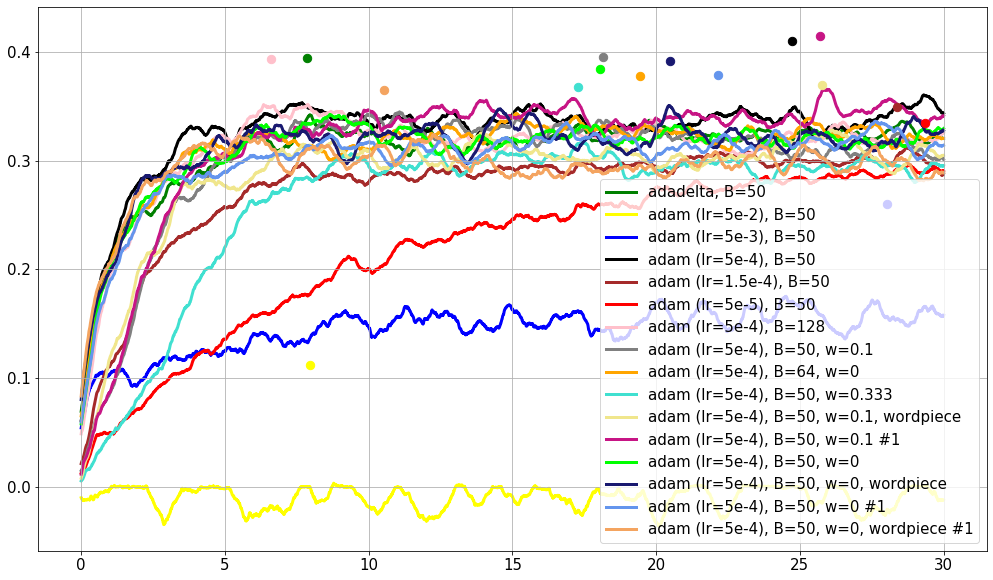

In [15]:
x_max = 30
smooth_factor = 2.0
fig = plt.figure(figsize=(17, 10))
ax = plt.gca()
for i, (label, data) in enumerate(bilstm_line_data.items()):
    smooth_n = int(len(data)/100*smooth_factor)
    data_smooth = smooth_series(data, N=smooth_n)
    xs = np.linspace(start=0, stop=x_max, num=len(data_smooth))
    ax.plot(xs, data_smooth, label=label, lw=3, c=cls[i], zorder=1)
    max_idx = np.argmax(data.values)
    ax.scatter(x_max*max_idx/len(data), data[max_idx], marker="o", c=cls[i], s=70, zorder=2)
for label, e, data in bilstm_in_progress:
    data_smooth = smooth_series(data, N=15)
    xs = np.linspace(start=0, stop=e, num=len(data_smooth))
    ax.plot(xs, data_smooth, label=label, lw=1, linestyle="--", marker='.')
ax.legend()
ax.grid()
plt.show()

**Conclusions**
- Adam with $\eta=5\times10^{-4}$ is the best learning algo
- small batch size (50) may be the best option, though 64 or 128 doesn't make things much worse
- adding warmup slows convergence and doesn't improve things (slight decrease even)

# Analysing different hyperparameters for BERT student on CoLA
Using small student (2 layers, 2 heads, hidden dimension 256, intermediate layer of 512 units), with Adam optimizer, no gradient accumulation, distilledover 100 epochs with temperature=2.0, max. seq. length 128, embeddings initialised from finetuned teacher and dimensionality-reduced using a linear layer.

Medium/2.2M model has 4 layers and 2 heads.

In [83]:
bert_line_files = {
                # SMALL
                "wp=0.1, B=256, lr=5e-4": "tb_Nov26_23-22-34_landonia21.inf.ed.ac.uk.csv",
                "wp=0.0, B=256, lr=5e-4": "tb_Nov27_10-47-37_landonia21.inf.ed.ac.uk.csv",
                "wp=0.1, B=128, lr=5e-4": "tb_Nov27_10-50-43_landonia21.inf.ed.ac.uk.csv",
                "wp=0.1, B=64, lr=5e-4": "tb_Nov27_10-49-23_landonia21.inf.ed.ac.uk.csv",
                "wp=0.2, B=256, lr=5e-4": "tb_Nov27_17-33-02_landonia21.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=1.5e-4": "tb_Nov27_17-34-15_landonia11.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=1.5e-3": "tb_Nov28_11-05-07_landonia11.inf.ed.ac.uk.csv",

                "wp=0.1, B=128, lr=5e-4, wordpiece": "tb_Dec03_11-12-41_landonia11.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=5e-4, wordpiece": "tb_Dec03_18-31-03_landonia11.inf.ed.ac.uk.csv",
}
                # MEDIUM
"""
                "wp=0.1, B=128, lr=5e-4, wordpiece, medium": "tb_Dec03_11-25-27_landonia11.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=5e-4, wordpiece, medium": "tb_Dec03_21-01-25_letha03.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=5e-4, wordpiece-1": "tb_Dec29_15-10-28_letha04.inf.ed.ac.uk.csv",
                "wp=0.1, B=128, lr=5e-4, word": "tb_Dec30_17-49-02_letha05.inf.ed.ac.uk.csv",
                
                "wp=0.1, B=128, lr=5e-4, wordpiece": "tb_Dec30_17-48-59_letha05.inf.ed.ac.uk.csv",
#                 "wp=0.1, B=128, lr=5e-4, wordpiece, #1": "tb_Jan01_15-24-06_letha05.inf.ed.ac.uk.csv",
                "wp=0.1, B=128, lr=5e-4, wordpiece, H=1": "tb_Jan03_15-36-42_letha04.inf.ed.ac.uk.csv",
                "wp=0.1, B=128, lr=5e-4, wordpiece, H=4": "tb_Jan03_15-36-17_letha04.inf.ed.ac.uk.csv",
                
                "wp=0.1, B=256, lr=5e-4, word": "tb_Dec29_15-48-11_letha04.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=5e-4, word, #1": "tb_Jan01_15-24-12_letha05.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=5e-4, word, H=1": "tb_Jan03_15-11-20-1_letha05.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=5e-4, word, H=4": "tb_Jan03_15-11-20_letha05.inf.ed.ac.uk.csv",
    
                "wp=0.1, B=128, lr=5e-4, wordpiece, H=1, T=3": "tb_Jan08_21-47-16_letha04.inf.ed.ac.uk.csv",
                "wp=0.1, B=128, lr=5e-4, wordpiece, H=2, T=3": "tb_Jan09_14-12-26_letha06.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=5e-4, word, H=1, T=3": "tb_Jan09_07-21-47_letha04.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=5e-4, word, H=2, T=3": "tb_Jan10_08-06-52_letha04.inf.ed.ac.uk.csv",
    
                "wp=0.1, B=128, lr=5e-4, word, T=3, multichannel": "tb_Jan12_20-10-08_letha04.inf.ed.ac.uk.csv",
                "wp=0.1, B=256, lr=5e-4, wordpiece, T=3, multichannel": "tb_Jan12_19-48-06_letha04.inf.ed.ac.uk.csv",
             }
        """
bert_line_data = {label: pd.read_csv(file)["mcc"] for label, file in bert_line_files.items()}

bert_in_progress = [
#     ("wp=0.1, B=128, lr=5e-4, lin. right", 97.7, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011622421835025674, 0.0030889596407547458, -0.00841431393219928, -0.017473675350509265, -0.0027223527162149527, -0.01195247684298504, -0.020642028725254398, -0.021353693535138347, -0.012669120208991563, -0.01141730607498555, -0.0005199345148946707, -0.012449416192626465, 0.013110095196879555, 0.00549689055149894, 0.0008958757224193086, -0.013095582161085893, 0.013723412075262894, 0.032811276629808726, 0.01154037950224983, 0.029844452857321267, 0.011224714606260962, 0.005659246674762381, 0.0014188843101355646, 0.01771216119850825, 0.007995507027755554, 0.0008958757224193086, 0.008562491623613201, 0.018025032779383877, -0.0233807096399483, -0.011060894858381869, 0.01721084242484694, 0.0265146711057552, -0.004111471850317359, 0.014370514469140007, 0.007534282675628492, -0.009860075556963615, 0.007568273354698935, 0.004467585233410383, 0.019950882341394343, -0.005894520770924507, 0.01154037950224983, 0.014077336042426758, 0.0024763761493444563, 0.02828381181795015, 0.019104165673761397, -0.00321822747333226, 0.03217758569491649, 0.02481646758441379, 0.021034550224763103, 0.028176788640149556, 0.04075743811108359, 0.009630118923933574, 0.00417556798563858, 0.03480191397038331, 0.00116629353426909, 0.007026547836273316, 0.0002591686442876958, 0.006965944341422074, -0.003904379891479733, 0.008430658741443782, 0.015579573198757614, 0.00823665460608448, 0.010827805669936446, 0.008166399900252625, 0.027241587879929335, 0.006504545870277941, 0.02210428078568791, 0.013972908434625946, 0.013549608524380752, 0.049908476071401996, 0.01797134156495028, 0.047570837299069024, 0.04333714763759323, 0.0627680329700815, 0.053840264337449324, 0.04409643269853063, 0.06878221138815414, 0.04354359241177337, 0.025511258654130203, 0.047332757620851346, 0.03774220536832568, 0.04634015524680143, 0.04001336193641522, 0.05546396242790733, 0.06457230365019842, 0.04975842504532833, 0.051410165460067235, 0.05207813977429579, 0.045486163539892085, 0.03947107781387454, 0.029403070944968943, 0.041513884056212556, 0.0594428346569121, 0.03631218001078973, 0.04108180630909555, 0.06423066145378613, 0.03947107781387454, 0.029278680172151378, 0.03480069416770672, 0.036666838719809025, 0.04510485141239956, 0.0225198449533417, 0.020034272469381557, 0.043079231876207554, 0.014764641501332287, 0.02383628877114382, 0.007947964289920373, 0.030998644732840922, 0.02334127184099442, 0.010289788760255148, 0.029654926430548404, -0.004048037623499232, 0.0344556042072698, 0.04366028751366058, 0.03774220536832568, 0.027299946667339897, 0.040810735290564316, 0.07160538250772189, 0.06096709224434929, 0.03087806285025844, 0.04307464156172051, 0.04473582944909966, 0.025144915041708085, 0.029504671972223825, 0.03137510588738004, 0.017250651532214965, 0.026029174581437973, 0.027997887192322376, 0.02295144175099137, 0.04325910938884999, 0.03505072577703314, 0.08358395003502136, 0.0700601609158785, 0.09803617326507873, 0.055312607111279534, 0.051485315750485136, 0.0647674605134599, 0.05373746752832175, 0.041608536126477004, 0.04996996277691138, 0.08818640638655306, 0.036666838719809025, 0.0667441892820069, 0.08560587610944498, 0.06994356793961189, 0.05146071928082744, 0.05231001524129303, 0.0430481924739576, 0.061078728519428103, 0.02361805641876822, 0.04450357727968692, 0.03459685994971704, 0.035835732728702156, 0.022067101449159066, 0.04122496780807908, 0.05051490896122173, 0.04561642072109392, 0.04242989828970896, 0.06280671959623209, 0.04151689700276776, 0.06465589078632934, 0.06290286828136452, 0.055507894252540414, 0.07568945120824479, 0.0889189307303208, 0.05532255433611549, 0.08112438563503774, 0.041450301527939576, 0.061012478560866765, 0.03397069079304566, 0.06280671959623209, 0.036352139874007906, 0.08825049117845662, 0.08382215590402259, 0.05909174197511046, 0.07710280871942585, 0.09277018719404721, 0.08032987279303862, 0.07237732899835453, 0.03995108940301536, 0.10196510278640546, 0.0573877980226542, 0.08420421416082549, 0.06878221138815414, 0.0719158420648774, 0.04998376985379713, 0.05544068090469987, 0.07834075453269701, 0.05723454998326968, 0.09903277435674401, 0.09012716809012944, 0.11166418336918776, 0.08739947056037811, 0.08148216162413352, 0.1056557189275646, 0.10434442634113784, 0.11732436397380978, 0.07568945120824479, 0.08042167651160122, 0.09005052104634213, 0.04950112826798062, 0.07738473272434816, 0.11156494078271653, 0.08141029597838412, 0.10671104907272197, 0.08254689584504264, 0.06471249922330295, 0.0902344207703017, 0.03350543475734407, 0.07355184699311824, 0.08236228353828158, 0.08175108409017773, 0.08710021280330801, 0.0654989328604012, 0.06307407488404682, 0.0456868885783852, 0.07672808876985052, 0.05766065353766447, 0.0999892222211763, 0.10261174111560117, 0.0980520969731504, 0.06692046409660439, 0.0871848968998618, 0.06893452108893586, 0.05242835306439285, 0.04340093274650329, 0.07711798579176454, 0.0932488887627139, 0.07170607943811631, 0.12105671697795137, 0.06323345162869361, 0.08718618506749748, 0.1265205184125765, 0.06997384517281006, 0.06471249922330295, 0.06293162513016043, 0.057215655069032416, 0.08097826504378595, 0.06278519556175939, 0.06635583278930876, 0.05860208799134219, 0.08006803097744833, 0.08913478144365089, 0.07166857813353605, 0.10767522887348824, 0.07163028805617874, 0.1080291656147323, 0.11363806297455119, 0.11763143484036118, 0.1255260512509306, 0.07608046046607447, 0.09187753419792309, 0.12961235818308653, 0.10539239067627112, 0.09197902574992636, 0.07508200304516384, 0.0951039122870703, 0.12040320925260838, 0.08239016064333389, 0.10724057902023709, 0.0889647792916452, 0.15839762509164965, 0.1080291656147323, 0.07339508385609972, 0.11847158572617092, 0.10575189028404523, 0.08811408651094657, 0.11361555659659135, 0.10962781931858787, 0.10451124263480288, 0.08051243929793982, 0.0788539949377536, 0.09116517224008766, 0.12017941685808589, 0.09608077775971557, 0.10549049137169143, 0.07001227538804344, 0.08509759953378888, 0.1280618805073397, 0.1264403429093884, 0.1509592590146645, 0.12786798896301224, 0.160408281896884, 0.1251716373616064, 0.11434966910670653, 0.11861343588463745, 0.09785200767509804, 0.10772375765100758, 0.13806817981746097, 0.14545828625749307, 0.11075235134282446, 0.12474305235886379, 0.09472138771242544, 0.08949268520819186, 0.1163333073924135, 0.07728716020021262, 0.09096530150080366, 0.13863244404031252, 0.09305897560752993, 0.0773089456059127, 0.08843416400157314, 0.09479027897712053, 0.10372884998165778, 0.10864609205493897, 0.09474597290626137, 0.06611471458444347, 0.10437940095807845, 0.09026144638070416, 0.11289993338179437, 0.10896931215473486, 0.10509476725389434, 0.13299832955197513, 0.14473677058380396, 0.14412496021603272, 0.1049535667908795, 0.12359851987031846, 0.112327763443674, 0.10571500999065667, 0.07333874182760093, 0.0980520969731504, 0.08866486920309995, 0.10816816286642765, 0.08220636763584084, 0.1129048035523458, 0.08175927264528918, 0.11415043333891922, 0.08015877090661065, 0.09042997729551279, 0.09305897560752993, 0.11452009608833603, 0.09639180875142503, 0.06850814852032129, 0.08369053019265868, 0.08753156647211414, 0.09526372529156256, 0.06349105690199025, 0.08029505917458109, 0.14024670778332954, 0.12247959665279079, 0.12106933044866976, 0.10600164922415099, 0.11521595874365233, 0.12073105148250744, 0.1406444511310852, 0.11042882140267563, 0.13025715593770187, 0.10082645875260575, 0.13433055918306755, 0.1214230915133559, 0.12561099247020174, 0.1272125643393363, 0.12370863184794434, 0.15565312844156887, 0.14889144215769273, 0.14848538444228, 0.11220325850686207, 0.13242562046875356, 0.11007759188677306, 0.1163333073924135, 0.10286989578166968, 0.09906068273338402, 0.1125458026825155, 0.13925069231659018, 0.14221796917396112, 0.1015089264900061, 0.12753307190734858, 0.15230980268138064, 0.11791562480484524, 0.11705808759148237, 0.16700279210456556, 0.12395711901056716, 0.1567229872202615, 0.11451075499127257, 0.14514936207481444, 0.12568055969019556, 0.13509845465208634, 0.1025993350656801, 0.11391096350272635, 0.08773458116395068, 0.11339079937553255, 0.11429164698211637, 0.12753307190734858, 0.12708946447269565, 0.07333874182760093, 0.10400282407668013, 0.09213306820299823, 0.10098791281948111, 0.1049535667908795, 0.08057925665929164, 0.07488110864400657, 0.09623711399540488, 0.09042430279352305, 0.12237836244272593, 0.14486758670199923, 0.10268841712899737, 0.07893986331660625, 0.1297779625552326, 0.08565172113069296, 0.12229102288274309, 0.11166418336918776, 0.11339079937553255, 0.0936566443123652, 0.11045920450276826, 0.09842635371376497, 0.10466746585465142, 0.06094545754962005, 0.10548048715926805, 0.11722433605015561, 0.10937979173366325, 0.08661326972492873, 0.12589214342534782, 0.1335419140486174, 0.11876003770200773, 0.13333509215105613, 0.12229102288274309, 0.14466290297616988, 0.0799181584309579, 0.09524312033216221, 0.11820165145116945, 0.13720721289886614, 0.1132264971951739, 0.13870216975054203, 0.11720933695122061, 0.15657761279559218, 0.15770601221088873, 0.1313025643570977, 0.14619822502688745, 0.1583546690158471, 0.12298793282357692, 0.09491950803582828, 0.1341616641120523, 0.08459402343109, 0.1335202100569271, 0.15256295361114142, 0.15884229768357425, 0.16225607703267486, 0.14169502080714078, 0.1659195267062713, 0.17255592689098234, 0.11763916474875225, 0.13801716995655958, 0.1692522215632906, 0.1339321766850336, 0.12496674436947987, 0.14285173272758805, 0.09823230485467256, 0.08332630908455557, 0.09061232694501084, 0.09982381365008104, 0.1099836582703807, 0.14496801325011588, 0.14618855870968453, 0.11333472372158096, 0.09458291369481411, 0.11434966910670653, 0.140422853653535, 0.13139211248325197, 0.1426548528713053, 0.1317701093275558, 0.12237836244272593, 0.13263777508261554, 0.13359757959042426, 0.1297435556477695, 0.1505432140458159, 0.08544572727506887, 0.11948328623158176, 0.1627137599025059, 0.17439152888200474, 0.18333305179333018, 0.10010417402185123, 0.12360371537601686, 0.1251131484896812, 0.1160388084462809, 0.11094139169291216, 0.1483659579882051, 0.12229102288274309, 0.1302111000739341, 0.1522671709474482, 0.1332339418309482, 0.0925750573417966, 0.12480194838959996, 0.1093571889958704, 0.14571954076301957, 0.10656487580892658, 0.1362584635393116, 0.11135155384947569, 0.13990003157259376, 0.12806728225067732, 0.10614316120782262, 0.1505602235670948, 0.1214230915133559, 0.11286648055756936, 0.12266412727377281, 0.1265205184125765, 0.1278302795073983, 0.10509476725389434, 0.12960515007382117, 0.1256459615068686, 0.1453052743139867, 0.13057788366352377, 0.10642001389209851, 0.1292242676891085, 0.13025715593770187, 0.1273682813303332, 0.1529442480840972, 0.12044825921692395, 0.1343898148185121, 0.15613491091732531, 0.14178619470571371, 0.14961584122234545, 0.13289344741315148, 0.15298139501542396, 0.13137634266049855, 0.14701856533254504, 0.13447152115893618, 0.15407988923414176, 0.14750388305466128, 0.16269139623259038, 0.12360371537601686, 0.12482084489816894, 0.10380860126427023, 0.15721204793196886, 0.16557069643523778, 0.08535463346513071, 0.11729653385057198, 0.1227895067378549, 0.12403719563254378, 0.11757980904334828, 0.14234364686663234, 0.1689566648445807, 0.16098499004461977, 0.14398850308210345, 0.11729653385057198, 0.1376016251890398, 0.16460025110414658, 0.1631996211106378, 0.09982381365008104, 0.12340355248153173, 0.1352112068431589, 0.11818409443621868, 0.10995605912172093, 0.14704799869354718, 0.12910757756649413, 0.171518535025403, 0.13722663407006647, 0.1293625911383467, 0.14942733529558552, 0.13614516063673882, 0.10354505019889985, 0.1698490404778195, 0.098720398117113, 0.11009553909792837, 0.1445844591945264, 0.14666102779918108, 0.1445162175572302, 0.15208449808035646, 0.15678643795528638, 0.12041337097850079, 0.11926818464018978, 0.13659357568149674, 0.14895523894141713, 0.10456009191992248, 0.12017076696608325, 0.1526488595848993, 0.12090225670740633, 0.1630034476867032, 0.16351802321175685, 0.10376244101719512, 0.16946946410419259, 0.162104687937372, 0.1794259438018491, 0.15615310454328543, 0.15711532287236443, 0.16599709077834823, 0.17800356442291182, 0.15437209184543843, 0.17250663326551519, 0.1445844591945264, 0.1893997407662758, 0.15525199295039885, 0.13894281000608433, 0.17220635045328583, 0.11791562480484524, 0.15755648480668086, 0.20326477187801534, 0.14104604489966568, 0.13817391149738298, 0.14920417911539863, 0.13512488808418308, 0.12939371252468282, 0.11026669163207188, 0.13476175810742616, 0.11700882412869382, 0.13010877692003636, 0.11389643176464308, 0.08300801435614485, 0.12522581091353274, 0.12905870890284726, 0.14104606142225773, 0.14683146318989015, 0.18721768280067558, 0.13476175810742616, 0.1320653407416963, 0.14285173272758805, 0.13464559570806003, 0.15677745345652094, 0.13313980145761345, 0.13048994532888494, 0.13066345719085995, 0.11585661993239478, 0.13009816262911333, 0.12490292474785736, 0.1581283947550856, 0.09969176280304604, 0.13475013027835261, 0.1125458026825155, 0.12603392315505682, 0.11475675939064635, 0.16195277350335702, 0.16054112787889724, 0.16598797343954547, 0.16722744396677502, 0.13011901828693212, 0.1522774535740945, 0.1761048008420891, 0.1631996211106378, 0.1699251833566497, 0.12247959665279079, 0.139126318883386, 0.12169536319928609, 0.1401063805752864, 0.1293625911383467, 0.17659728337969258, 0.13428134541195216, 0.135781442012244, 0.1378462047079388, 0.1867531681602621, 0.15623025605088015, 0.16438374052011195, 0.1806794564702054, 0.15327784498642255, 0.11075235134282446, 0.12263959574944572, 0.15611484269949602, 0.13416706058165595, 0.16091837323651975, 0.15897360692586232, 0.16373256326255095, 0.151586500059387, 0.13982593577610886, 0.18621251090582996, 0.14821106646634613, 0.14409561823208006, 0.21303087069772822, 0.15755648480668086, 0.14484514718797295, 0.14160644853470883, 0.11452009608833603, 0.1838819283835666, 0.15302523883116925, 0.18737377765581165, 0.1678710349983309, 0.13683664004168192, 0.15711532287236443, 0.1584328337011006, 0.1251591159068797, 0.1378462047079388, 0.13057788366352377, 0.10437798570183357, 0.11607182849062908, 0.15623025605088015, 0.13116953803561146, 0.1164638713613227, 0.11126796125753434, 0.15613491091732531, 0.1793083546142375, 0.13057788366352377, 0.1336286052843893, 0.1664860129091747, 0.15801481438452158, 0.1483659579882051, 0.12122627331722984, 0.16822399596632828, 0.1460967080751735, 0.15669076864895734, 0.16283341065704757, 0.158841901878975, 0.16276809661834724, 0.14691165782581692, 0.16550805420117004, 0.12568055969019556, 0.14319602613443033, 0.1611978847644058, 0.14167213975882045, 0.17142452849004555, 0.10404836553830564, 0.10191432417103656, 0.13116942570110574, 0.08787192110573078, 0.1505432140458159, 0.14982964592494533, 0.14951739780697398, 0.12449242919020706, 0.12449242919020706, 0.14367181445834845, 0.17567822996520532, 0.15818516361076118, 0.15711532287236443, 0.18009494637754053, 0.18455618176292604, 0.15897360692586232, 0.13419358529472464, 0.1275893167139847, 0.12449242919020706, 0.17527108768076072, 0.12434471826730632, 0.1317701093275558, 0.1255106947046126, 0.11450544212711358, 0.12172116730170811, 0.10700833465916305, 0.1305647035603089, 0.1501424974759359, 0.1331481188790476, 0.14724193461503085, 0.09042997729551279, 0.12813776301357746, 0.1241418293413056, 0.17953083620071889, 0.18261346715072632, 0.1406243322767692, 0.18980945083814718, 0.14398850308210345, 0.11425291837052741, 0.15807560015848449, 0.16225607703267486, 0.1371801415563112, 0.13061260395439572, 0.16084199932200738, 0.15898402254000332, 0.15819253666178704, 0.19289163440612536, 0.14805257698714275, 0.16663254122050358, 0.12604740398493144, 0.128964539526693, 0.15469127859977477, 0.1453949609145727, 0.12568055969019556, 0.15777250064651127, 0.17356923456287024, 0.14683146318989015, 0.17659728337969258, 0.16200078180744654, 0.14314704361367067, 0.15151093970693777, 0.1631165747704048, 0.16453673146081857, 0.20540840628059504, 0.15009207202252822, 0.17113622657078864, 0.17199883388059498, 0.14262495804322925, 0.16415300711779424, 0.1793431256335088, 0.19042769455245526, 0.20149110557824226, 0.17899944197392204, 0.18918528736867418, 0.1320162551756947, 0.16453673146081857, 0.14661620893605792, 0.16809521464488103, 0.1711331421914571, 0.17277126394964018, 0.1560390622592208, 0.1873787123447911, 0.18393884801510266, 0.17548531427185296, 0.13722663407006647, 0.14190432312422746, 0.17567822996520532, 0.17029117207350056, 0.1712045161065497, 0.14612479325395522, 0.17199883388059498, 0.16411291424457647, 0.16809521464488103, 0.17211785777012892, 0.20738864502723908, 0.16643978667111345, 0.17151666309413272, 0.18954364972242177, 0.1878170254994466, 0.19704871008428396, 0.20389708306553833, 0.17818558518998093, 0.21026739681607276, 0.15270447659230063, 0.16575686006800203, 0.1547087454784433, 0.18335303139676118, 0.1368842473741235, 0.12807219985966142, 0.13667652633742342, 0.1611978847644058, 0.18377102914146723, 0.18658098596451822, 0.1544594872362459, 0.15120354160824478, 0.15579463780856576, 0.15247704491527725, 0.1856889706606, 0.13061260395439572, 0.14951739780697398, 0.1770920141915097, 0.15765723388708794, 0.1838610746487515, 0.16476484879054704, 0.16438447105868612, 0.18784456321790452, 0.16550805420117004, 0.17882304656720546, 0.17679003949624963, 0.21214852185971947, 0.18230662921037344, 0.17473032980121947, 0.17125329358420754, 0.17105094581021868, 0.19365741047745594, 0.18817999616519093, 0.16394768841132482, 0.16039452795747666, 0.15087119476418223, 0.17841645267216275, 0.16557069643523778, 0.19808284915683244, 0.1697621982026258, 0.1756298335479189, 0.19232653495059893, 0.1591255823101609, 0.15302773124313832, 0.16260999118187522, 0.1513921170584048, 0.16894622143358706, 0.1775361397987292, 0.15677745345652094, 0.135781442012244, 0.15633701833196625, 0.14521022990697338, 0.17211785777012892, 0.1556914671770591, 0.13659357568149674, 0.15422705143601834, 0.19988966994361268, 0.19184633593200798, 0.157552787224655, 0.17083980097568646, 0.19910561389266943, 0.17884418268749336, 0.20571694935049317, 0.19024148189705473, 0.16514812449241445, 0.16054112787889724, 0.18393884801510266, 0.1845485616065543, 0.215749262643618, 0.16459582411516843, 0.1738735356873133, 0.17113622657078864, 0.16368950489474143, 0.17127344978212583, 0.14750388305466128, 0.17517184646219058, 0.1733739765249169, 0.17795509386006178, 0.1631494683034944, 0.13391692543865394, 0.17063683561379675, 0.16195410171450783, 0.18831378211341354, 0.1756298335479189, 0.1732439168586429, 0.171518535025403, 0.18546218990537355, 0.1836019811506833, 0.17530409396935706, 0.20022177339562466, 0.1803677294663952, 0.16682543613096285, 0.1558893807146074, 0.20995840663190013, 0.1651601068676887, 0.17548531427185296, 0.18835112903271387, 0.1687606174284995, 0.17953083620071889, 0.15628228996253435, 0.17606243748479136, 0.19761583395661242, 0.1944880399881072, 0.19364727200605825, 0.1584328337011006, 0.1886355297952276, 0.1697621982026258, 0.1982241421968871, 0.22019345434606005, 0.20020993954754007, 0.1912663659377004, 0.1802025287466822, 0.1859946170887915, 0.18691052887630996, 0.17380144198022587, 0.17113622657078864, 0.18361105636195904, 0.14172401247921368, 0.18058611390902446, 0.13925252554220774, 0.1896785513172281, 0.19302058384816684, 0.17704874813885593, 0.22207538842508065, 0.20009292464179904, 0.17083980097568646, 0.17953083620071889, 0.18784421019852973, 0.1830164342481813, 0.21845102510039088, 0.1558893807146074, 0.1841002306539124, 0.171518535025403, 0.16582246966638103, 0.1766606611750777, 0.140422853653535, 0.19365741047745594, 0.19519532565119432, 0.16156800088255333, 0.17523704842787105, 0.17818558518998093, 0.15330127064131505, 0.1776370700632321, 0.18455618176292604, 0.1969122767968508, 0.16179503723852764, 0.1689170133746743, 0.17704874813885593, 0.19257823613633265, 0.21477688175782397, 0.14398850308210345, 0.19236376788879814, 0.1651601068676887, 0.1589853660549816, 0.18753987500783506, 0.15270447659230063, 0.1776370700632321, 0.20217562003031586, 0.1851956111780091, 0.16647242410801416, 0.16097404973304297, 0.18114381278329975, 0.19182139988408964, 0.15095117889320872, 0.20832685628547387, 0.20007860945310357, 0.18889166023774348, 0.21845102510039088, 0.20638640170983927, 0.20071550297095533, 0.18242102036102437, 0.21900169808387265, 0.19707312291240978, 0.1975249173655199, 0.22644304601304788, 0.19502254270784866, 0.20481338639618307, 0.1962378985326022, 0.16003208545469114, 0.1720627403089719, 0.1838806266083814, 0.18242102036102437, 0.18799075574681304, 0.20429410207373278, 0.19056039646685188, 0.16753896347636857, 0.19756483582739826, 0.2032892540518167, 0.19257823613633265, 0.1851956111780091, 0.21649587108867205, 0.20202574535824777, 0.17683711490102408, 0.16862922586185206, 0.19640653615972264, 0.1955940686399126, 0.20768134279324005, 0.20429410207373278, 0.17625512810575733, 0.17953083620071889, 0.15952523498984195, 0.19208820610985453, 0.20202574535824777, 0.21455296941986043, 0.18191254435845491, 0.17882304656720546, 0.2208303521528171, 0.21023368850969973, 0.19780411954709826, 0.21770473657108047, 0.19006456933307134, 0.19388786032814417, 0.21334161721247732, 0.19763239753933823, 0.21156498071994503, 0.19106774086691022, 0.22766279592720273, 0.17981139690599762, 0.20846163630294479, 0.19632022096957083, 0.18650771050300116, 0.20271486988064752, 0.22261875788322052, 0.24420311801674618, 0.21342384345871818, 0.21428651086075598, 0.21630114322246263, 0.19881468557328097, 0.1913731252318057, 0.22975833614823102, 0.2108368134423028, 0.20653335949136387, 0.18521614939973327, 0.2142375721312879, 0.19808284915683244, 0.2198619682090848, 0.21653564109705256, 0.21583451853942953, 0.17792348501808206, 0.20960951333857294, 0.23410056206034538, 0.21530407044365008, 0.19753931888472284, 0.16039452795747666, 0.20406577715466703, 0.19714871101156078, 0.18546218990537355, 0.20093891447261092, 0.18914243059621486, 0.18561682354121142, 0.20206241531013067, 0.21310688268119804, 0.22471959229840982, 0.23325479749251213, 0.1901894558539434, 0.20200387113964383, 0.22424582075928595, 0.17659728337969258, 0.21338894069293238, 0.23051521624550111, 0.19640155139282814, 0.21213756412974807, 0.20960951333857294, 0.2239042300872526, 0.18737377765581165, 0.20858966172976115, 0.219443785956581, 0.22833591012033538, 0.20580724488596225, 0.21843786164029594, 0.1813697714888523, 0.17430479758268133, 0.1793431256335088, 0.1900422370384719, 0.18200759440674386, 0.19640155139282814, 0.19881468557328097, 0.18846816536945507, 0.1697621982026258, 0.14058099451026052, 0.20584338258620063, 0.18271098993992005, 0.20342770054560735, 0.17725639805834, 0.19048514015934917, 0.22954047535991778, 0.18173361457823922, 0.17898245093644793, 0.14909670185279636, 0.2006985514934694, 0.20717399848949097, 0.2130659718724969, 0.20738864502723908, 0.18323623036230935, 0.17946278748705302, 0.17818558518998093, 0.16460025110414658, 0.20040528103720193, 0.2072022617205596, 0.18521614939973327, 0.20206241531013067, 0.18469581081189188, 0.20558723617101182, 0.1989327663159983, 0.1897692378923433, 0.19173034701210606, 0.19056373283634923, 0.20326477187801534, 0.20897498447647314, 0.19106774086691022, 0.18852903593359516, 0.1766606611750777, 0.2140991660804927, 0.20898426748897525, 0.20897220233431726, 0.22276061386583426, 0.21160282069831832, 0.1968774922270046, 0.21748880137123303, 0.1830164342481813, 0.18731638018637925, 0.21322857645056367, 0.1851185205859015, 0.20966396349901015, 0.22828880257584033, 0.21890180965165226, 0.22142593907719943, 0.21340757237316393, 0.22644304601304788, 0.19834732430461924, 0.22170471900037012, 0.22261875788322052, 0.2066501674619675, 0.16453673146081857, 0.18725459421801624, 0.19056373283634923, 0.17795434984072278, 0.1851956111780091, 0.18333305179333018, 0.20897220233431726, 0.17430479758268133, 0.20462677283323671, 0.1975249173655199, 0.20648149366520338, 0.20516330657574938, 0.15942945002771108, 0.17653916514343668, 0.19561981206233847, 0.1692522215632906, 0.18060224455889326, 0.1633606408529504, 0.20093891447261092, 0.17356923456287024, 0.20462677283323671, 0.19830369313128124, 0.18342442977634876, 0.2240035088664378, 0.22230601856829857, 0.20915697313080714, 0.19513275547852374, 0.1701413575192542, 0.21156498071994503, 0.1962378985326022, 0.20558723617101182, 0.2052070652456962, 0.1896785513172281, 0.15410742876189107, 0.1845485616065543, 0.1820480752563375, 0.207048457401596, 0.20902594041666467, 0.22671537592218402, 0.17991731506633946, 0.19440423458404832, 0.1611606574649403, 0.1900422370384719, 0.16809521464488103, 0.2110931909022847, 0.22578460206914616, 0.20966396349901015, 0.19432520872256864, 0.18914243059621486, 0.21900169808387265, 0.19042769455245526, 0.16578273653165576, 0.16862922586185206, 0.1935843399984104, 0.22753965662380404, 0.1878170254994466, 0.21511270242767316, 0.20481338639618307, 0.20202574535824777, 0.1815295532303978, 0.19527614120585884, 0.18753987500783506, 0.19151032940432003, 0.1949129892664094, 0.20153140110125606, 0.20834351957652464, 0.19650071749128115, 0.19628266305197425, 0.1631494683034944, 0.1878063204967837, 0.20481338639618307, 0.2186757266420954, 0.21530407044365008, 0.22578460206914616, 0.1830164342481813, 0.227841420878291, 0.2155814379238967, 0.2407911701021713, 0.20939736726254154, 0.17154877705647556, 0.20389708306553833, 0.22057049583102048, 0.21988980001663783, 0.18595741559158482, 0.17142452849004555, 0.18445822555017008, 0.2251323321091985, 0.20631549275690642, 0.22650044579294448, 0.20966396349901015, 0.20648117997641294, 0.20334542194057192, 0.19140438369338292, 0.21714459877550946, 0.20638640170983927, 0.22455773485458155, 0.1949129892664094, 0.22903909243700118, 0.20966396349901015, 0.21536460552609665, 0.2108368134423028, 0.2312752780086806, 0.22659231316465678, 0.20945483437231122, 0.22597505851104907, 0.19111625781069685, 0.2071848068349608, 0.20890935450299314, 0.2032892540518167, 0.22596991300153274, 0.18872270732358096, 0.20915697313080714, 0.22597505851104907, 0.2007882419023762, 0.24233224124733924, 0.2418049162564047, 0.257590557689401, 0.19448903806697285, 0.24525402362370372, 0.2064279310333117, 0.21655523775552388, 0.21383481724304787, 0.22776701101446373, 0.19561981206233847, 0.19513275547852374, 0.21784352955763053, 0.20717399848949097, 0.2183378791675358, 0.20739825653942073, 0.21147188175216453, 0.19704871008428396, 0.22885192879977584, 0.21160282069831832, 0.21021293504294714, 0.22145265792608676, 0.21957499434924535, 0.2271309414393642, 0.19184141924503698, 0.2340718748381182, 0.21284880815689888, 0.18256265343880135, 0.20326477187801534, 0.2286901411285955, 0.22637913579773172, 0.2668990606188593, 0.22331970375585078, 0.23376817585619566, 0.21989993859181292, 0.2418541078984718, 0.2186757266420954, 0.22276061386583426, 0.21272958231508493, 0.1792564646705696, 0.21600067365875347, 0.22341707386434628, 0.2064279310333117, 0.23522661636000078, 0.1825030404957731, 0.22738476692258813, 0.21894626694065988, 0.24448869687592642, 0.22022467463744902, 0.1851956111780091, 0.19372271421866452, 0.22943196865903503, 0.23314940391638828, 0.23502751805651323, 0.1851956111780091, 0.23502315253799716, 0.24469671359135112, 0.22381100124268438, 0.1929355625540331, 0.21425411211342046, 0.2045793578720983, 0.18870915057376272, 0.21160282069831832, 0.2233378124843827, 0.19865700975091324, 0.21023209755191855, 0.1917292390957614, 0.20009292464179904, 0.1830164342481813, 0.18716442754183213, 0.23011563653426548, 0.23429998972258884, 0.19370046584272668, 0.23009984145073, 0.1944880399881072, 0.215749262643618, 0.16803279235743063, 0.18702129963259054, 0.1806794564702054, 0.18914680894696692, 0.22758244388383697, 0.2141379418554607, 0.17653916514343668, 0.19917446639499126, 0.2130558362502192, 0.2077534611706664, 0.1975249173655199, 0.21380396597259513, 0.21283772313423086, 0.2052070652456962, 0.2006985514934694, 0.20008806547557545, 0.22080942932671346, 0.21703845185867235, 0.20414600298035118, 0.22134509417937026, 0.18469581081189188, 0.20206241531013067, 0.1774682630662371, 0.19888819174214173, 0.24725780951448623, 0.19282896529110272, 0.20020119544844528, 0.20238743748832264, 0.21672446142022367, 0.19056039646685188, 0.22758244388383697, 0.25543605575849065, 0.21303087069772822, 0.2302364142319509, 0.19386172105076396, 0.2326208784537296, 0.21203264081017137, 0.20897498447647314, 0.19024337211076706, 0.23950737402959668, 0.1905241211537216, 0.20762220592788957, 0.20653335949136387, 0.21459225384390915, 0.22424582075928595, 0.20939736726254154, 0.21989993859181292, 0.22622452727592832, 0.20107520538558843, 0.2289414380404013, 0.22597505851104907, 0.20895267408908288, 0.21900169808387265, 0.21545145053538217, 0.19702053887493873, 0.22650044579294448, 0.1993915700703528, 0.19151032940432003, 0.22644304601304788, 0.20973710284875346, 0.23847261280139315, 0.23148866842075763, 0.23051521624550111, 0.1896785513172281, 0.21583451853942953, 0.22025329020363907, 0.19650071749128115, 0.1954598708228026, 0.19541237103795764, 0.2089765645317175, 0.17625512810575733, 0.21542611568032874, 0.24403662295886433, 0.19844597267323985, 0.16507384604669306, 0.1803677294663952, 0.21368914790079416, 0.20897498447647314, 0.207210039149247, 0.18889166023774348, 0.21338894069293238, 0.16934463432068372, 0.20867184493678875, 0.19182139988408964, 0.22223259405702478, 0.20898426748897525, 0.22742673625537718, 0.2221172362135175, 0.21600067365875347, 0.20093891447261092, 0.2239042300872526, 0.21988980001663783, 0.21160282069831832, 0.20846163630294479, 0.20648149366520338, 0.21160282069831832, 0.1830164342481813, 0.1962378985326022, 0.20509009001376238, 0.19527614120585884, 0.22821412203212682, 0.22142676145739906, 0.20093891447261092, 0.19282896529110272, 0.20540840628059504, 0.22659231316465678, 0.23754226363116726, 0.20334542194057192, 0.22704890347306653, 0.22142593907719943, 0.2257770580402391, 0.20768134279324005, 0.2140991660804927, 0.222679890827076, 0.26281922791737194, 0.2545936220289859, 0.23060210855014857, 0.21899588326304203, 0.22578460206914616, 0.23255811285674224, 0.2439812930311633, 0.2513413354546134, 0.25332639830009884, 0.24066366100893638, 0.21504466135847491, 0.2232120080883875, 0.22145265792608676, 0.2155814379238967, 0.22664335116079343, 0.234431376192227, 0.2221172362135175, 0.2239042300872526, 0.2561002444928063, 0.23263019933906712, 0.22829091046096106, 0.20481338639618307, 0.20863125889432763, 0.19334922666866655, 0.22145265792608676, 0.2094582490664236, 0.18954364972242177, 0.22523054443469998, 0.1975974827620114, 0.1776370700632321, 0.2155059874317179, 0.21334161721247732, 0.17746544267549333, 0.22419778209545216, 0.21232225162073415, 0.17430479758268133, 0.21283772313423086, 0.193166250035665, 0.20548235038963866, 0.20137407600144125, 0.1969122767968508, 0.18521614939973327, 0.17474101497204728, 0.1901894558539434, 0.2064279310333117, 0.22067150540670982, 0.22145265792608676, 0.18261346715072632, 0.2094582490664236, 0.2070697735054299, 0.2460437933366867, 0.20093891447261092, 0.21584180061318783, 0.22390643020265752, 0.2070697735054299, 0.18789794365866594, 0.20616380727643108, 0.1784611609483538, 0.1989327663159983, 0.20717399848949097, 0.21355012764725054, 0.20867417740918626, 0.21338894069293238, 0.22276061386583426, 0.20453681999433324, 0.21160282069831832, 0.2130558362502192, 0.18542843024510478, 0.21035009567453852, 0.24141421027393123, 0.21691914487332556, 0.24537804125365995, 0.23956771164798327, 0.24281369380554785, 0.23571231546729038, 0.21786929926509574, 0.23638533933127334, 0.20129910037904322, 0.20737809972235108, 0.20334542194057192, 0.22327600059983133, 0.22704890347306653, 0.23308338798696043, 0.2232120080883875, 0.20850816920345616, 0.19314060306309833, 0.18646358741163713, 0.24321177040819328, 0.22455773485458155, 0.21988980001663783, 0.23091891299780942, 0.1878063204967837, 0.21776622523773148, 0.2064279310333117, 0.21776622523773148, 0.2180884417877342, 0.20137407600144125, 0.18525558880214385, 0.24469671359135112, 0.20516330657574938, 0.21649587108867205, 0.20379233529363142, 0.22643934692336393, 0.23491561124405602, 0.21023368850969973, 0.24034147305189313, 0.23237405239945857, 0.23721102430784513, 0.2340718748381182, 0.22390643020265752, 0.236498666486716, 0.22142593907719943, 0.23370929409401253, 0.2036902925552141, 0.21156498071994503, 0.2240174878500216, 0.23208938358593978, 0.21036668011300375, 0.21770473657108047, 0.2235131095078494, 0.20638640170983927, 0.21600067365875347, 0.20548235038963866, 0.23376817585619566, 0.2033839172010707, 0.1919158944962371, 0.17593921069334956, 0.19266000509124984, 0.20135953925450759, 0.20516330657574938, 0.20768134279324005, 0.2036902925552141, 0.22037445237760042, 0.24564757289434166, 0.2258064041441721, 0.2239042300872526, 0.1962378985326022, 0.17740990880200608, 0.17289226543326427, 0.17588019030493596, 0.18754063831605286, 0.20199102515114034, 0.18650771050300116, 0.2209514035355889, 0.2179419917238012, 0.2251323321091985, 0.1975249173655199, 0.21774924564150214, 0.21397427867606245, 0.21511270242767316, 0.1996440323279005, 0.21524151168039987, 0.1733739765249169, 0.19976140919974747, 0.20406577715466703, 0.21784352955763053, 0.2150476883717999, 0.19462299157628635, 0.18512056733801416, 0.20277927380309382, 0.19667640049267285, 0.20460982913308554, 0.1865199413173589, 0.21747050475197735, 0.21530407044365008, 0.21915863633584906, 0.21407145191241214, 0.22158949612892298, 0.21110083030684088, 0.22419778209545216, 0.2171035309876708, 0.2235131095078494, 0.21988980001663783, 0.20762220592788957, 0.20199102515114034, 0.21062146241001228, 0.18065940210425946, 0.21026739681607276, 0.21789250337255767, 0.19632022096957083, 0.2032892540518167, 0.22204307871932266, 0.21477688175782397, 0.22331970375585078, 0.20610173869231138, 0.22346192896483907, 0.20834351957652464, 0.1955940686399126, 0.19808284915683244, 0.21722727021400903, 0.1994381269813825, 0.21021293504294714, 0.21600257569680592, 0.19270190162939754, 0.22514197488118148, 0.21477688175782397, 0.191233108902799, 0.19183352844256124, 0.19976140919974747, 0.20040528103720193, 0.18256265343880135, 0.1969122767968508, 0.16737619646779828, 0.1972792922453862, 0.18914680894696692, 0.16828679210147998, 0.18335303139676118, 0.1720035744176683, 0.21586638199864336, 0.20145602526361508, 0.21430666899976167, 0.21023209755191855, 0.18488177883994797, 0.18375574343502155, 0.17991731506633946, 0.2085118981847656, 0.20841969084953363, 0.18918528736867418, 0.1944880399881072, 0.19302838045638288, 0.21627365389541237, 0.16700279210456556, 0.20406577715466703, 0.18128507399389626, 0.21584180061318783, 0.20153140110125606, 0.2219420834236104, 0.2078904208765722, 0.23985260898664917, 0.2113095686829966, 0.2066501674619675, 0.2219420834236104, 0.23878691998865037, 0.2108368134423028, 0.1946612918225643, 0.20675489400468391, 0.20153015520697193, 0.19815881725409978, 0.19334922666866655, 0.2093586498637795, 0.18784456321790452, 0.2098204168745519, 0.1940782030114845, 0.1905241211537216, 0.1683587384889031, 0.17551930953305714, 0.18335303139676118, 0.20145602526361508, 0.20898426748897525, 0.1935843399984104, 0.193166250035665, 0.21459225384390915, 0.20592681681482733, 0.24165771295553604, 0.19650071749128115, 0.19365741047745594, 0.20919663407711273, 0.20379233529363142, 0.22025329020363907, 0.20406577715466703, 0.19780411954709826, 0.2208959505549839, 0.21380396597259513, 0.19635676101740346, 0.21026739681607276, 0.18221211159680895, 0.22573819311612775, 0.19756483582739826, 0.1905241211537216, 0.22424582075928595, 0.21636240350310834, 0.21649587108867205, 0.23519233669775863, 0.18850013538163093, 0.21147188175216453, 0.22541730182403236, 0.20460982913308554, 0.2196738992223907, 0.18852903593359516, 0.19151032940432003, 0.17628447970203184, 0.22880676209063258, 0.21073489303519027, 0.21335509616371773, 0.21065877701459743, 0.20762220592788957, 0.1996440323279005, 0.21338894069293238, 0.21065877701459743, 0.21175397700287898, 0.19444543384229496, 0.17527108768076072, 0.2071848068349608, 0.19402865106252176, 0.18854897570653667, 0.20535069125160124, 0.21536460552609665, 0.23064942779315423, 0.2141391201618867, 0.23064942779315423, 0.22650044579294448, 0.21584180061318783, 0.233792919114617, 0.24225772846357418, 0.22635765182612608, 0.20631549275690642, 0.2239042300872526, 0.26419032454585817, 0.2574925985647346, 0.24100429459258446, 0.2312541887293493, 0.2216778441320201, 0.20590654318613655, 0.20897220233431726, 0.2064279310333117, 0.2362194325635801, 0.20558723617101182, 0.22459096236356985, 0.2208959505549839, 0.1954598708228026, 0.24100429459258446, 0.21124140231842248, 0.21462820614637154, 0.1975249173655199, 0.17795434984072278, 0.21462820614637154, 0.20791604739916728, 0.2324990430050044, 0.22635765182612608, 0.2316544441188978, 0.20040528103720193, 0.236472269352173, 0.1761048008420891, 0.2244813390387582, 0.21023368850969973, 0.22063435047887, 0.20773345454466052, 0.19365741047745594, 0.20500750805712248, 0.19761583395661242, 0.19365741047745594, 0.18995216077389832, 0.1841002306539124, 0.20397196066910597, 0.16438447105868612, 0.1801948041333311, 0.18835112903271387, 0.18696639927550643, 0.18965905849198525, 0.19448903806697285, 0.1882496509144976, 0.20107520538558843, 0.21466081930132386, 0.1949129892664094, 0.18546218990537355, 0.18752136105846562, 0.19402865106252176, 0.20398859370985978, 0.1946220912560018, 0.2297281316775227, 0.18828073066867831, 0.19282896529110272, 0.2054511259282027, 0.20334542194057192, 0.20769102959717195, 0.201703199982491, 0.21903837559176814, 0.18426496683141208, 0.2362194325635801, 0.22381100124268438, 0.19980006588041713, 0.20429410207373278, 0.24141421027393123, 0.24448869687592642, 0.19865700975091324, 0.17926496084467897, 0.22742673625537718, 0.21592081433264854, 0.22575013512770656, 0.2297281316775227, 0.20548235038963866, 0.20558723617101182, 0.202848913429316, 0.23011563653426548, 0.20966396349901015, 0.2334831796010946, 0.19696397099348129, 0.19320224599798086, 0.1949487581568613, 0.19402865106252176, 0.1900422370384719, 0.19780411954709826, 0.240679944180816, 0.21747050475197735, 0.23410056206034538, 0.18526132046499788, 0.21525985527913893, 0.21380396597259513, 0.22150408286611414, 0.20249306389462524, 0.21747050475197735, 0.20768134279324005, 0.19674481765703747, 0.219443785956581, 0.18918528736867418, 0.1982241421968871, 0.230955087667665, 0.19372271421866452, 0.1697621982026258, 0.19881468557328097, 0.18488177883994797, 0.21074602707779394, 0.20020119544844528, 0.20223204954017351, 0.20238743748832264, 0.20846163630294479, 0.2089277178069975, 0.19581858415246253, 0.2068789240712614, 0.1892031948505983, 0.21147188175216453, 0.17590360592201115, 0.21029610146600056, 0.19203500485843725, 0.21155864875389613, 0.23169720619266385, 0.18143273283327502, 0.1946220912560018, 0.19184633593200798, 0.19024337211076706, 0.22933300518272287, 0.19048514015934917, 0.21915508893309973, 0.23315224346442234, 0.2032892540518167, 0.1990239541232203, 0.20137407600144125, 0.21110083030684088, 0.22650044579294448, 0.20768134279324005, 0.2098628816456837, 0.19061480252837523, 0.20768134279324005, 0.22664335116079343, 0.20277927380309382, 0.21284880815689888, 0.23524228402920183, 0.19370046584272668, 0.2373783557412206, 0.22243166732456107, 0.19704871008428396, 0.2066501674619675, 0.18128507399389626, 0.1878170254994466, 0.1859946170887915, 0.20077767632962168, 0.18435404769025665, 0.1664414876598719, 0.1782744291837008, 0.20077767632962168, 0.20481338639618307, 0.19502254270784866, 0.19890946491512373, 0.19541237103795764, 0.17899944197392204, 0.20773345454466052, 0.2095825130703524, 0.20352351487064926, 0.20663409035121802, 0.19598285606507887, 0.1993915700703528, 0.19766819390858656, 0.19071853921694057, 0.20460982913308554, 0.1962378985326022, 0.18888324030916712, 0.20063485504033263, 0.20064568527268659, 0.19048514015934917, 0.1975974827620114, 0.1901894558539434, 0.20897498447647314, 0.18984065854253904, 0.21338894069293238, 0.1878063204967837, 0.1996440323279005, 0.19640155139282814, 0.19042769455245526, 0.20591061623169118, 0.18886625574116458, 0.1769838674159593, 0.16815900940879278, 0.1825030404957731, 0.17898245093644793, 0.21989993859181292, 0.20919663407711273, 0.207210039149247, 0.23854876866645197, 0.24351435810077246, 0.21417617485609874, 0.20200387113964383, 0.20772414595339533, 0.20153015520697193, 0.21542611568032874, 0.21709032142453535, 0.21407145191241214, 0.20816923802289877, 0.22312492961752908, 0.20898426748897525, 0.18518358605669244, 0.21915863633584906, 0.19365741047745594, 0.21845057799459083, 0.25597167441137864, 0.23082112202610802, 0.22619489345615718, 0.2258064041441721, 0.2367621318229222, 0.21662902993449656, 0.20516330657574938, 0.24096825077571757, 0.22455773485458155, 0.26424686288608, 0.20300898321608601, 0.22116615825232055, 0.22025329020363907, 0.23473441073354398, 0.22275413604738714, 0.20508786432924336, 0.21747050475197735, 0.234523215865254, 0.27331878884390964, 0.21900169808387265, 0.2407911701021713, 0.1949659534910423, 0.1996440323279005, 0.20867417740918626, 0.20738864502723908, 0.20707612053597738, 0.21087417189966218, 0.20107520538558843, 0.21709032142453535, 0.20406577715466703, 0.23415395488580887, 0.21536460552609665, 0.22514197488118148, 0.2128326465203347, 0.21627365389541237, 0.2173651231331533, 0.2146639130496311, 0.1972792922453862, 0.23008767046220496, 0.22954047535991778, 0.24545439131070698, 0.2369013506036845, 0.24096825077571757, 0.23854876866645197, 0.24225772846357418, 0.23803440181386668, 0.2227215986175757, 0.23791661651885057, 0.21112788589600479, 0.23434875125542315, 0.22596991300153274, 0.23502315253799716, 0.22637913579773172, 0.24448869687592642, 0.20405122642493362, 0.23406069702398075, 0.193166250035665, 0.2244813390387582, 0.23308338798696043, 0.2180884417877342, 0.21722727021400903, 0.1999918859448658, 0.2264160560131734, 0.23809036489671787, 0.2128326465203347, 0.25302940997968987, 0.2222070133031099, 0.2518650780739424, 0.21030610751289264, 0.22204307871932266, 0.23638533933127334, 0.22943196865903503, 0.2197315918764783, 0.20738864502723908, 0.25302940997968987, 0.22805879219175007, 0.2302364142319509, 0.2222915470017006, 0.21124140231842248, 0.20376792615399295, 0.25065299170264543, 0.1944880399881072, 0.24302848632901336, 0.19100365704555963, 0.23618035010489383, 0.23697573036940148, 0.2128326465203347, 0.19006456933307134, 0.2006985514934694, 0.1803327393364879, 0.18621251090582996, 0.20112409968313477, 0.19364727200605825, 0.2171035309876708, 0.21087417189966218, 0.2232120080883875, 0.23064942779315423, 0.2276157687222166, 0.1917292390957614, 0.2045793578720983, 0.20022177339562466, 0.22419778209545216, 0.22019345434606005, 0.18646358741163713, 0.19494268617650054, 0.20393106950210332, 0.22748600612198405, 0.2085118981847656, 0.1989104931780766, 0.19888819174214173, 0.2240174878500216, 0.22419778209545216, 0.18889166023774348, 0.20663409035121802, 0.1867531681602621, 0.20334542194057192, 0.20500750805712248, 0.21272862741745172, 0.19140438369338292, 0.22783788463663482, 0.21252323296319667, 0.18309703084462517, 0.1657874095364067, 0.1788329077091717, 0.17389478627687618, 0.21213756412974807, 0.1771078430072386, 0.18831378211341354, 0.21101127651247997, 0.18888324030916712, 0.21203264081017137, 0.23189079364302315, 0.21928552196516898, 0.24046850343349138, 0.20032525792007658, 0.217651802263435, 0.21649587108867205, 0.2208959505549839, 0.2302364142319509, 0.24100429459258446, 0.22847581783050427, 0.2595961962460182, 0.22452436089340574, 0.20762220592788957, 0.21334161721247732, 0.22953248036755308, 0.2324990430050044, 0.2470622994215344, 0.22903909243700118, 0.18455702326057005, 0.16862922586185206, 0.21685524247109575, 0.20895267408908288, 0.21383481724304787, 0.20640658092849695, 0.1949129892664094, 0.21335509616371773, 0.20539379823271042, 0.23791661651885057, 0.2597914084042546, 0.2135560195247411, 0.24889832563606748, 0.23001310576603615, 0.2309239093878603, 0.21717980729246678, 0.2496817428764705, 0.2343556851116054, 0.22637913579773172, 0.236472269352173, 0.21900169808387265, 0.24101422478034612, 0.20590654318613655, 0.20119220087214282, 0.2222915470017006, 0.24096825077571757, 0.21673936393334559, 0.1996440323279005, 0.20300898321608601, 0.21498184471419843, 0.22023249509791615, 0.21709032142453535, 0.2209514035355889, 0.2371583518910576, 0.19258245081467684, 0.21588616785677534, 0.19628266305197425, 0.23481097845044813, 0.22019345434606005, 0.22369652583882307, 0.24037140596992174, 0.2511802448275475, 0.19183352844256124, 0.26309950233764196, 0.2507544004558196, 0.237948873453205, 0.2292310862010381, 0.26199863773200893, 0.21586638199864336, 0.21147188175216453, 0.21062760247200554, 0.22783788463663482, 0.21462820614637154, 0.2019511392554717, 0.21214852185971947, 0.231433434100009, 0.22545684295664428, 0.20414600298035118, 0.22450825220646464, 0.22545684295664428, 0.2141379418554607, 0.21954147739777946, 0.23255811285674224, 0.22346927841047362, 0.24459819315638218, 0.20244669533171744, 0.20631549275690642, 0.22886515779735808, 0.20481338639618307, 0.21228334731211448, 0.21928552196516898, 0.20198478688712324, 0.1993053424829308, 0.18831378211341354, 0.20032525792007658, 0.20414600298035118, 0.18914680894696692, 0.16967063303809693, 0.19799756245332678, 0.18426496683141208, 0.1913731252318057, 0.2179998422463109, 0.21543964266992857, 0.19494268617650054, 0.18675478008827168, 0.20867417740918626, 0.21103661534603463, 0.19712881820802625, 0.1615890740731301, 0.2054511259282027, 0.20265760584058318, 0.2141391201618867, 0.20702670637273632, 0.21756463955154312, 0.18909743707204332, 0.20434920413415086, 0.2075361968324936, 0.20509009001376238, 0.23024218050657877, 0.19781039945623266, 0.22143328329759973, 0.19834732430461924, 0.19667640049267285, 0.19729541111301532, 0.21325587021553824, 0.21988967285386227, 0.22280382305801125, 0.21284880815689888, 0.20429410207373278, 0.1865368694363044, 0.2056675309685385, 0.19598285606507887, 0.18696639927550643, 0.21073489303519027, 0.21228422615985293, 0.22041684876999945, 0.227841420878291, 0.22142676145739906, 0.22820154587140562, 0.23048837574385367, 0.23833210539224078, 0.2098204168745519, 0.1972792922453862, 0.22748778630785618, 0.19890946491512373, 0.19867052467762158, 0.180986719720856, 0.22346192896483907, 0.22145265792608676, 0.21900169808387265, 0.2080573785730678, 0.22880676209063258, 0.21155864875389613, 0.24141421027393123, 0.2294316731044511, 0.23571231546729038, 0.21662902993449656, 0.21101127651247997, 0.21709032142453535, 0.2072022617205596, 0.22635765182612608, 0.21074602707779394, 0.19427998209244765, 0.18417301389811006, 0.16352110126177402, 0.1892682142808273, 0.19988966994361268, 0.2193111904159063, 0.2221172362135175, 0.20460982913308554, 0.21543964266992857, 0.20897498447647314, 0.20008806547557545, 0.20206241531013067, 0.2221172362135175, 0.21203264081017137, 0.24545439131070698, 0.23429998972258884, 0.21334161721247732, 0.1957481077732811, 0.23878691998865037, 0.21338894069293238, 0.21397427867606245, 0.23007774232359784, 0.22484914193940517, 0.2071848068349608, 0.21462820614637154, 0.18106839961850835, 0.20717399848949097, 0.22274381427708353, 0.22230601856829857, 0.23024218050657877, 0.23194859330889722, 0.21542611568032874, 0.21894626694065988, 0.25833216367191064, 0.22067150540670982, 0.20223204954017351, 0.21325587021553824, 0.21636240350310834, 0.263062240538591, 0.24339718859979004, 0.22331970375585078, 0.23796523010251527, 0.21536460552609665, 0.2222070133031099, 0.19632022096957083, 0.20414600298035118, 0.21843786164029594, 0.18393415053505277, 0.19140438369338292, 0.2355859370531198, 0.21969503986817562, 0.2251323321091985, 0.2093586498637795, 0.22452436089340574, 0.20093891447261092, 0.20663409035121802, 0.2415973856598854, 0.18918528736867418, 0.2173651231331533, 0.21252323296319667, 0.2392794015641758, 0.18921229046375482, 0.21334161721247732, 0.23502315253799716, 0.2367621318229222, 0.21646226983912564, 0.21989993859181292, 0.23098009366477049, 0.2703459631628719, 0.21899588326304203, 0.2141391201618867, 0.21774924564150214, 0.18200759440674386, 0.19820268747055683, 0.18918528736867418, 0.23066140475275532, 0.20791604739916728, 0.21588616785677534, 0.2392794015641758, 0.21592081433264854, 0.20376792615399295, 0.19502254270784866, 0.23524228402920183, 0.20035531178393481, 0.2006985514934694, 0.20326594898923672, 0.2128326465203347, 0.21592081433264854, 0.21029610146600056, 0.20904062837370094, 0.23975849215441047, 0.20919663407711273, 0.22650044579294448, 0.2033839172010707, 0.2239042300872526, 0.2109619954013116, 0.20200387113964383, 0.21103661534603463, 0.20330760534806933, 0.22184610214212905, 0.20590654318613655, 0.22644304601304788, 0.2271309414393642, 0.21334161721247732, 0.22885192879977584, 0.19598285606507887, 0.17588019030493596, 0.1946612918225643, 0.21208982576182409, 0.22041684876999945, 0.21646226983912564, 0.22014439230466687, 0.20334542194057192, 0.20040528103720193, 0.1896785513172281, 0.19414545063067182, 0.2183378791675358, 0.1954598708228026, 0.21175397700287898, 0.21459225384390915, 0.21694324647957494, 0.2334831796010946, 0.23873058052559787, 0.23449547034325402, 0.22622452727592832, 0.21845102510039088, 0.195809866815927, 0.21940021358586972, 0.20610173869231138, 0.21398610367866228, 0.18512056733801416, 0.21156498071994503, 0.23809036489671787, 0.23434875125542315, 0.2093586498637795, 0.2465574667127129, 0.17154877705647556, 0.2415973856598854, 0.22953248036755308, 0.19519532565119432, 0.21774924564150214, 0.20379233529363142, 0.22204307871932266, 0.22704890347306653, 0.21662902993449656, 0.1986575478652592, 0.18662745749574208, 0.2229381353954278, 0.22886659346465513, 0.22490345192768452, 0.21195782810940178, 0.20093891447261092, 0.21843925650516788, 0.2058914383488661, 0.18483007699586326, 0.19541237103795764, 0.1892682142808273, 0.21508366770394285, 0.19629040057860206, 0.21900169808387265, 0.2222070133031099, 0.17335683612485578, 0.18817999616519093, 0.19541237103795764, 0.19781039945623266, 0.2141379418554607, 0.20867184493678875, 0.21627365389541237, 0.21296288627880988, 0.2010707376280058, 0.22401807451047753, 0.20398859370985978, 0.20764616526410024, 0.1989104931780766, 0.19581858415246253, 0.22671537592218402, 0.2343556851116054, 0.2507544004558196, 0.2152188048401981, 0.23522661636000078, 0.21228334731211448, 0.19808284915683244, 0.19151032940432003, 0.20416628771320083, 0.19024148189705473, 0.2098204168745519, 0.2181281466647706, 0.2036491604079722, 0.21047592084855424, 0.20332271832479518, 0.17835493376080847, 0.18469581081189188, 0.1769838674159593, 0.17142452849004555, 0.2033839172010707, 0.21195782810940178, 0.20462677283323671, 0.2072022617205596, 0.21657519574073825, 0.2559516184924921, 0.20369818047279895, 0.18791963250554952, 0.24136808731468395, 0.19898161312281795, 0.21928552196516898, 0.22361162352320607, 0.2269709695576945, 0.19623979453948567, 0.20301391954233827, 0.21047592084855424, 0.22313857057090136, 0.20379233529363142, 0.22116615825232055, 0.23502315253799716, 0.2146639130496311, 0.22322814320631604, 0.18200759440674386, 0.22471959229840982, 0.21398610367866228, 0.1993915700703528, 0.22025329020363907, 0.2179419917238012, 0.20136309685773873, 0.21195269120480215, 0.21087417189966218, 0.21636240350310834, 0.1741378092990926, 0.22346927841047362, 0.1976366849356895, 0.21928552196516898, 0.2023146620691951, 0.1990239541232203, 0.2334831796010946, 0.22243166732456107, 0.2197315918764783, 0.16889124773394135, 0.1873787123447911, 0.1991435913326641, 0.19330232843216877, 0.21175397700287898, 0.1813697714888523, 0.19414545063067182, 0.22704890347306653, 0.20137886298979674, 0.16533210825388184, 0.20187581252402176, 0.21232225162073415, 0.20904062837370094, 0.21195782810940178, 0.20022177339562466, 0.2113095686829966, 0.2103560961635067, 0.20631549275690642, 0.21398610367866228, 0.21023209755191855, 0.21477014436643851, 0.1972147576652205, 0.1993915700703528, 0.19282896529110272, 0.18556905039400395, 0.18964651855250944, 0.21430666899976167, 0.22067150540670982, 0.21542611568032874, 0.24403014767471667, 0.20834351957652464, 0.18914680894696692, 0.2098050765667049, 0.2083167076931265, 0.20205893204697106, 0.21466081930132386, 0.20679717266311815, 0.19024148189705473, 0.22545684295664428, 0.21824152286842158, 0.20149110557824226, 0.224716209479683, 0.24339718859979004, 0.2402089607546163, 0.2433880561337818, 0.2141379418554607, 0.21026739681607276, 0.19061480252837523, 0.20465954957743057, 0.2120944063442922, 0.17801515823155598, 0.19867052467762158, 0.21969503986817562, 0.2095825130703524, 0.21482672325003788, 0.18996906739798186, 0.20508786432924336, 0.2036491604079722, 0.20762220592788957, 0.20416628771320083, 0.2160964029270057, 0.2116706163362063, 0.20326594898923672, 0.19184141924503698, 0.20200387113964383, 0.21380396597259513, 0.20500750805712248, 0.2058914383488661, 0.22051782950115864, 0.22275413604738714, 0.2083167076931265, 0.19667640049267285, 0.2169205293601287, 0.2171687909250368, 0.20942337542287973, 0.20919663407711273, 0.193166250035665, 0.2258064041441721, 0.21429707728195427, 0.18426496683141208, 0.202848913429316, 0.20591061623169118, 0.21175397700287898, 0.21459225384390915, 0.19464342752560748, 0.20460982913308554, 0.2209514035355889, 0.23524228402920183, 0.21087417189966218, 0.21989993859181292, 0.23675106122453426, 0.21112788589600479, 0.25257594647356124, 0.1993053424829308, 0.2227215986175757, 0.23370929409401253, 0.2036491604079722, 0.20811082465122818, 0.20470763068387277, 0.2188797646291972, 0.20406577715466703, 0.20112409968313477, 0.22019345434606005, 0.2054511259282027, 0.1711331421914571, 0.18717414255716852, 0.21430666899976167, 0.22266584476266954, 0.21462966773581318, 0.22346192896483907, 0.20238743748832264, 0.237948873453205, 0.22390643020265752, 0.20535069125160124, 0.21101127651247997, 0.2152188048401981, 0.21989993859181292, 0.24470309759229497, 0.2258064041441721, 0.2398080289138087, 0.23001310576603615, 0.2123954984264632, 0.22748600612198405, 0.22145265792608676, 0.2398080289138087, 0.23001310576603615, 0.227841420878291, 0.23201452649222323, 0.20735152520483732, 0.25953663647502295, 0.21933665564194593, 0.21727929926631598, 0.21673936393334559, 0.2240035088664378, 0.2173651231331533, 0.21148178606518211, 0.20675489400468391, 0.21915508893309973, 0.19635676101740346, 0.20498253104070246, 0.1993053424829308, 0.19732069143082395, 0.21717980729246678, 0.19830369313128124, 0.21899588326304203, 0.21370642022375488, 0.1913731252318057, 0.21717980729246678, 0.20073260322735875, 0.21466081930132386, 0.2098204168745519, 0.24224071600570968, 0.24441645627074549, 0.21065877701459743, 0.23382675672665273, 0.2058914383488661, 0.23926280900898536, 0.21284880815689888, 0.22401807451047753, 0.21228334731211448, 0.22231934954858926, 0.2189172338471419, 0.22619489345615718, 0.20301391954233827, 0.20032525792007658, 0.21969503986817562, 0.1999918859448658, 0.17451737148625024, 0.1817335620011774, 0.20205893204697106, 0.17898645394612717, 0.17653916514343668, 0.22346192896483907, 0.22943196865903503, 0.21588616785677534, 0.23916830634072658, 0.23066140475275532, 0.23044270934854658, 0.22102657060321748, 0.19623979453948567, 0.2094582490664236, 0.20330760534806933, 0.17641316224983097, 0.2083641225026443, 0.19160183538363385, 0.21228422615985293, 0.23889431529292185, 0.1983718011680718, 0.20330760534806933, 0.22886659346465513, 0.2186329474687171, 0.21958453575389425, 0.21542611568032874, 0.23032656915562805, 0.2221172362135175, 0.23551640536133853, 0.23074468675376475, 0.22357060963990064, 0.22722309690839215, 0.23598550441973767, 0.212371821825996, 0.2349193442362663, 0.24281369380554785, 0.23123588020783678, 0.19502254270784866, 0.20332271832479518, 0.19696397099348129, 0.23687172768558049, 0.20393106950210332, 0.19844597267323985, 0.22955389157414344, 0.22847581783050427, 0.20009292464179904, 0.19359346672022418, 0.23473441073354398, 0.19224266602597345, 0.19140438369338292, 0.21153541327926526, 0.21460264507628732, 0.20408881471593668, 0.21466081930132386, 0.21339975773524028, 0.23379892213834777, 0.21325587021553824, 0.2098204168745519, 0.20673546515733623, 0.19130020008805693, 0.2019511392554717, 0.236472269352173, 0.17728740635447818, 0.19386156829709789, 0.1841002306539124, 0.21026739681607276, 0.19940485761940416, 0.20610173869231138, 0.18857584774782074, 0.2080573785730678, 0.18121240214631767, 0.22063435047887, 0.18222470499369742, 0.18682208368594083, 0.20470763068387277, 0.23723651276810176, 0.2498593831811951, 0.22500271827545165, 0.23315224346442234, 0.21498184471419843, 0.20398859370985978, 0.19464342752560748, 0.24115032293230712, 0.1975974827620114, 0.18512056733801416, 0.19368308982157456, 0.2183378791675358, 0.1882496509144976, 0.1964530526855624, 0.20153140110125606, 0.21508366770394285, 0.2109619954013116, 0.1989064128933342, 0.20769102959717195, 0.18872270732358096, 0.19796368647632903, 0.21074602707779394, 0.2140991660804927, 0.19541237103795764, 0.22150408286611414, 0.20516330657574938, 0.2321446466652109, 0.22150408286611414, 0.24374708325064798, 0.24572636204735215, 0.19509448333901758, 0.2093586498637795, 0.19566798479945066, 0.19158942235167215, 0.21110083030684088, 0.22243166732456107, 0.20904062837370094, 0.18752136105846562, 0.1817335620011774, 0.21073489303519027, 0.17836772896623554, 0.2188797646291972, 0.2350652138844827, 0.2006985514934694, 0.21252323296319667, 0.18964651855250944, 0.21073489303519027, 0.2228586457244174, 0.22025629975222688, 0.19482542374330256, 0.22322814320631604, 0.2036491604079722, 0.202848913429316, 0.19667640049267285, 0.2059327331651617, 0.1966206441309754, 0.19427998209244765, 0.1929355625540331, 0.18515159133341458, 0.19158942235167215, 0.17564387669704665, 0.18799761419331315, 0.18852903593359516, 0.18964651855250944, 0.18696639927550643, 0.1803114239822009, 0.20032525792007658, 0.19330232843216877, 0.2113095686829966, 0.19509448333901758, 0.20063485504033263, 0.18753987500783506, 0.21709032142453535, 0.19502077388873593, 0.1993915700703528, 0.20999117045731625, 0.19225376527640867, 0.20205893204697106, 0.23398083336331799, 0.2141391201618867, 0.18173361457823922, 0.17530409396935706, 0.21843786164029594, 0.20064568527268659, 0.18559962106167152, 0.21833971484843, 0.22346192896483907, 0.22346192896483907, 0.20369818047279895, 0.20301391954233827, 0.22274381427708353, 0.21023209755191855, 0.22797343818218418, 0.2239042300872526, 0.21325587021553824, 0.2394557157010518, 0.1976366849356895, 0.21764023774072996, 0.22644304601304788, 0.24225772846357418, 0.21770473657108047, 0.2197315918764783, 0.24038117724916938, 0.21335509616371773, 0.2179998422463109, 0.23551640536133853, 0.23007774232359784, 0.21536460552609665, 0.20481338639618307, 0.21380396597259513, 0.21885486490089368, 0.19881468557328097, 0.22322814320631604, 0.21498184471419843, 0.24302848632901336, 0.18696639927550643, 0.21508366770394285, 0.21466081930132386, 0.2312885421948531, 0.22224402835832607, 0.2126612344532538, 0.20568842257044923, 0.22327600059983133, 0.2343556851116054, 0.22400939823426075, 0.24224071600570968, 0.2094582490664236, 0.24220066674670496, 0.21958453575389425, 0.22143328329759973, 0.2080573785730678, 0.18852903593359516, 0.20136309685773873, 0.21803834739064673, 0.20332271832479518, 0.22490345192768452, 0.19448903806697285, 0.21788993044738017, 0.21110019355563267, 0.22014439230466687, 0.23571231546729038, 0.20458125713066433, 0.21954147739777946, 0.2218311154932002, 0.2141379418554607, 0.22880676209063258, 0.21885486490089368, 0.23916830634072658, 0.23555896561332282, 0.2555043572060786, 0.2666110474182544, 0.2232120080883875, 0.20465954957743057, 0.20112409968313477, 0.18469581081189188, 0.23878691998865037, 0.22037445237760042, 0.20283945262328343, 0.21147188175216453, 0.2095825130703524, 0.21455296941986043, 0.22041684876999945, 0.2103560961635067, 0.22419778209545216, 0.202848913429316, 0.21153541327926526, 0.22546462130890468, 0.22450825220646464, 0.23147368692768125, 0.20679717266311815, 0.21588616785677534, 0.23174536190201553, 0.1864833617405191, 0.20775442805908936, 0.20022177339562466, 0.21524151168039987, 0.195809866815927, 0.1966206441309754, 0.22797343818218418, 0.24525402362370372, 0.2392794015641758, 0.24403662295886433, 0.24540595724185177, 0.24768083723702025, 0.23651932795648126, 0.21989993859181292, 0.2244813390387582, 0.24592608425248794, 0.23325510982218547, 0.22274381427708353, 0.18753987500783506, 0.1893033587852993, 0.20433340696857782, 0.22361162352320607, 0.21803834739064673, 0.2179998422463109, 0.2054511259282027, 0.195932195722815, 0.22381100124268438, 0.21492379245533605, 0.20434920413415086, 0.191233108902799, 0.2141391201618867, 0.21788993044738017, 0.20591061623169118, 0.19393010230075577, 0.20640658092849695, 0.20299944827799987, 0.20919663407711273, 0.2232120080883875, 0.22953248036755308, 0.21074602707779394, 0.2185681428676619, 0.22419778209545216, 0.22063435047887, 0.2140991660804927, 0.1993053424829308, 0.237948873453205, 0.20283945262328343, 0.1839859390814772, 0.24038117724916938, 0.2033839172010707, 0.22490345192768452, 0.21989210808627235, 0.22275413604738714, 0.224716209479683, 0.2189172338471419, 0.22797343818218418, 0.20960951333857294, 0.23736810158739946, 0.25216543948967407, 0.24522640657850495, 0.21065877701459743, 0.22656505159762355, 0.18912365474121887, 0.20591061623169118, 0.21074602707779394, 0.21203264081017137, 0.20707612053597738, 0.19224266602597345, 0.2064562139350282, 0.21586638199864336, 0.19972184373658422, 0.20599633974111575, 0.21940021358586972, 0.21756463955154312, 0.1940782030114845, 0.2159719595809333, 0.19858539343835374, 0.22545684295664428, 0.1913731252318057, 0.17476963216497354, 0.2267591776073067, 0.20465954957743057, 0.2071848068349608, 0.20416628771320083, 0.2254593202057436, 0.2229381353954278, 0.22331970375585078, 0.19660596016856746, 0.236472269352173, 0.2113095686829966, 0.20904062837370094, 0.20032525792007658, 0.22829091046096106, 0.1999918859448658, 0.1726431863048474, 0.21370642022375488, 0.19482542374330256, 0.20568842257044923, 0.20850816920345616, 0.1940782030114845, 0.19061480252837523, 0.18852903593359516, 0.2283932825148418, 0.21252323296319667, 0.23001310576603615, 0.207210039149247, 0.22847581783050427, 0.21774924564150214, 0.23878691998865037, 0.2160964029270057, 0.21182875529279313, 0.21026739681607276, 0.1981928892766816, 0.2163485934697119, 0.21915508893309973, 0.21360392492928412, 0.2208959505549839, 0.21498184471419843, 0.20369818047279895, 0.2240035088664378, 0.22544483431155077, 0.23189079364302315, 0.21536460552609665, 0.21843786164029594, 0.21303087069772822, 0.20772414595339533, 0.20238743748832264, 0.2155814379238967, 0.22313857057090136, 0.2409895386892063, 0.21228422615985293, 0.2160964029270057, 0.20930169798465195, 0.22783788463663482, 0.23492308130830772, 0.22063435047887, 0.24115032293230712, 0.22243166732456107, 0.20735152520483732, 0.20429410207373278, 0.19635676101740346, 0.20780039717241708, 0.2239042300872526, 0.236472269352173, 0.2058914383488661, 0.22313857057090136, 0.2292310862010381, 0.18355420687999605, 0.20168527596098912, 0.21627365389541237, 0.23048837574385367, 0.24037140596992174, 0.2258064041441721, 0.22573988997298566, 0.2252918007985283, 0.2252918007985283, 0.19344402112628614, 0.2219420834236104, 0.2251323321091985, 0.21460068028345466, 0.21460264507628732, 0.18656897284728016, 0.1807485069230737, 0.20244669533171744, 0.23975849215441047, 0.2567855647711933, 0.2294316731044511, 0.23821573214640315, 0.22545684295664428, 0.23148866842075763, 0.2334831796010946, 0.21592081433264854, 0.24417702066855965, 0.23502751805651323, 0.2341977562785998, 0.20898426748897525, 0.21508366770394285, 0.22109826660542278, 0.21498184471419843, 0.20960951333857294, 0.195809866815927, 0.20999117045731625, 0.2159719595809333, 0.21213756412974807, 0.23449547034325402, 0.2371583518910576, 0.24608121330103414, 0.2108368134423028, 0.21788993044738017, 0.20816923802289877, 0.21636240350310834, 0.23809036489671787, 0.21845057799459083, 0.22903909243700118, 0.20591061623169118, 0.20508786432924336, 0.21894626694065988, 0.23848748733331596, 0.24403662295886433, 0.2258064041441721, 0.24592608425248794, 0.206030143400452, 0.24281369380554785, 0.24768562492907278, 0.24475581809306624, 0.23311989195708302, 0.2385904876241994, 0.22886659346465513, 0.245246792831297, 0.22748778630785618, 0.22401807451047753, 0.24119917680233047, 0.22080942932671346, 0.19158347515659407, 0.2409895386892063, 0.2519239320963639, 0.2398080289138087, 0.25429071884737875, 0.23973847913723986, 0.21584180061318783, 0.24284707221807011, 0.2189172338471419, 0.25125835432284965, 0.20107520538558843, 0.2013253937657137, 0.2196738992223907, 0.2302364142319509, 0.21073489303519027, 0.23598550441973767, 0.222679890827076, 0.21543964266992857, 0.23398083336331799, 0.24171970240017412, 0.2103560961635067, 0.2276157687222166, 0.21325587021553824, 0.26902462477550787, 0.23382675672665273, 0.19140438369338292, 0.21204544456909147, 0.2240174878500216, 0.23598550441973767, 0.23760535359506268, 0.22361162352320607, 0.22456335648631337, 0.22101189451155945, 0.2402089607546163, 0.23557742249995717, 0.22019345434606005, 0.2175616500549755, 0.2297281316775227, 0.2058111938795722, 0.1967308440506053, 0.21592081433264854, 0.23551640536133853, 0.22253166018932985, 0.2368059560760543, 0.24171970240017412, 0.21756463955154312, 0.22204307871932266, 0.20897498447647314, 0.23007774232359784, 0.22019345434606005, 0.21727929926631598, 0.21284880815689888, 0.23132304745386884, 0.22748778630785618, 0.2292310862010381, 0.21368914790079416, 0.22699583601410994, 0.19024337211076706, 0.22080942932671346, 0.2333945322251097, 0.2216778441320201, 0.2218548251865665, 0.21895435040258018, 0.23186655069030834, 0.224716209479683, 0.20206241531013067, 0.21957499434924535, 0.2209514035355889, 0.2181281466647706, 0.21899588326304203, 0.22722309690839215, 0.21636240350310834, 0.2045793578720983, 0.19780411954709826, 0.17378811160354368, 0.22820154587140562, 0.1878063204967837, 0.20040528103720193, 0.20265760584058318, 0.21524151168039987, 0.23398083336331799, 0.20679717266311815, 0.19541237103795764, 0.21112788589600479, 0.23985667152646728, 0.2449139729667958, 0.2209514035355889, 0.22644304601304788, 0.22327600059983133, 0.2565420187449642, 0.2418541078984718, 0.21284880815689888, 0.22142676145739906, 0.23082112202610802, 0.2394557157010518, 0.2469880790487139, 0.24100429459258446, 0.22612720266185388, 0.2209514035355889, 0.2292310862010381, 0.1954598708228026, 0.2054511259282027, 0.21662902993449656, 0.18355420687999605, 0.2339386224010668, 0.21195269120480215, 0.240679944180816, 0.24786461772325238, 0.22877684728266628, 0.2439812930311633, 0.23502315253799716, 0.22976528537442897, 0.19048514015934917, 0.23733903407187548, 0.20811082465122818, 0.21588616785677534, 0.1993053424829308, 0.20995840663190013, 0.21543964266992857, 0.19980006588041713, 0.21671339449824398, 0.2394557157010518, 0.2469880790487139, 0.2533194221075324, 0.23048837574385367, 0.23557742249995717, 0.22063435047887, 0.23006747366399544, 0.23077366775074495, 0.24448869687592642, 0.23325510982218547, 0.2631244861142923, 0.22976528537442897, 0.2529798220124375, 0.25204585378814975, 0.24333020302819347, 0.25558283032139295, 0.2620806693313456, 0.25237227778891025, 0.233792919114617, 0.24682476746105952, 0.22829091046096106, 0.2607330830967691, 0.24225772846357418, 0.2661620675620489, 0.21973322655344313, 0.25475792560898136, 0.23736810158739946, 0.2518585784555598, 0.24403662295886433, 0.2252967413768067, 0.22582020481261048, 0.21156498071994503, 0.21915508893309973, 0.26012842341219927, 0.26469561382439305, 0.25058183841505205, 0.2415973856598854, 0.23842111931480597, 0.24272460542650337, 0.236472269352173, 0.2362194325635801, 0.22274381427708353, 0.23223175833862883, 0.24193582683383524, 0.22748600612198405, 0.2292310862010381, 0.23736810158739946, 0.21296288627880988, 0.23308338798696043, 0.2433880561337818, 0.21627365389541237, 0.19808284915683244, 0.2251323321091985, 0.2302364142319509, 0.23201452649222323, 0.2169205293601287, 0.21498184471419843, 0.2294316731044511, 0.24420311801674618, 0.23311989195708302, 0.22797343818218418, 0.2639355463849243, 0.24417702066855965, 0.24100429459258446, 0.24655329408814988, 0.2221172362135175, 0.24403014767471667, 0.2586275730366408, 0.23264830597302652, 0.22442179174841134, 0.21894626694065988, 0.22456335648631337, 0.2460437933366867, 0.23551640536133853, 0.22331970375585078, 0.24587934752420204, 0.20888297027376584, 0.2352285547930793, 0.2201869218947992, 0.17483824808885565, 0.19756483582739826, 0.22771993527662118, 0.24037140596992174, 0.27378019116435004, 0.24295421433913034, 0.24366814047835833, 0.24579085243664195, 0.23557742249995717, 0.2222070133031099, 0.23492308130830772, 0.22903909243700118, 0.2524133897823288, 0.22514197488118148, 0.24772891433362496, 0.23557742249995717, 0.21894626694065988, 0.25361383480690347, 0.20775442805908936, 0.23981285560644772, 0.217651802263435, 0.22067150540670982, 0.2265836865606632, 0.21124140231842248, 0.24277785494932697, 0.24638881524371647, 0.24909443340425108, 0.21101127651247997, 0.24638881524371647, 0.23502751805651323, 0.2548047933955944, 0.20107520538558843, 0.22787029161353742, 0.2033839172010707, 0.20764616526410024, 0.22014439230466687, 0.21973322655344313, 0.21584919086351265, 0.21303087069772822, 0.23449547034325402, 0.2561002444928063, 0.21430666899976167, 0.20376792615399295, 0.20904062837370094, 0.1961869161819662, 0.2229381353954278, 0.21498184471419843, 0.2252522596161022, 0.2249607930117914, 0.23761788541031528, 0.23098009366477049, 0.23135794138347232, 0.22456335648631337, 0.2312541887293493, 0.2227215986175757, 0.24540595724185177, 0.22322814320631604, 0.23148866842075763, 0.24317605252828417, 0.254050550921887, 0.2239042300872526, 0.2355859370531198, 0.24459819315638218, 0.21826900177030018, 0.21885486490089368, 0.2257690348796879, 0.2033839172010707, 0.24171970240017412, 0.23551504139036217, 0.2297281316775227, 0.24621103009610384, 0.2394557157010518, 0.21360392492928412, 0.22102657060321748, 0.2350652138844827, 0.19568866184526368, 0.20406577715466703, 0.22303678593243842, 0.22361162352320607, 0.22575013512770656, 0.26193086177227265, 0.2394557157010518, 0.2563444563533776, 0.24767982663408608, 0.2346215231726801, 0.22442179174841134, 0.21508366770394285, 0.20498253104070246, 0.20675489400468391, 0.2333340077562881, 0.23697573036940148, 0.19566798479945066, 0.2218548251865665, 0.2140991660804927, 0.20775442805908936, 0.21331815793411338, 0.23398083336331799, 0.24374708325064798, 0.2517596224880464, 0.2601876084330076, 0.2123954984264632, 0.19769112894287527, 0.22650044579294448, 0.20888297027376584, 0.21627365389541237, 0.20762220592788957, 0.2367407269171173, 0.22995913227474338, 0.22596991300153274, 0.21492379245533605, 0.21954147739777946, 0.22067150540670982, 0.20035531178393481, 0.21380396597259513, 0.2083641225026443, 0.2064562139350282, 0.1942796620578548, 0.22711573312901123, 0.224716209479683, 0.22155771140814293, 0.21843786164029594, 0.20079035720733832, 0.20511122328536788, 0.2209193326368675, 0.2483728901130966, 0.21636240350310834, 0.2286821408265756, 0.2232120080883875, 0.1838610746487515, 0.20733018666886602, 0.2316544441188978, 0.23434875125542315, 0.21429707728195427, 0.20250933301426116, 0.2160964029270057, 0.20762220592788957, 0.2103560961635067, 0.21845057799459083, 0.21492379245533605, 0.1999918859448658, 0.22025629975222688, 0.21843925650516788, 0.23736810158739946, 0.2385904876241994, 0.19494268617650054, 0.2232120080883875, 0.22116615825232055, 0.21073489303519027, 0.20548235038963866, 0.22787029161353742, 0.23848748733331596, 0.2427003686035201, 0.2174440644848328, 0.21284880815689888, 0.2141379418554607, 0.24010643960019984, 0.21455296941986043, 0.24046850343349138, 0.25178058865116754, 0.23251244002075877, 0.23975849215441047, 0.21303087069772822, 0.22452436089340574, 0.23008767046220496, 0.22787029161353742, 0.24038117724916938, 0.2179998422463109, 0.22911035694337956, 0.24262990210999652, 0.19867052467762158, 0.23916502214329322, 0.21717980729246678, 0.22671537592218402, 0.22619489345615718, 0.22748600612198405, 0.21845057799459083, 0.2058914383488661, 0.23467562712224727, 0.2267808635721075, 0.21112788589600479, 0.22322814320631604, 0.22019345434606005, 0.21933665564194593, 0.22698689683374354, 0.20568842257044923, 0.2126271056191424, 0.2265836865606632, 0.23325510982218547, 0.23186655069030834, 0.22704890347306653, 0.2549364077956714, 0.24096825077571757, 0.25298319315294665, 0.2252918007985283, 0.2346215231726801, 0.22748778630785618, 0.21023368850969973, 0.21331815793411338, 0.20153140110125606, 0.19598285606507887, 0.20300898321608601, 0.20153015520697193, 0.21788993044738017, 0.2152188048401981, 0.2257770580402391, 0.22847581783050427, 0.21156498071994503, 0.23916502214329322, 0.23733903407187548, 0.2326255060308084, 0.23975849215441047, 0.2551971168939971, 0.2181281466647706, 0.2405554689358035, 0.23066140475275532, 0.23551640536133853, 0.2324990430050044, 0.22484914193940517, 0.21525985527913893, 0.2141391201618867, 0.22899535060503456, 0.20352351487064926, 0.24759298579722905, 0.24366814047835833, 0.21368914790079416, 0.2655270816088392, 0.23174536190201553, 0.2244813390387582, 0.23796523010251527, 0.24193582683383524, 0.24141421027393123, 0.2312752780086806, 0.206030143400452, 0.20326594898923672, 0.2483728901130966, 0.22596991300153274, 0.19537525276298784, 0.24818562464336424, 0.22146896088708615, 0.21561701675704106, 0.2023146620691951, 0.20631549275690642, 0.20673546515733623, 0.19282896529110272, 0.22322814320631604, 0.24193582683383524, 0.22545684295664428, 0.19980006588041713, 0.2113095686829966, 0.2334831796010946, 0.21542611568032874, 0.18584465172784492, 0.20941635045870263, 0.2239042300872526, 0.23595670515963793, 0.24759298579722905, 0.21525985527913893, 0.23429998972258884, 0.24262990210999652, 0.22941308141870673, 0.2579334776623636, 0.2146639130496311, 0.228268896643832, 0.23382675672665273, 0.24038117724916938, 0.2216778441320201, 0.19781039945623266, 0.21584919086351265, 0.20376792615399295, 0.22456335648631337, 0.2208303521528171, 0.20035531178393481, 0.21933665564194593, 0.18537030362181628, 0.22545684295664428, 0.21885486490089368, 0.24701915855737086, 0.21368914790079416, 0.20610173869231138, 0.2181281466647706, 0.21335509616371773, 0.22014439230466687, 0.23066140475275532, 0.20999117045731625, 0.21542611568032874, 0.21460068028345466, 0.19898161312281795, 0.2058914383488661, 0.23449547034325402, 0.20434131430796748, 0.2139438463918733, 0.23008767046220496, 0.21213756412974807, 0.23273486827598086, 0.20322897251883815, 0.22545684295664428, 0.21283773210138565, 0.2312541887293493, 0.24136808731468395, 0.2324990430050044, 0.24759298579722905, 0.21087417189966218, 0.23066140475275532, 0.1838610746487515, 0.20265343177689218, 0.18696639927550643, 0.20040528103720193, 0.20995840663190013, 0.21524151168039987, 0.1962378985326022, 0.21508366770394285, 0.18799761419331315, 0.2072022617205596, 0.21023209755191855, 0.20107520538558843, 0.20768134279324005, 0.21900169808387265, 0.19006456933307134, 0.19867052467762158, 0.20238743748832264, 0.19667640049267285, 0.22369652583882307, 0.23522661636000078, 0.22419778209545216, 0.21973322655344313, 0.2056675309685385, 0.22116615825232055, 0.19598285606507887, 0.19101071167882475, 0.19562275923862626, 0.19315567228337016, 0.20330760534806933, 0.22025629975222688, 0.20999723925808256, 0.21770719314454465, 0.1927422341664739, 0.2216778441320201, 0.2276157687222166, 0.23524228402920183, 0.23038252487022867, 0.23697573036940148, 0.23194859330889722, 0.2098050765667049, 0.2218548251865665, 0.2244813390387582, 0.21969503986817562, 0.2239042300872526, 0.217651802263435, 0.2109619954013116, 0.2189172338471419, 0.15715608144056994, 0.21646226983912564, 0.23884490845405743, 0.22261875788322052, 0.22243166732456107, 0.2197315918764783, 0.2482456085331281, 0.20332271832479518, 0.2216778441320201, 0.21325587021553824, 0.2294316731044511, 0.23425864120888173, 0.21112788589600479, 0.24225772846357418, 0.2468979891263356, 0.2089277178069975, 0.23208810107143368, 0.23382675672665273, 0.25216543948967407, 0.24796660776130888, 0.22193149291348957, 0.20673546515733623, 0.21429707728195427, 0.20897498447647314, 0.2251323321091985, 0.19364760060464442, 0.20679717266311815, 0.20265760584058318, 0.21524151168039987, 0.2252967413768067, 0.22875062705578608, 0.19858539343835374, 0.22275413604738714, 0.21124140231842248, 0.2141391201618867, 0.21498184471419843, 0.21543964266992857, 0.22880676209063258, 0.23673268381297977, 0.20508786432924336, 0.2349193442362663, 0.20200387113964383, 0.23736810158739946, 0.23148866842075763, 0.1975974827620114, 0.2093586498637795, 0.20702670637273632, 0.21525985527913893, 0.23066140475275532, 0.240540267502184, 0.21252323296319667, 0.23780982439271642, 0.22019345434606005, 0.20052170950409143, 0.21858599479909468, 0.23760535359506268, 0.24403662295886433, 0.25429071884737875, 0.21482672325003788, 0.2374962983697775, 0.2385904876241994, 0.23975849215441047, 0.23325510982218547, 0.23760535359506268, 0.2219420834236104, 0.23311989195708302, 0.2267591776073067, 0.2192041213088268, 0.2549921805446691, 0.25298319315294665, 0.2548264100639659, 0.2493808036962283, 0.2597914084042546, 0.23916502214329322, 0.2221604138311411, 0.2374156421261718, 0.21714459877550946, 0.2113095686829966, 0.21673936393334559, 0.21958453575389425, 0.22545684295664428, 0.21073489303519027, 0.20434920413415086, 0.24046850343349138, 0.20387089079055543, 0.22880676209063258, 0.24305337212193937, 0.22041684876999945, 0.23044270934854658, 0.22477781957905393, 0.2375834428850838, 0.24893272749229103, 0.24101422478034612, 0.22748778630785618, 0.23301444438494315, 0.2269709695576945, 0.23223175833862883, 0.22041684876999945, 0.2249607930117914, 0.24519246114935758, 0.23008767046220496, 0.2186329474687171, 0.22545684295664428, 0.22575013512770656, 0.22025329020363907, 0.23780982439271642, 0.2555043572060786, 0.224716209479683, 0.2456570859743606, 0.23854876866645197, 0.24786461772325238, 0.24841689010415244, 0.25845038767126227, 0.22955389157414344, 0.23425864120888173, 0.2398080289138087, 0.24655329408814988, 0.24224071600570968, 0.2605504590349186, 0.22787029161353742, 0.24646367443094677, 0.2589542058061856, 0.2541795788245892, 0.21492379245533605, 0.25361963060357534, 0.24909443340425108, 0.22390643020265752, 0.22490345192768452, 0.24911480310481335, 0.24243358859592848, 0.24519246114935758, 0.2402089607546163, 0.23506050200373427, 0.2139438463918733, 0.20508786432924336, 0.18471394373610078, 0.22704890347306653, 0.2072022617205596, 0.22442179174841134, 0.23546925755218562, 0.2179998422463109, 0.2577163944135064, 0.22955389157414344, 0.22193149291348957, 0.22101189451155945, 0.22401807451047753, 0.23598550441973767, 0.24441645627074549, 0.23598550441973767, 0.23981285560644772, 0.23189079364302315, 0.233792919114617, 0.23884490845405743, 0.24144762389006014, 0.23308338798696043, 0.2265836865606632, 0.22143328329759973, 0.23066140475275532, 0.21649587108867205, 0.24217809031805668, 0.22401807451047753, 0.2265836865606632, 0.2155814379238967, 0.21588616785677534, 0.23077366775074495, 0.23077366775074495, 0.2252522596161022, 0.2406957308307947, 0.20398859370985978, 0.2244813390387582, 0.21665261585609077, 0.20414600298035118, 0.2367621318229222, 0.22116615825232055, 0.2252967413768067, 0.2135560195247411, 0.20301391954233827, 0.222679890827076, 0.20531842786500143, 0.21147188175216453, 0.19830369313128124, 0.1993170214842292, 0.24095443715145778, 0.23715458842798015, 0.22820154587140562, 0.2343556851116054, 0.2371583518910576, 0.23614564911479322, 0.23255811285674224, 0.24165771295553604, 0.2058914383488661, 0.21584919086351265, 0.22704890347306653, 0.2124343723644524, 0.24959679948312458, 0.23502751805651323, 0.24537804125365995, 0.26606408156509426, 0.25743351715588797, 0.26854789956063607, 0.24608121330103414, 0.22250283178819572, 0.22484914193940517, 0.22797343818218418, 0.20136309685773873, 0.2163485934697119, 0.22346192896483907, 0.2321133665195507, 0.2189172338471419, 0.2252967413768067, 0.2449139729667958, 0.22787029161353742, 0.22357060963990064, 0.21335509616371773, 0.2229381353954278, 0.2555043572060786, 0.23098009366477049, 0.2013253937657137, 0.22650044579294448, 0.23809036489671787, 0.23522661636000078, 0.2124343723644524, 0.2113095686829966, 0.23082112202610802, 0.23522661636000078, 0.21627365389541237, 0.22490345192768452, 0.224716209479683, 0.2197315918764783, 0.21373994243943442, 0.22809699800904326, 0.25107336189302726, 0.2385904876241994, 0.23916830634072658, 0.23038252487022867, 0.23944366341508366, 0.23809036489671787, 0.21928552196516898, 0.22545684295664428, 0.22401807451047753, 0.21303087069772822, 0.23524228402920183, 0.24522640657850495, 0.23370929409401253, 0.23325510982218547, 0.24459390300051323, 0.25065299170264543, 0.22637913579773172, 0.2343556851116054, 0.25278636498043033, 0.23506050200373427, 0.23263019933906712, 0.21272958231508493, 0.2238075623341989, 0.2249607930117914, 0.23821573214640315, 0.24171970240017412, 0.2292310862010381, 0.24490236460248643, 0.24459390300051323, 0.22650044579294448, 0.2443102229563549, 0.25125835432284965, 0.23981285560644772, 0.23796523010251527, 0.24638881524371647, 0.25475792560898136, 0.2385904876241994, 0.2367621318229222, 0.2297281316775227, 0.22019345434606005, 0.21504466135847491, 0.23208810107143368, 0.24944133820844208, 0.2201869218947992, 0.21283773210138565, 0.2364238221869701, 0.22442179174841134, 0.2080573785730678, 0.22101189451155945, 0.23502751805651323, 0.23916502214329322, 0.2209514035355889, 0.22014439230466687, 0.21195782810940178, 0.19330232843216877, 0.21213756412974807, 0.22243166732456107, 0.20416628771320083, 0.1966206441309754, 0.19674481765703747, 0.2179419917238012, 0.21204544456909147, 0.21153541327926526, 0.2080762939332806, 0.21101127651247997, 0.24441645627074549, 0.25414711537189905, 0.22820154587140562, 0.276728557823837, 0.21959434369125658, 0.25728164201316495, 0.2085118981847656, 0.22266584476266954, 0.23024218050657877, 0.23697573036940148, 0.2406957308307947, 0.2227215986175757, 0.21636240350310834, 0.23263019933906712, 0.25178058865116754, 0.24220066674670496, 0.23434875125542315, 0.2123954984264632, 0.20897498447647314, 0.22748778630785618, 0.23300209911791456, 0.23873058052559787, 0.24459390300051323, 0.2312541887293493, 0.21989210808627235, 0.22057049583102048, 0.21155864875389613, 0.20963980416132838, 0.2107556998248058, 0.18772623452402346, 0.20301391954233827, 0.23208810107143368, 0.2123954984264632, 0.23916502214329322, 0.22266584476266954, 0.24220066674670496, 0.20664717778505992, 0.2197315918764783, 0.25361383480690347, 0.2324990430050044, 0.2219420834236104, 0.21101127651247997, 0.18682208368594083, 0.21774924564150214, 0.2483728901130966, 0.2227215986175757, 0.245246792831297, 0.22313857057090136, 0.21989210808627235, 0.24346333467165276, 0.2103560961635067, 0.21954147739777946, 0.20735152520483732, 0.21482672325003788, 0.2033839172010707, 0.2334831796010946, 0.25237227778891025, 0.23189079364302315, 0.23626196091933124, 0.2337003487331139, 0.2525531829182206, 0.233792919114617, 0.2337003487331139, 0.23598550441973767, 0.2601876084330076, 0.26606408156509426, 0.24459819315638218, 0.24165771295553604, 0.24796660776130888, 0.24171970240017412, 0.2559516184924921, 0.2736673157081941, 0.2417967368352015, 0.236472269352173, 0.24890493957700205, 0.22329674629690924, 0.24691756474344634, 0.2249607930117914, 0.2337003487331139, 0.24302848632901336, 0.224716209479683, 0.21228422615985293, 0.2013253937657137, 0.2367621318229222, 0.21858599479909468, 0.2208303521528171, 0.2089277178069975, 0.21885486490089368, 0.20168527596098912, 0.21543964266992857, 0.2201974181680475, 0.2216778441320201, 0.21694324647957494, 0.19048618186185615, 0.21110019355563267, 0.2254593202057436, 0.2128326465203347, 0.21560914757676924, 0.23064942779315423, 0.19320224599798086, 0.20679717266311815, 0.22231934954858926, 0.20112409968313477, 0.21065877701459743, 0.22142676145739906, 0.2141391201618867, 0.19702053887493873, 0.22875062705578608, 0.22885192879977584, 0.22490345192768452, 0.22063995679021126, 0.21087417189966218, 0.22401807451047753, 0.2201869218947992, 0.23926280900898536, 0.22080942932671346, 0.23981285560644772, 0.21124140231842248, 0.23502315253799716, 0.2123954984264632, 0.22390643020265752, 0.25028757907382854, 0.23733903407187548, 0.22243166732456107, 0.20376792615399295, 0.1940782030114845, 0.20610173869231138, 0.22664335116079343, 0.2312752780086806, 0.23981285560644772, 0.23771784385692152, 0.2367407269171173, 0.22275413604738714, 0.217651802263435, 0.23169720619266385, 0.24879756391903338, 0.23916830634072658, 0.27248770819981843, 0.246416464152893, 0.2394557157010518, 0.22787029161353742, 0.19674481765703747, 0.23208810107143368, 0.23848748733331596, 0.23733903407187548, 0.2519239320963639, 0.263062240538591, 0.2553798991528029, 0.23201452649222323, 0.2406957308307947, 0.23174536190201553, 0.22954047535991778, 0.20663409035121802, 0.22885192879977584, 0.23255811285674224, 0.2252918007985283, 0.22671537592218402, 0.23506050200373427, 0.24115032293230712, 0.22025329020363907, 0.24889832563606748, 0.2297281316775227, 0.2429482846917117, 0.22899535060503456, 0.23263019933906712, 0.23148866842075763, 0.24701915855737086, 0.24165771295553604, 0.23803440181386668, 0.23201452649222323, 0.21774924564150214, 0.22637913579773172, 0.24537804125365995, 0.237948873453205, 0.23492308130830772, 0.26778354550609884, 0.22880676209063258, 0.23449547034325402, 0.2201974181680475, 0.21368914790079416, 0.25298319315294665, 0.23074468675376475, 0.27378019116435004, 0.23796523010251527, 0.2141391201618867, 0.23208810107143368, 0.21756463955154312, 0.2080573785730678, 0.21073489303519027, 0.2113095686829966, 0.2173651231331533, 0.22250283178819572, 0.237948873453205, 0.22875062705578608, 0.2537724105377567, 0.24724884036850667, 0.24417702066855965, 0.2349193442362663, 0.21588616785677534, 0.23975849215441047, 0.23677135229836266, 0.22899535060503456, 0.21671339449824398, 0.23473441073354398, 0.20558723617101182, 0.22369652583882307, 0.21101127651247997, 0.20330760534806933, 0.19266000509124984, 0.2072022617205596, 0.21940021358586972, 0.21588616785677534, 0.18791963250554952, 0.22025329020363907, 0.19976140919974747, 0.21430666899976167, 0.2098050765667049, 0.20995840663190013, 0.22698689683374354, 0.224716209479683, 0.18691327018866563, 0.21588616785677534, 0.2252522596161022, 0.2113095686829966, 0.22943196865903503, 0.25302940997968987, 0.24281369380554785, 0.2229381353954278, 0.22612720266185388, 0.2385904876241994, 0.24643888524242288, 0.21175397700287898, 0.21764023774072996, 0.20022177339562466, 0.2045793578720983, 0.2098050765667049, 0.21397427867606245, 0.22327600059983133, 0.21228422615985293, 0.22101189451155945, 0.22142676145739906, 0.20326594898923672, 0.23001310576603615, 0.21073489303519027, 0.21536460552609665, 0.2216778441320201, 0.2227215986175757, 0.21283773210138565, 0.2209514035355889, 0.21649587108867205, 0.2173651231331533, 0.233792919114617, 0.22833591012033538, 0.23573566005361266, 0.22102657060321748, 0.23502751805651323, 0.2269709695576945, 0.23189079364302315, 0.2369013506036845, 0.2402089607546163, 0.2418541078984718, 0.2396877184204188, 0.2498593831811951, 0.25658082281294936, 0.27130744369809345, 0.25309402846646617, 0.25658082281294936, 0.2181281466647706, 0.23425864120888173, 0.24912683446931658, 0.2386118260973925, 0.25309402846646617, 0.2179998422463109, 0.2439812930311633, 0.22484914193940517, 0.240679944180816, 0.23571231546729038, 0.2436457759970534, 0.21543964266992857, 0.2346215231726801, 0.2316544441188978, 0.23223175833862883, 0.22150408286611414, 0.2155814379238967, 0.25298319315294665, 0.22390643020265752, 0.2201869218947992, 0.21845057799459083, 0.20393106950210332, 0.21482672325003788, 0.2468979891263356, 0.234523215865254, 0.21756463955154312, 0.20168527596098912, 0.19949112691831408, 0.24823007485015763, 0.22193149291348957, 0.23614564911479322, 0.23614564911479322, 0.24459819315638218, 0.22545684295664428, 0.248797486340448, 0.25178058865116754, 0.23733903407187548, 0.22596991300153274, 0.22758244388383697, 0.23308338798696043, 0.22722309690839215, 0.2665088301208522, 0.25361383480690347, 0.25144887522076376, 0.268770957231027, 0.2559429940384882, 0.22903909243700118, 0.22748778630785618, 0.22025329020363907, 0.22885192879977584, 0.22635765182612608, 0.2208303521528171, 0.22765504508307158, 0.2367621318229222, 0.23186655069030834, 0.2499886867475938, 0.2533194221075324, 0.25355523202822716, 0.2529798220124375, 0.22146896088708615, 0.22880676209063258, 0.23074468675376475, 0.21283773210138565, 0.19502077388873593, 0.1976366849356895, 0.19988966994361268, 0.23174536190201553, 0.2181281466647706, 0.23996856275239647, 0.20631549275690642, 0.2033839172010707, 0.2094582490664236, 0.21147188175216453, 0.19464342752560748, 0.21542611568032874, 0.24640459836089235, 0.22573988997298566, 0.23557742249995717, 0.22995913227474338, 0.21940021358586972, 0.23292616976445787, 0.25309402846646617, 0.24768083723702025, 0.24115032293230712, 0.2673758986816939, 0.25794244839980424, 0.23571231546729038, 0.24046850343349138, 0.2469880790487139, 0.23273486827598086, 0.23201452649222323, 0.23723651276810176, 0.23996485697614786, 0.23066140475275532, 0.20330760534806933, 0.23928391407061678, 0.23715401405257355, 0.21958453575389425, 0.2244813390387582, 0.22041684876999945, 0.23300209911791456, 0.23434875125542315, 0.23449547034325402, 0.23522661636000078, 0.2276157687222166, 0.217651802263435, 0.21284880815689888, 0.23677135229836266, 0.22014439230466687, 0.24096825077571757, 0.24608121330103414, 0.22313857057090136, 0.21110019355563267, 0.23802762601120525, 0.22022467463744902, 0.1993053424829308, 0.22875062705578608, 0.2174440644848328, 0.2098204168745519, 0.21360392492928412, 0.2257770580402391, 0.23771784385692152, 0.23555896561332282, 0.2312885421948531, 0.24760683644544895, 0.2409895386892063, 0.25179806777937114, 0.22953248036755308, 0.22057049583102048, 0.22274381427708353, 0.25414711537189905, 0.23148866842075763, 0.24772891433362496, 0.22369652583882307, 0.1905241211537216, 0.22455773485458155, 0.22953248036755308, 0.23848748733331596, 0.23038252487022867, 0.20679717266311815, 0.21764023774072996, 0.20535069125160124, 0.21065877701459743, 0.19980006588041713, 0.20591061623169118, 0.23247740139704604, 0.23128964842265648, 0.2209514035355889, 0.22450825220646464, 0.21843925650516788, 0.22774812412608503, 0.23551504139036217, 0.1990239541232203, 0.2126612344532538, 0.22484914193940517, 0.24103525341790483, 0.24046850343349138, 0.21524151168039987, 0.23821573214640315, 0.24101422478034612, 0.2286821408265756, 0.23429998972258884, 0.25179806777937114, 0.2367621318229222, 0.20238743748832264, 0.21026739681607276, 0.2019511392554717, 0.22821412203212682, 0.24564757289434166, 0.21462820614637154, 0.21498184471419843, 0.22570454773672308, 0.20301391954233827, 0.2369013506036845, 0.2037653587264787, 0.20675489400468391, 0.20850816920345616, 0.21153541327926526, 0.22885192879977584, 0.23064942779315423, 0.22369652583882307, 0.2244813390387582, 0.24217205711690432, 0.23455519865297902, 0.2374962983697775, 0.22650044579294448, 0.23502315253799716, 0.2209514035355889, 0.22357060963990064, 0.23723651276810176, 0.22847581783050427, 0.236472269352173, 0.23896339084362003, 0.21989993859181292, 0.23573566005361266, 0.2561002444928063, 0.23809036489671787, 0.20638640170983927, 0.2577295691747174, 0.25309402846646617, 0.2257770580402391, 0.23634153581064227, 0.25243581794157094, 0.23598550441973767, 0.24394630496855346, 0.2763717669761011, 0.25743351715588797, 0.26606487893255754, 0.25743351715588797, 0.24643888524242288, 0.25082110597914964, 0.23916502214329322, 0.240540267502184, 0.26494329614678125, 0.20073260322735875, 0.23854876866645197, 0.22820154587140562, 0.24470309759229497, 0.22903909243700118, 0.2364238221869701, 0.25120764646171945, 0.23557742249995717, 0.23557742249995717, 0.23502751805651323, 0.25951349199782353, 0.2394557157010518, 0.2589505240404659, 0.2519239320963639, 0.25011618365290883, 0.260365330464087, 0.2589742673744574, 0.25361963060357534, 0.2510063610981323, 0.25951349199782353, 0.27134359996356294, 0.25621253536758737, 0.25058183841505205, 0.2689729967180114, 0.2502070725961171, 0.26069559052326474, 0.2436457759970534, 0.24944133820844208, 0.26483371405311784, 0.23588807385501037, 0.2577295691747174, 0.21228422615985293, 0.2374962983697775, 0.21915508893309973, 0.2586275730366408, 0.228268896643832, 0.25008140718708816, 0.24193582683383524, 0.24038117724916938, 0.23048837574385367, 0.23300209911791456, 0.22740484984450468, 0.25108103364964424, 0.23546925755218562, 0.23148866842075763, 0.23132304745386884, 0.24277785494932697, 0.23502751805651323, 0.24145460352529163, 0.2337003487331139, 0.22975833614823102, 0.21895435040258018, 0.2713749736822609, 0.26902462477550787, 0.26141804524068557, 0.23247740139704604, 0.21429025084792075, 0.22656505159762355, 0.26187849487294584, 0.21989993859181292, 0.23733903407187548, 0.2249607930117914, 0.24096825077571757, 0.21284880815689888, 0.20973710284875346, 0.23926280900898536, 0.24049122644245483, 0.276728557823837, 0.2510121036697612, 0.2426210119854568, 0.26025865741941506, 0.2541688682562511, 0.2392794015641758, 0.2249607930117914, 0.2466351408995687, 0.24724884036850667, 0.2717367592619423, 0.26309950233764196, 0.24879756391903338, 0.23884490845405743, 0.25429071884737875, 0.2418541078984718, 0.28125077323107056, 0.22698689683374354, 0.24302848632901336, 0.2510063610981323, 0.23884490845405743, 0.2529798220124375, 0.24592608425248794, 0.23821573214640315, 0.24540595724185177, 0.24938353070631666, 0.25082110597914964, 0.25243581794157094, 0.22057049583102048, 0.2500023592201392, 0.22545684295664428, 0.24655329408814988, 0.23008767046220496, 0.25133445496530216, 0.2506152016078673, 0.25898463821163287, 0.25658082281294936, 0.23573566005361266, 0.2686318451963509, 0.25721317279444444, 0.2412025240252886, 0.2218548251865665, 0.21685524247109575, 0.21954147739777946, 0.23873058052559787, 0.20112409968313477, 0.23273486827598086, 0.24049122644245483, 0.25120764646171945, 0.237948873453205, 0.2123954984264632, 0.21973322655344313, 0.22014439230466687, 0.24540595724185177, 0.24351435810077246, 0.2346215231726801, 0.23406069702398075, 0.22841100335957104, 0.21843786164029594, 0.24284707221807011, 0.25715156978059145, 0.25179806777937114, 0.24038117724916938, 0.2244813390387582, 0.23425864120888173, 0.26832069120795693, 0.2637395433561201, 0.26069559052326474, 0.233792919114617, 0.24984465479653117, 0.248797486340448, 0.23803440181386668, 0.22523054443469998, 0.233792919114617, 0.248797486340448, 0.2346215231726801, 0.25822195411091237, 0.25278636498043033, 0.23612924166096688, 0.1961869161819662, 0.23842111931480597, 0.25082110597914964, 0.24049122644245483, 0.22671537592218402, 0.2402089607546163, 0.24959679948312458, 0.22671537592218402, 0.22331970375585078, 0.2578428506258999, 0.23723781975430294, 0.24103525341790483, 0.23715458842798015, 0.24592608425248794, 0.24646367443094677, 0.2258064041441721, 0.21498184471419843, 0.22019345434606005, 0.22955389157414344, 0.23996485697614786, 0.228268896643832, 0.24366814047835833, 0.22911035694337956, 0.21588616785677534, 0.2276157687222166, 0.2515552622469615, 0.2294316731044511, 0.22274381427708353, 0.20640658092849695, 0.2269709695576945, 0.23492308130830772, 0.24860869586649018, 0.24459390300051323, 0.23308338798696043, 0.21325587021553824, 0.21368914790079416, 0.2334831796010946, 0.23896339084362003, 0.25011618365290883, 0.22805879219175007, 0.25401798574424256, 0.24490288011887046, 0.228268896643832, 0.22067150540670982, 0.20398859370985978, 0.20762220592788957, 0.23315224346442234, 0.2537724105377567, 0.23973847913723986, 0.2427003686035201, 0.23359063239744693, 0.2292310862010381, 0.2171687909250368, 0.2201974181680475, 0.23848748733331596, 0.23502751805651323, 0.20334542194057192, 0.22357060963990064, 0.24217809031805668, 0.2173651231331533, 0.2123954984264632, 0.25082110597914964, 0.245246792831297, 0.2385190238120732, 0.21823128532685077, 0.20867184493678875, 0.20895267408908288, 0.22954047535991778, 0.2208303521528171, 0.26742274563603546, 0.2333945322251097, 0.23889431529292185, 0.2533194221075324, 0.21764023774072996, 0.237948873453205, 0.2574925985647346, 0.2229381353954278, 0.25778076166252906, 0.23896339084362003, 0.233792919114617, 0.22911035694337956, 0.2481392128049727, 0.22357060963990064, 0.23315224346442234, 0.21584919086351265, 0.2045793578720983, 0.23132304745386884, 0.25309402846646617, 0.2433880561337818, 0.2483728901130966, 0.21073489303519027, 0.22361162352320607, 0.23926280900898536, 0.24580854591647844, 0.25429071884737875, 0.24366814047835833, 0.24394630496855346, 0.26010665471416566, 0.22327600059983133, 0.2369013506036845, 0.2555043572060786, 0.2337003487331139, 0.2152188048401981, 0.2316544441188978, 0.24818562464336424, 0.22456335648631337, 0.2324990430050044, 0.2083641225026443, 0.21973322655344313, 0.25178058865116754, 0.20995840663190013, 0.2466351408995687, 0.22484914193940517, 0.22783788463663482, 0.23573566005361266, 0.21627365389541237, 0.23809036489671787, 0.23803440181386668, 0.22142676145739906, 0.22275413604738714, 0.2229381353954278, 0.23573566005361266, 0.24879756391903338, 0.24522640657850495, 0.23311989195708302, 0.24890493957700205, 0.2175616500549755, 0.2522602280450925, 0.24870724651264559, 0.23524228402920183, 0.22877684728266628, 0.25125835432284965, 0.2375834428850838, 0.24220066674670496, 0.25278636498043033, 0.23996856275239647, 0.24608121330103414, 0.23833210539224078, 0.21584919086351265, 0.22885192879977584, 0.2257770580402391, 0.1944880399881072, 0.22880676209063258, 0.2222915470017006, 0.21073489303519027, 0.2072022617205596, 0.21065877701459743, 0.21232225162073415, 0.25204585378814975, 0.22774812412608503, 0.22833591012033538, 0.2396877184204188, 0.21900169808387265, 0.2507544004558196, 0.24889832563606748, 0.2526107564491798, 0.24038117724916938, 0.26141804524068557, 0.23382675672665273, 0.25401798574424256, 0.2655180877484442, 0.240679944180816, 0.23308338798696043, 0.23771784385692152, 0.2308320755041714, 0.24165771295553604, 0.2402089607546163, 0.23614564911479322, 0.2321446466652109, 0.2312541887293493, 0.24243358859592848, 0.2398080289138087, 0.2297281316775227, 0.2579334776623636, 0.21368914790079416, 0.24119917680233047, 0.20631549275690642, 0.20610173869231138, 0.20244669533171744, 0.2197315918764783, 0.2208959505549839, 0.25603376903103564, 0.2219420834236104, 0.22995913227474338, 0.22596991300153274, 0.22019345434606005, 0.20640658092849695, 0.2324990430050044, 0.23524139560099372, 0.22622452727592832, 0.24348843674086265, 0.2321133665195507, 0.23473441073354398, 0.21592081433264854, 0.24403014767471667, 0.2551971168939971, 0.23614564911479322, 0.24339718859979004, 0.23247740139704604, 0.2369013506036845, 0.2649017159107729, 0.22450825220646464, 0.23916830634072658, 0.23673268381297977, 0.23273486827598086, 0.22701845445185806, 0.23174536190201553, 0.23626196091933124, 0.22758244388383697, 0.2337003487331139, 0.23006747366399544, 0.21627365389541237, 0.2222070133031099, 0.25356482500617933, 0.24225772846357418, 0.23981285560644772, 0.2506134540975663, 0.25778076166252906, 0.2481392128049727, 0.23673268381297977, 0.25237227778891025, 0.2469880790487139, 0.22545684295664428, 0.23926280900898536, 0.224716209479683, 0.24339718859979004, 0.24145460352529163, 0.23006747366399544, 0.22748778630785618, 0.22313857057090136, 0.22274381427708353, 0.22774812412608503, 0.23626196091933124, 0.23573566005361266, 0.23425864120888173, 0.2183378791675358, 0.24115032293230712, 0.263801235738052, 0.24038117724916938, 0.2553798991528029, 0.24171970240017412, 0.24351435810077246, 0.23908230161096033, 0.24420311801674618, 0.22596991300153274, 0.22357060963990064, 0.25597167441137864, 0.2449139729667958, 0.23325479749251213, 0.22635765182612608, 0.2422213264356874, 0.24525116082735332, 0.2103560961635067, 0.20999723925808256, 0.22419778209545216, 0.21933665564194593, 0.2524133897823288, 0.2294316731044511, 0.25822195411091237, 0.2609421346627629, 0.2312541887293493, 0.26367855757588704, 0.2572708010846851, 0.24459390300051323, 0.2555958748794087, 0.26259586856030026, 0.26209378093381486, 0.240540267502184, 0.25243581794157094, 0.2406957308307947, 0.23896339084362003, 0.22748778630785618, 0.2197315918764783, 0.2396877184204188, 0.21132958660527704, 0.21047592084855424, 0.21584919086351265, 0.2209514035355889, 0.23612924166096688, 0.2189172338471419, 0.23736810158739946, 0.206030143400452, 0.22637913579773172, 0.2402481538264528, 0.23172863446982675, 0.21026739681607276, 0.2227215986175757, 0.23024218050657877, 0.2312541887293493, 0.2415973856598854, 0.21252323296319667, 0.21845057799459083, 0.22275413604738714, 0.2095825130703524, 0.24038117724916938, 0.24823007485015763, 0.24522640657850495, 0.22911035694337956, 0.23247740139704604, 0.23492308130830772, 0.25543605575849065, 0.23612924166096688, 0.24225772846357418, 0.24145460352529163, 0.24038117724916938, 0.2367621318229222, 0.22955060410314215, 0.24010643960019984, 0.2524133897823288, 0.23292616976445787, 0.2239042300872526, 0.24909443340425108, 0.2333945322251097, 0.2181281466647706, 0.23003065955872387, 0.22490345192768452, 0.23038252487022867, 0.22704890347306653, 0.21536460552609665, 0.22025329020363907, 0.2333945322251097, 0.24982904002045783, 0.2297281316775227, 0.21498184471419843, 0.23975849215441047, 0.2312885421948531, 0.22327600059983133, 0.21074602707779394, 0.21671339449824398, 0.22820154587140562, 0.22313857057090136, 0.24592608425248794, 0.2500023592201392, 0.25065299170264543, 0.23873058052559787, 0.24823007485015763, 0.24225772846357418, 0.21459225384390915, 0.22619489345615718, 0.24037140596992174, 0.24165771295553604, 0.22116615825232055, 0.21153541327926526, 0.2349193442362663, 0.2350652138844827, 0.2503246332595148, 0.24366814047835833, 0.2571459423276373, 0.26693270133001, 0.27834478905898724, 0.22207538842508065, 0.21885486490089368, 0.24037140596992174, 0.23038252487022867, 0.2310009965331466, 0.2402089607546163, 0.23697573036940148, 0.2098050765667049, 0.22943196865903503, 0.23311989195708302, 0.22025329020363907, 0.22500271827545165, 0.23675106122453426, 0.2549364077956714, 0.23614564911479322, 0.2561002444928063, 0.26281922791737194, 0.21232225162073415, 0.24281369380554785, 0.2524133897823288, 0.22025329020363907, 0.2537732561951398, 0.2368059560760543, 0.24103525341790483, 0.22722309690839215, 0.24786461772325238, 0.2258064041441721, 0.26141804524068557, 0.2555958748794087, 0.24818562464336424, 0.23292616976445787, 0.2519239320963639, 0.2447436216482141, 0.23123588020783678, 0.22193149291348957, 0.2422213264356874, 0.25525016850738386, 0.22829091046096106, 0.24145460352529163, 0.2459954477122506, 0.23132304745386884, 0.23189079364302315, 0.23612924166096688, 0.222679890827076, 0.2282863543789076, 0.22401807451047753, 0.21156498071994503, 0.19799756245332678, 0.19024148189705473, 0.2218548251865665, 0.22266584476266954, 0.21722727021400903, 0.23148866842075763, 0.2229381353954278, 0.23632199140405205, 0.21504466135847491, 0.20772414595339533, 0.2094582490664236, 0.23335488341889044, 0.19597128575908526, 0.23425864120888173, 0.2385904876241994, 0.24049122644245483, 0.23612924166096688, 0.24772891433362496, 0.21722727021400903, 0.2523178777362062, 0.2374962983697775, 0.20640658092849695, 0.21989210808627235, 0.19847451940540564, 0.20707612053597738, 0.2056675309685385, 0.22955389157414344, 0.24909443340425108, 0.24171970240017412, 0.2409895386892063, 0.2468979891263356, 0.2240035088664378, 0.2179998422463109, 0.23208810107143368, 0.22911035694337956, 0.23201452649222323, 0.23172863446982675, 0.24818562464336424, 0.24220066674670496, 0.2265836865606632, 0.22369652583882307, 0.24049122644245483, 0.22787029161353742, 0.20816923802289877, 0.22019345434606005, 0.23506050200373427, 0.22619489345615718, 0.25914904209087836, 0.22758244388383697, 0.22740484984450468, 0.23251244002075877, 0.22231934954858926, 0.22943196865903503, 0.2468979891263356, 0.23077366775074495, 0.25778076166252906, 0.23491561124405602, 0.22275413604738714, 0.24101422478034612, 0.21900169808387265, 0.26193086177227265, 0.22847581783050427, 0.23996485697614786, 0.24217809031805668, 0.26069559052326474, 0.2312885421948531, 0.25778076166252906, 0.22523054443469998, 0.21954147739777946, 0.2201869218947992, 0.2239042300872526, 0.20919663407711273, 0.23551640536133853, 0.22899535060503456, 0.2655545335790408, 0.22880676209063258, 0.23833210539224078, 0.23612924166096688, 0.2394557157010518, 0.22102657060321748, 0.22875062705578608, 0.22783788463663482, 0.23425864120888173, 0.2171687909250368, 0.2537724105377567, 0.24317605252828417, 0.19402865106252176, 0.21928552196516898, 0.2135560195247411, 0.2537724105377567, 0.23848748733331596, 0.2219420834236104, 0.22880676209063258, 0.1825036594131735, 0.22313857057090136, 0.24095443715145778, 0.22820154587140562, 0.22514197488118148, 0.222679890827076, 0.21542611568032874, 0.20379233529363142, 0.19910561389266943, 0.22155771140814293, 0.21124140231842248, 0.23223175833862883, 0.23492308130830772, 0.22204307871932266, 0.2071848068349608, 0.20460982913308554, 0.21928552196516898, 0.23873058052559787, 0.2179998422463109, 0.20064568527268659, 0.2232120080883875, 0.2179998422463109, 0.23803440181386668, 0.20063485504033263, 0.2146639130496311, 0.21195782810940178, 0.2054511259282027, 0.24157457398293639, 0.21074602707779394, 0.20265760584058318, 0.21989210808627235, 0.20416628771320083, 0.189536010061675, 0.18696639927550643, 0.2258064041441721, 0.22331970375585078, 0.23896339084362003, 0.25309402846646617, 0.2481392128049727, 0.2429482846917117, 0.24818562464336424, 0.25953663647502295, 0.2240035088664378, 0.22150408286611414, 0.20904062837370094, 0.21649587108867205, 0.23325510982218547, 0.2080573785730678, 0.2297281316775227, 0.2312885421948531, 0.22995913227474338, 0.24403662295886433, 0.2244813390387582, 0.22101189451155945, 0.20414600298035118, 0.1993170214842292, 0.20960951333857294, 0.21155864875389613, 0.2221172362135175, 0.2186329474687171, 0.21845057799459083, 0.2054511259282027, 0.2013253937657137, 0.20999117045731625, 0.2222915470017006, 0.22596991300153274, 0.24339718859979004, 0.21969503986817562, 0.2068789240712614, 0.22041684876999945, 0.21685524247109575, 0.22067150540670982, 0.23370929409401253, 0.21065877701459743, 0.22765504508307158, 0.1820547450202095, 0.21671339449824398, 0.20679717266311815, 0.2375834428850838, 0.20764616526410024, 0.20205893204697106, 0.2417967368352015, 0.21756463955154312, 0.2218548251865665, 0.21175397700287898, 0.2173651231331533, 0.20330760534806933, 0.2123954984264632, 0.19667640049267285, 0.2222070133031099, 0.22955060410314215, 0.23522661636000078, 0.21885486490089368, 0.2098204168745519, 0.20999117045731625, 0.2470622994215344, 0.22150408286611414, 0.24890493957700205, 0.22231934954858926, 0.24889832563606748, 0.23325510982218547, 0.22146896088708615, 0.21073489303519027, 0.21673936393334559, 0.22314403907214156, 0.21940021358586972, 0.22698689683374354, 0.21989210808627235, 0.23502751805651323, 0.23048837574385367, 0.22880676209063258, 0.22722309690839215, 0.2292310862010381, 0.22829091046096106, 0.23273486827598086, 0.23928391407061678, 0.2179998422463109, 0.20811082465122818, 0.22708122349451784, 0.23588807385501037, 0.22953248036755308, 0.2183378791675358, 0.23003065955872387, 0.22460106105240601, 0.23098009366477049, 0.21646226983912564, 0.2227215986175757, 0.21636240350310834, 0.2093586498637795, 0.2349193442362663, 0.23082112202610802, 0.23082112202610802, 0.23626196091933124, 0.2673758986816939, 0.22847581783050427, 0.2402481538264528, 0.22820154587140562, 0.23172863446982675, 0.2368059560760543, 0.24579085243664195, 0.24587934752420204, 0.21380396597259513, 0.22886659346465513, 0.2252522596161022, 0.2251323321091985, 0.21062760247200554, 0.20429410207373278, 0.20867417740918626, 0.21430666899976167, 0.1990239541232203, 0.23335488341889044, 0.2312541887293493, 0.23186655069030834, 0.2282863543789076, 0.23551640536133853, 0.22739416486339073, 0.24470309759229497, 0.23975849215441047, 0.24217809031805668, 0.2216778441320201, 0.23300209911791456, 0.23673268381297977, 0.2469880790487139, 0.24225772846357418, 0.24046850343349138, 0.2196738992223907, 0.2282863543789076, 0.23434875125542315, 0.22250283178819572, 0.246416464152893, 0.271038022702, 0.2429482846917117, 0.23522661636000078, 0.23981285560644772, 0.23132304745386884, 0.21928552196516898, 0.2511802448275475, 0.23524228402920183, 0.22415916234022287, 0.26309950233764196, 0.237948873453205, 0.25603376903103564, 0.23048837574385367, 0.23873058052559787, 0.23736810158739946, 0.2098050765667049, 0.21900169808387265, 0.20834351957652464, 0.24587934752420204, 0.25298319315294665, 0.2553798991528029, 0.2506134540975663, 0.2559516184924921, 0.23308338798696043, 0.24724884036850667, 0.2524133897823288, 0.23201452649222323, 0.23771784385692152, 0.21894626694065988, 0.2229381353954278, 0.22150408286611414, 0.20648149366520338, 0.2482456085331281, 0.24768083723702025, 0.21627365389541237, 0.24351435810077246, 0.24103525341790483, 0.2429482846917117, 0.23247740139704604, 0.2385904876241994, 0.26606487893255754, 0.24049122644245483, 0.224716209479683, 0.2548264100639659, 0.24646367443094677, 0.22644304601304788, 0.24403662295886433, 0.23803440181386668, 0.25309402846646617, 0.24459390300051323, 0.21272862741745172, 0.24469671359135112, 0.2439812930311633, 0.24258050785105822, 0.23201452649222323, 0.24525402362370372, 0.22369652583882307, 0.2394557157010518, 0.23255811285674224, 0.24724884036850667, 0.24351435810077246, 0.25133445496530216, 0.23996485697614786, 0.24037140596992174, 0.22143328329759973, 0.21103661534603463, 0.22671537592218402, 0.25120764646171945, 0.24638881524371647, 0.2240174878500216, 0.19629040057860206, 0.2218548251865665, 0.23612924166096688, 0.256840629456099, 0.21756463955154312, 0.23551504139036217, 0.2334831796010946, 0.22019345434606005, 0.24701915855737086, 0.2244813390387582, 0.2526107564491798, 0.25332639830009884, 0.2525531829182206, 0.2646464090128378, 0.23614564911479322, 0.23771784385692152, 0.23189079364302315, 0.2451849319983816, 0.26257833017211146, 0.24366814047835833, 0.24389193403875092, 0.23382675672665273, 0.22943196865903503, 0.2658592618190061, 0.24171970240017412, 0.22357060963990064, 0.2511802448275475, 0.23916502214329322, 0.2251323321091985, 0.24893272749229103, 0.25822195411091237, 0.23916830634072658, 0.26786684100337327, 0.24349206062951506, 0.24193582683383524, 0.2623744406802895, 0.24938353070631666, 0.23723651276810176, 0.23186655069030834, 0.23398083336331799, 0.23315224346442234, 0.23492308130830772, 0.23908230161096033, 0.23429998972258884, 0.21430666899976167, 0.21973322655344313, 0.2240035088664378, 0.21900169808387265, 0.22456335648631337, 0.23370929409401253, 0.22057049583102048, 0.22204307871932266, 0.22116615825232055, 0.24655329408814988, 0.21915508893309973, 0.24277785494932697, 0.21155864875389613, 0.2160964029270057, 0.23066140475275532, 0.23736810158739946, 0.2395059563705902, 0.24225772846357418, 0.2071848068349608, 0.19796368647632903, 0.22886659346465513, 0.23273486827598086, 0.24818562464336424, 0.23370929409401253, 0.22471959229840982, 0.23247740139704604, 0.22452436089340574, 0.2160964029270057, 0.22596991300153274, 0.2222915470017006, 0.2367621318229222, 0.22150408286611414, 0.23809036489671787, 0.25435176026430034, 0.2368059560760543, 0.21646226983912564, 0.24860869586649018, 0.2171687909250368, 0.2340718748381182, 0.222679890827076, 0.25822195411091237, 0.25778076166252906, 0.2426210119854568, 0.23677135229836266, 0.21969503986817562, 0.25499375075452474, 0.2362194325635801, 0.23996485697614786, 0.24010643960019984, 0.23186655069030834, 0.21969503986817562, 0.21110083030684088, 0.20735152520483732, 0.2071848068349608, 0.23315224346442234, 0.22450825220646464, 0.19976140919974747, 0.2249607930117914, 0.22955389157414344, 0.24579085243664195, 0.2429482846917117, 0.2209514035355889, 0.22820154587140562, 0.23854876866645197, 0.23551504139036217, 0.2518650780739424, 0.22274381427708353, 0.24587934752420204, 0.2258064041441721, 0.21989993859181292, 0.23973847913723986, 0.2499886867475938, 0.22829091046096106, 0.22903909243700118, 0.2574925985647346, 0.24701915855737086, 0.2456570859743606, 0.21989993859181292, 0.2219684557162586, 0.21843786164029594, 0.21029610146600056, 0.21885486490089368, 0.22619489345615718, 0.22899535060503456, 0.22025329020363907, 0.21112788589600479, 0.20902594041666467, 0.23008767046220496, 0.22847581783050427, 0.22150408286611414, 0.20631549275690642, 0.22346192896483907, 0.21958453575389425, 0.23551640536133853, 0.20775442805908936, 0.2519239320963639, 0.22080942932671346, 0.22456335648631337, 0.23255811285674224, 0.19051446060840327, 0.20897498447647314, 0.21885486490089368, 0.21584180061318783, 0.263801235738052, 0.23491561124405602, 0.236472269352173, 0.24038117724916938, 0.23255811285674224, 0.26141804524068557, 0.23273486827598086, 0.23614564911479322, 0.25715156978059145, 0.25082110597914964, 0.27758256187538877, 0.258947700360059, 0.27287891835838374, 0.2609421346627629, 0.23760535359506268, 0.24351435810077246, 0.24193582683383524, 0.23273486827598086, 0.23429998972258884, 0.254050550921887, 0.23896339084362003, 0.2609421346627629, 0.22787029161353742, 0.23723651276810176, 0.23123588020783678, 0.21646226983912564, 0.21764023774072996, 0.2362194325635801, 0.248797486340448, 0.22401807451047753, 0.24225772846357418, 0.2294316731044511, 0.22450825220646464, 0.20679717266311815, 0.24101422478034612, 0.2209514035355889, 0.2310009965331466, 0.22275413604738714, 0.20153015520697193, 0.21147188175216453, 0.1943140658376637, 0.1724013974497568, 0.19980006588041713, 0.20738864502723908, 0.20301391954233827, 0.2312885421948531, 0.21112788589600479, 0.22080942932671346, 0.22671537592218402, 0.20775442805908936, 0.21803834739064673, 0.21325587021553824, 0.21895435040258018, 0.21368914790079416, 0.2447436216482141, 0.19756483582739826, 0.20369818047279895, 0.21885486490089368, 0.23247740139704604, 0.18914680894696692, 0.22275413604738714, 0.20631549275690642, 0.18753987500783506, 0.19858539343835374, 0.20429410207373278, 0.1989064128933342, 0.20107520538558843, 0.1993915700703528, 0.20508786432924336, 0.21899588326304203, 0.22829091046096106, 0.18886625574116458, 0.19696397099348129, 0.18996906739798186, 0.19464342752560748, 0.21021293504294714, 0.2037653587264787, 0.2146639130496311, 0.202848913429316, 0.2321133665195507, 0.21958453575389425, 0.23255811285674224, 0.2239042300872526, 0.22119770027667435, 0.23557742249995717, 0.23449547034325402, 0.2113095686829966, 0.24225772846357418, 0.22274381427708353, 0.23614564911479322, 0.2374962983697775, 0.20414600298035118, 0.22820154587140562, 0.20265760584058318, 0.2337003487331139, 0.23273486827598086, 0.2369013506036845, 0.20460982913308554, 0.21429707728195427, 0.22953248036755308, 0.18753987500783506, 0.23001310576603615, 0.2072022617205596, 0.23169720619266385, 0.20679717266311815, 0.21900169808387265, 0.22057049583102048, 0.22955060410314215, 0.23247740139704604, 0.22797343818218418, 0.23573566005361266, 0.25724174811318884, 0.2244813390387582, 0.23618035010489383, 0.2185681428676619, 0.23632199140405205, 0.2098050765667049, 0.21504466135847491, 0.23292616976445787, 0.1999918859448658, 0.22369652583882307, 0.2367407269171173, 0.2036491604079722, 0.21685524247109575, 0.21764023774072996, 0.20599534966487212, 0.21789250337255767, 0.22146896088708615, 0.22774812412608503, 0.20301391954233827, 0.2252522596161022, 0.1999918859448658, 0.21110083030684088, 0.20772414595339533, 0.2040966875032004, 0.196772309613764, 0.20301391954233827, 0.20283945262328343, 0.17835493376080847, 0.19258245081467684, 0.2045793578720983, 0.2139438463918733, 0.19858539343835374, 0.22057049583102048, 0.1969122767968508, 0.22419778209545216, 0.22041684876999945, 0.21543964266992857, 0.21460264507628732, 0.2252967413768067, 0.24095443715145778, 0.22369652583882307, 0.22057049583102048, 0.2141391201618867, 0.2310009965331466, 0.21858599479909468, 0.22331970375585078, 0.22313857057090136, 0.23996856275239647, 0.24417702066855965, 0.20470763068387277, 0.20168527596098912, 0.2116706163362063, 0.2124343723644524, 0.22143328329759973, 0.20406577715466703, 0.2297281316775227, 0.23301444438494315, 0.24613785475222064, 0.22699583601410994, 0.20500750805712248, 0.2208959505549839, 0.2257770580402391, 0.21110083030684088, 0.23008767046220496, 0.21482672325003788, 0.21101127651247997, 0.2334831796010946, 0.22722309690839215, 0.24984465479653117, 0.23038252487022867, 0.21175397700287898, 0.21958453575389425, 0.2276157687222166, 0.25621253536758737, 0.20535069125160124, 0.23255811285674224, 0.2374156421261718, 0.23869936273022493, 0.2085118981847656, 0.21969503986817562, 0.22797343818218418, 0.21380396597259513, 0.19888819174214173, 0.2163485934697119, 0.21803834739064673, 0.21584180061318783, 0.2297281316775227, 0.22596991300153274, 0.24403014767471667, 0.2123954984264632, 0.2197315918764783, 0.2503246332595148, 0.24564757289434166, 0.23502315253799716, 0.237948873453205, 0.22331970375585078, 0.2398080289138087, 0.25243581794157094, 0.25144887522076376, 0.23614564911479322, 0.26113249900570834, 0.24540595724185177, 0.25936276762397836, 0.25144887522076376, 0.25332639830009884, 0.24459390300051323, 0.2595961962460182, 0.2672562827958443, 0.23571231546729038, 0.2451849319983816, 0.23434875125542315, 0.24724884036850667, 0.25243581794157094, 0.2412025240252886, 0.24302848632901336, 0.2570820386108415, 0.23077366775074495, 0.2155814379238967, 0.23916502214329322, 0.2240035088664378, 0.2228586457244174, 0.24095443715145778, 0.21542611568032874, 0.2308320755041714, 0.23066140475275532, 0.22243166732456107, 0.19769112894287527, 0.20867417740918626, 0.20107520538558843, 0.2249607930117914, 0.20999117045731625, 0.2098204168745519, 0.22953248036755308, 0.22014439230466687, 0.22885192879977584, 0.21087417189966218, 0.23066140475275532, 0.22313857057090136, 0.23896339084362003, 0.23632199140405205, 0.22635765182612608, 0.2325371987023683, 0.23796523010251527, 0.22644304601304788, 0.23697573036940148, 0.24394630496855346, 0.24366814047835833, 0.23916502214329322, 0.23038252487022867, 0.20035531178393481, 0.21430666899976167, 0.202848913429316, 0.22885192879977584, 0.18988199743181083, 0.21023209755191855, 0.22820154587140562, 0.2093586498637795, 0.2186329474687171, 0.22899535060503456, 0.2219420834236104, 0.24171970240017412, 0.23557742249995717, 0.22204307871932266, 0.23626196091933124, 0.24643888524242288, 0.23854876866645197, 0.24389193403875092, 0.23848748733331596, 0.2222070133031099, 0.24171970240017412, 0.25058183841505205, 0.24469671359135112, 0.2196738992223907, 0.23132304745386884, 0.2429739974983367, 0.24157457398293639, 0.21954147739777946, 0.23551640536133853, 0.23255811285674224, 0.24944133820844208, 0.23132304745386884, 0.20330760534806933, 0.21023209755191855, 0.22327600059983133, 0.22886659346465513, 0.21989993859181292, 0.2312752780086806, 0.23001310576603615, 0.19702053887493873, 0.20772414595339533, 0.20535069125160124, 0.202848913429316, 0.24046850343349138, 0.21195782810940178, 0.21373994243943442, 0.19427998209244765, 0.21380396597259513, 0.23223175833862883, 0.22119770027667435, 0.20332271832479518, 0.22899535060503456, 0.2287020840419865, 0.22401807451047753, 0.22101189451155945, 0.20223204954017351, 0.20897498447647314, 0.20429410207373278, 0.2124343723644524, 0.20035531178393481, 0.19847451940540564, 0.2023146620691951, 0.1864833617405191, 0.2006985514934694, 0.20663409035121802, 0.2171687909250368, 0.2141391201618867, 0.21524151168039987, 0.2098050765667049, 0.22885192879977584, 0.24537804125365995, 0.20326594898923672, 0.21430666899976167, 0.20675489400468391, 0.21112788589600479, 0.22635765182612608, 0.2123954984264632, 0.21029610146600056, 0.20064568527268659, 0.22014439230466687, 0.22274381427708353, 0.20768134279324005, 0.22860898725081652, 0.2524133897823288, 0.23082112202610802, 0.22357060963990064, 0.21646226983912564, 0.18754063831605286, 0.2052070652456962, 0.19182139988408964, 0.19581858415246253, 0.19628266305197425, 0.20238743748832264, 0.191233108902799, 0.19598285606507887, 0.20389708306553833, 0.19330232843216877, 0.19976140919974747, 0.1949129892664094, 0.21843786164029594, 0.21148178606518211, 0.20772414595339533, 0.17430479758268133, 0.20334542194057192, 0.23008767046220496, 0.22327600059983133, 0.24038117724916938, 0.21398610367866228, 0.19100231326459247, 0.21195269120480215, 0.19696397099348129, 0.22041684876999945, 0.19674481765703747, 0.18375574343502155, 0.20638640170983927, 0.22955389157414344, 0.21023209755191855, 0.22275413604738714, 0.207210039149247, 0.2240035088664378, 0.21894626694065988, 0.2141391201618867, 0.23551504139036217, 0.2222915470017006, 0.2141391201618867, 0.23736810158739946, 0.24281369380554785, 0.2155814379238967, 0.24366814047835833, 0.23715458842798015, 0.24879756391903338, 0.2163485934697119, 0.23077366775074495, 0.23132304745386884, 0.22619489345615718, 0.21536460552609665, 0.23208810107143368, 0.23201452649222323, 0.24193582683383524, 0.22776701101446373, 0.23809036489671787, 0.19414545063067182, 0.23557742249995717, 0.19432147237336098, 0.2085118981847656, 0.20166769105039636, 0.19581858415246253, 0.22014439230466687, 0.22361162352320607, 0.20416628771320083, 0.22915661370053916, 0.22748778630785618, 0.20679717266311815, 0.22664335116079343, 0.23247740139704604, 0.2350652138844827, 0.2058914383488661, 0.1954598708228026, 0.21588616785677534, 0.21969503986817562, 0.23996856275239647, 0.22146896088708615, 0.2189172338471419, 0.21204544456909147, 0.24049122644245483, 0.1878063204967837, 0.19562275923862626, 0.21298425497828075, 0.20816923802289877, 0.22877684728266628, 0.20073260322735875, 0.21833971484843, 0.24157457398293639, 0.22207538842508065, 0.2186329474687171, 0.21284880815689888, 0.1856889706606, 0.19702053887493873, 0.22592551911132447, 0.23174536190201553, 0.2222070133031099, 0.23074468675376475, 0.21717980729246678, 0.22207538842508065, 0.22207538842508065, 0.21662902993449656, 0.21928552196516898, 0.22142676145739906, 0.2222915470017006, 0.23074468675376475, 0.20198478688712324, 0.2548264100639659, 0.23132304745386884, 0.22455773485458155, 0.2251323321091985, 0.2286821408265756, 0.21969503986817562, 0.20020993954754007, 0.207210039149247, 0.21155864875389613, 0.20930169798465195, 0.21560914757676924, 0.21843925650516788, 0.20498253104070246, 0.19562275923862626, 0.21498184471419843, 0.19623979453948567, 0.21023368850969973, 0.19976140919974747, 0.18965905849198525, 0.19808284915683244, 0.22637913579773172, 0.20897498447647314, 0.21498184471419843, 0.1929355625540331, 0.1838610746487515, 0.21455296941986043, 0.21124140231842248, 0.18914680894696692, 0.19519532565119432, 0.1944880399881072, 0.22596991300153274, 0.2071848068349608, 0.22400939823426075, 0.240540267502184, 0.22041684876999945, 0.23673268381297977, 0.24224071600570968, 0.20535069125160124, 0.2068789240712614, 0.23522661636000078, 0.20590654318613655, 0.22911035694337956, 0.21203264081017137, 0.21124140231842248, 0.2394557157010518, 0.21175397700287898, 0.20073260322735875, 0.21155864875389613, 0.2141391201618867, 0.2189172338471419, 0.20531842786500143, 0.20867417740918626, 0.21482672325003788, 0.2222915470017006, 0.18546218990537355, 0.19100231326459247, 0.2019511392554717, 0.22207538842508065, 0.22155771140814293, 0.22953248036755308, 0.20112409968313477, 0.22943196865903503, 0.2221604138311411, 0.19858539343835374, 0.2098050765667049, 0.20265760584058318, 0.21047592084855424, 0.21430666899976167, 0.22820154587140562, 0.2282863543789076, 0.24262990210999652, 0.22243166732456107, 0.23502751805651323, 0.20867417740918626, 0.233792919114617, 0.22622452727592832, 0.21065877701459743, 0.20599534966487212, 0.21685524247109575, 0.2455673384922733, 0.2222070133031099, 0.2368059560760543, 0.25058183841505205, 0.22880676209063258, 0.23263019933906712, 0.26537955925067236, 0.233792919114617, 0.23051521624550111, 0.22116615825232055, 0.2395059563705902, 0.22821412203212682, 0.24038117724916938, 0.22953248036755308, 0.23821573214640315, 0.24579085243664195, 0.23098009366477049, 0.23223175833862883, 0.22250283178819572, 0.23771784385692152, 0.20330760534806933, 0.2103560961635067, 0.2276157687222166, 0.19844597267323985, 0.22204307871932266, 0.22821412203212682, 0.21101127651247997, 0.21928552196516898, 0.2179998422463109, 0.2160964029270057, 0.20919663407711273, 0.20897498447647314, 0.2240174878500216, 0.1999918859448658, 0.21845057799459083, 0.2324990430050044, 0.20772414595339533, 0.21203264081017137, 0.21584919086351265, 0.21592081433264854, 0.2235131095078494, 0.23833210539224078, 0.21685524247109575, 0.23132304745386884, 0.21894626694065988, 0.21928552196516898, 0.2252918007985283, 0.21542611568032874, 0.23263019933906712, 0.21536460552609665, 0.234523215865254, 0.23308338798696043, 0.2294316731044511, 0.23308338798696043, 0.21213756412974807, 0.22820154587140562, 0.24768083723702025, 0.22656505159762355, 0.22419778209545216, 0.23001310576603615, 0.24037140596992174, 0.22774812412608503, 0.2334831796010946, 0.21303087069772822, 0.22701845445185806, 0.22146896088708615, 0.20867184493678875, 0.22146896088708615, 0.2069926392027007, 0.22014439230466687, 0.2056675309685385, 0.20850816920345616, 0.21228422615985293, 0.18914680894696692, 0.21023209755191855, 0.21327702910656465, 0.2232120080883875, 0.23502315253799716, 0.22899535060503456, 0.2456570859743606, 0.21928552196516898, 0.21989993859181292, 0.21770473657108047, 0.21843925650516788, 0.23429998972258884, 0.2244813390387582, 0.22346192896483907, 0.20995840663190013, 0.20330760534806933, 0.20063485504033263, 0.21756463955154312, 0.18581723401879283, 0.19100365704555963, 0.22619489345615718, 0.23174536190201553, 0.20663409035121802, 0.19464342752560748, 0.19980006588041713, 0.21662902993449656, 0.20648149366520338, 0.22704890347306653, 0.20020993954754007, 0.17978144205683297, 0.20707612053597738, 0.1820547450202095, 0.20107520538558843, 0.19158942235167215, 0.17551930953305714, 0.20153015520697193, 0.20610173869231138, 0.19203500485843725, 0.21466081930132386, 0.2312541887293493, 0.20149110557824226, 0.19024148189705473, 0.21586638199864336, 0.19799756245332678, 0.21508366770394285, 0.21592081433264854, 0.21023368850969973, 0.19359346672022418, 0.20076044272736998, 0.20200387113964383, 0.17517184646219058, 0.2312885421948531, 0.21334161721247732, 0.1882496509144976, 0.19364727200605825, 0.21671339449824398, 0.22275413604738714, 0.18831378211341354, 0.20376792615399295, 0.1841002306539124, 0.17918800901931248, 0.20535069125160124, 0.19865700975091324, 0.21101127651247997, 0.22637913579773172, 0.22150408286611414, 0.20168527596098912, 0.20249306389462524, 0.21460264507628732, 0.2312752780086806, 0.22821412203212682, 0.21900169808387265, 0.21636240350310834, 0.20610173869231138, 0.19632022096957083, 0.19448903806697285, 0.2208303521528171, 0.21101127651247997, 0.19988966994361268, 0.14546371803317323, 0.18561682354121142, 0.2068789240712614, 0.21195782810940178, 0.18556905039400395, 0.18964651855250944, 0.1971473845062595, 0.18561682354121142, 0.20762220592788957, 0.2123954984264632, 0.17551930953305714, 0.170732819750806, 0.20500750805712248, 0.21940021358586972, 0.2052070652456962, 0.22150408286611414, 0.23194859330889722, 0.1954598708228026, 0.20073260322735875, 0.19976140919974747, 0.20107520538558843, 0.18721114486149884, 0.2070697735054299, 0.1892682142808273, 0.20277927380309382, 0.20846163630294479, 0.22450825220646464, 0.21303087069772822, 0.21843786164029594, 0.2222070133031099, 0.23612924166096688, 0.20071550297095533, 0.2362194325635801, 0.19830369313128124, 0.19756483582739826, 0.21430666899976167, 0.22575013512770656]),
#     ("wp=0.1, B=128, lr=5e-4, lin. right, medium", 58.45, [0.0, -0.03105297622869706, -0.02706290057557418, -0.012407133426501866, 0.006187116785981193, -0.017139811866993065, 0.008088490609899983, 0.006403693086246846, 0.03227368859082448, 0.0379091216358018, 0.03044771640521414, 0.02091860870782468, 0.004739718708349538, 0.039368239635049644, 0.04514813432089279, 0.07841892116415072, 0.06254592419494184, 0.05910194532461901, 0.04944176992936813, 0.047447882288877447, 0.048013440952820036, 0.051670199640269435, 0.0871884022169443, 0.08737864705766513, 0.1117202532475838, 0.05154578882709536, 0.07572065513550859, 0.10042895247225568, 0.14355568496971988, 0.12073897875437987, 0.11856379152345058, 0.08420916597044516, 0.12145555913590579, 0.08083836475330738, 0.09794459059964813, 0.11538689540953473, 0.11083912540533611, 0.10306039540521846, 0.11521595874365233, 0.10890102189755882, 0.12322197611865744, 0.1259797967714536, 0.05729157592317602, 0.12743201022799838, 0.14775941201049883, 0.173303497798858, 0.14709039518395275, 0.109170006260211, 0.11021537077871295, 0.11701426883213611, 0.17029117207350056, 0.12046776548411303, 0.10472754129560748, 0.1133225301646301, 0.15247704491527725, 0.10861591653135676, 0.1032761886831828, 0.13289344741315148, 0.18150839163244212, 0.17575133564498077, 0.1698490404778195, 0.1426548528713053, 0.17006696805266613, 0.12048172249359795, 0.14506259849581665, 0.17510764780679836, 0.12733350576613764, 0.16491470184777957, 0.17199857329718074, 0.12205186665241588, 0.12688229904239956, 0.15599097651884802, 0.11720933695122061, 0.16557069643523778, 0.14830894439324416, 0.18784456321790452, 0.15179026068853999, 0.125809799836797, 0.15095935992140064, 0.13416706058165595, 0.17395765465755056, 0.16793648712648276, 0.17664451177129997, 0.15589658910760806, 0.1589594075039834, 0.15374331703037608, 0.1328200265514864, 0.1202199001405052, 0.14764520093228917, 0.1794259438018491, 0.19302838045638288, 0.17380144198022587, 0.17220635045328583, 0.14130962950692585, 0.17523704842787105, 0.18155404959146854, 0.20618871331027758, 0.1556914671770591, 0.17251550577144978, 0.17551930953305714, 0.16997637805007304, 0.13486840575852976, 0.19714871101156078, 0.21101127651247997, 0.13872390959017603, 0.19162830642549172, 0.1835483453717907, 0.1856889706606, 0.18277753535634583, 0.1664414876598719, 0.15472971037513833, 0.20825225508031855, 0.16838442783675403, 0.22635765182612608, 0.17220635045328583, 0.17928037127444374, 0.17250663326551519, 0.20271486988064752, 0.22000053228059496, 0.17529385696473757, 0.2053118326175199, 0.1878170254994466, 0.18454546279456152, 0.17242784485521356, 0.15958549289101034, 0.16150714276366848, 0.1893997407662758, 0.18737377765581165, 0.17530409396935706, 0.18615549701817605, 0.19858539343835374, 0.15800288549913385, 0.18927056140911086, 0.1793083546142375, 0.1898792567561778, 0.21438954707710337, 0.1552647727573593, 0.17889327884352366, 0.15083552568273695, 0.21770396781193882, 0.2525308163630493, 0.21160282069831832, 0.21588616785677534, 0.18587359866855782, 0.14764520093228917, 0.19056373283634923, 0.2122356786676403, 0.20890935450299314, 0.24374708325064798, 0.21868056444496745, 0.1655872484718657, 0.22808028308317993, 0.238427015501258, 0.21835821132977204, 0.17970618963824728, 0.21703845185867235, 0.20616380727643108, 0.2139234286076974, 0.1845485616065543, 0.19370046584272668, 0.20197331833354779, 0.2209012584988445, 0.20265343177689218, 0.21915863633584906, 0.22445442354403852, 0.21462966773581318, 0.226260630798264, 0.21770473657108047, 0.23123686249888253, 0.21957499434924535, 0.22646296142764527, 0.25025972568408966, 0.21156498071994503, 0.22896296148887765, 0.25726330672240566, 0.246416464152893, 0.22573819311612775, 0.22459096236356985, 0.2239276098254726, 0.2583409355710832, 0.23957712438913295, 0.24769976033974636, 0.2556294533874372, 0.23370929409401253, 0.23011563653426548, 0.2009217582518256, 0.20217562003031586, 0.2606668423815302, 0.2209012584988445, 0.20076044272736998, 0.20453681999433324, 0.20739825653942073, 0.234431376192227, 0.20129910037904322, 0.22424044702884827, 0.2321446466652109, 0.2289414380404013, 0.23406069702398075, 0.2309239093878603, 0.21545145053538217, 0.25238299162330763, 0.23578691527626477, 0.24176047047454946, 0.25499375075452474, 0.20416628771320083, 0.25025989342095467, 0.21672446142022367, 0.23217743403041677, 0.22659231316465678, 0.21340757237316393, 0.23754226363116726, 0.22142593907719943, 0.2766843372048529, 0.23217743403041677, 0.2251323321091985, 0.21273327075504264, 0.21221698887663182, 0.26070198672318107, 0.2545579184722074, 0.2552657632182056, 0.28929834748075606, 0.23147368692768125, 0.24167642914880966, 0.25051370267773, 0.23628493265418396, 0.22664335116079343, 0.24640459836089235, 0.26895303606440923, 0.236498666486716, 0.25139498644785346, 0.22344361282042577, 0.2660795870457473, 0.25761466518149156, 0.24657672114850707, 0.22803242636043547, 0.24217205711690432, 0.2498593831811951, 0.21090688478818906, 0.22100646381239317, 0.23363727832276643, 0.2171035309876708, 0.25008140718708816, 0.25144887522076376, 0.24930933688961096, 0.23916502214329322, 0.24189979918651575, 0.2658047747759422, 0.2052070652456962, 0.22381100124268438, 0.23201452649222323, 0.23835906608208246, 0.23426533656843046, 0.2344201896061598, 0.22738476692258813, 0.21482085402868578, 0.20342770054560735, 0.24580854591647844, 0.25107336189302726, 0.2719735085825945, 0.23675106122453426, 0.22954047535991778, 0.21425672604895138, 0.24097172200238098, 0.29546640268740265, 0.26070198672318107, 0.2835928496373093, 0.25586712591525285, 0.26999703282766846, 0.24929482884396972, 0.2669594847829745, 0.2328790186985708, 0.22390643020265752, 0.23557742249995717, 0.22903909243700118, 0.21770473657108047, 0.2661620675620489, 0.20898426748897525, 0.25334224849788056, 0.24912551078491946, 0.2613757626217757, 0.26441965889727126, 0.23074468675376475, 0.2538856159526005, 0.248797486340448, 0.2597914084042546, 0.25993488612919047, 0.26964102403879237, 0.22619395751403965, 0.24220066674670496, 0.2771508666002082, 0.26281922791737194, 0.2628076864258833, 0.2324635152768777, 0.23578691527626477, 0.24634183134400275, 0.24100429459258446, 0.20592681681482733, 0.21625956498974205, 0.21383481724304787, 0.21600067365875347, 0.2196738992223907, 0.2661356186186053, 0.21147188175216453, 0.2196738992223907, 0.21973322655344313, 0.22644304601304788, 0.22223259405702478, 0.25191262632014555, 0.24805372483837093, 0.24157457398293639, 0.19106774086691022, 0.21090688478818906, 0.23950737402959668, 0.2209514035355889, 0.2402481538264528, 0.24745430575165586, 0.22954047535991778, 0.27740658764302706, 0.2433880561337818, 0.2482456085331281, 0.25025972568408966, 0.23975849215441047, 0.25125577104871455, 0.22917949300884982, 0.22879878385311733, 0.23051521624550111, 0.2235131095078494, 0.23492308130830772, 0.2747264624021882, 0.19581858415246253, 0.21062146241001228, 0.24403662295886433, 0.2171687909250368, 0.25298319315294665, 0.2549364077956714, 0.23406069702398075, 0.24376144713768347, 0.227841420878291, 0.22650044579294448, 0.23263019933906712, 0.26494329614678125, 0.2576975871954666, 0.2513413354546134, 0.23571231546729038, 0.23781502065208204, 0.26724058324613786, 0.2312885421948531, 0.254050550921887, 0.2749275066155827, 0.2646464090128378, 0.2863577373812176, 0.23796523010251527, 0.23557742249995717, 0.28194434292129394, 0.22619395751403965, 0.22424582075928595, 0.21988980001663783, 0.23382675672665273, 0.21958453575389425, 0.26358773629863846, 0.20334542194057192, 0.22644304601304788, 0.24339718859979004, 0.26113249900570834, 0.22261875788322052, 0.2366867430570985, 0.24917934861225993, 0.2760761525088715, 0.2511802448275475, 0.2609421346627629, 0.23996856275239647, 0.23044270934854658, 0.24100429459258446, 0.22114842961269743, 0.24947143738126262, 0.2780955560059235, 0.24333020302819347, 0.2884187247412915, 0.2964708729977612, 0.28678365125806365, 0.2715706516671955, 0.27528924240720937, 0.25334224849788056, 0.2537732561951398, 0.27623209547051114, 0.2180884417877342, 0.26003944383054384, 0.2618276240447838, 0.25065299170264543, 0.2548047933955944, 0.254474082946436, 0.21101127651247997, 0.2441039061979399, 0.22578460206914616, 0.24537804125365995, 0.2201869218947992, 0.25237227778891025, 0.21845102510039088, 0.2772679936978313, 0.24459390300051323, 0.2561002444928063, 0.26419032454585817, 0.24587934752420204, 0.22509426868235644, 0.2740889462090747, 0.23878691998865037, 0.23996485697614786, 0.23003065955872387, 0.26425145230152075, 0.24796660776130888, 0.27566655551339625, 0.24100429459258446, 0.30328771544759087, 0.26129656755195635, 0.26806264747051367, 0.2673758986816939, 0.2547689272999074, 0.24333020302819347, 0.2578428506258999, 0.24321177040819328, 0.2786691331847389, 0.24841689010415244, 0.23406069702398075, 0.263062240538591, 0.26537955925067236, 0.2755877391201509, 0.25962462163046973, 0.269071869174976, 0.2816650342166786, 0.2374156421261718, 0.2929480114615408, 0.3384123773820688, 0.27674843509551117, 0.28228169892367794, 0.2702546121822899, 0.26222687802029115, 0.2869361956662986, 0.26656308765084463, 0.2638979838270277, 0.24523016143570606, 0.21649587108867205, 0.2395059563705902, 0.24579085243664195, 0.20945483437231122, 0.22455773485458155, 0.24233224124733924, 0.2786691331847389, 0.2496817428764705, 0.24037140596992174, 0.22774812412608503, 0.21087417189966218, 0.25985611172334433, 0.2460437933366867, 0.23754226363116726, 0.24217205711690432, 0.258947700360059, 0.2853886026025468, 0.2802951122044603, 0.24879756391903338, 0.2627908683331423, 0.24786461772325238, 0.24912683446931658, 0.23551640536133853, 0.24832830066414616, 0.25038743653153106, 0.2608738844072152, 0.26852488090605453, 0.269501409621421, 0.24403014767471667, 0.2665088301208522, 0.254474082946436, 0.23612924166096688, 0.23169720619266385, 0.24879756391903338, 0.23169720619266385, 0.2426210119854568, 0.2229381353954278, 0.256620445981431, 0.27566655551339625, 0.28022221613462045, 0.2549364077956714, 0.2364238221869701, 0.23189079364302315, 0.22943196865903503, 0.22976528537442897, 0.236472269352173, 0.23123588020783678, 0.23273486827598086, 0.23363727832276643, 0.24640459836089235, 0.23064942779315423, 0.2591001355388215, 0.22644304601304788, 0.24638881524371647, 0.26003944383054384, 0.2724314333870315, 0.28628034178741113, 0.24870724651264559, 0.2585915894454917, 0.2451849319983816, 0.24049122644245483, 0.2567855647711933, 0.2646464090128378, 0.26166513707762096, 0.2631244861142923, 0.24572636204735215, 0.2654323971625026, 0.2761486536510543, 0.2904592266195773, 0.25822195411091237, 0.26469561382439305, 0.28000471804552507, 0.21047592084855424, 0.24258050785105822, 0.22619395751403965, 0.24103525341790483, 0.231433434100009, 0.26672782150680324, 0.2511802448275475, 0.24540595724185177, 0.25302940997968987, 0.18753987500783506, 0.20912923576493098, 0.22650044579294448, 0.254050550921887, 0.21459225384390915, 0.21636240350310834, 0.23612924166096688, 0.2197315918764783, 0.2499886867475938, 0.25445417788659885, 0.21843786164029594, 0.2597914084042546, 0.25499375075452474, 0.22821412203212682, 0.27013171122823604, 0.24646367443094677, 0.26012842341219927, 0.26921192913283776, 0.27566655551339625, 0.24038117724916938, 0.23916830634072658, 0.24890493957700205, 0.24403662295886433, 0.2563853745348146, 0.24938353070631666, 0.24975299648813473, 0.2561002444928063, 0.2333340077562881, 0.2386118260973925, 0.2571459423276373, 0.2574925985647346, 0.2386118260973925, 0.24870724651264559, 0.26193086177227265, 0.22570454773672308, 0.25833216367191064, 0.2326208784537296, 0.25724174811318884, 0.2613757626217757, 0.27135653879569793, 0.2665088301208522, 0.2586275730366408, 0.28273461412781214, 0.2761486536510543, 0.23169720619266385, 0.24417702066855965, 0.25309402846646617, 0.2529047291936044, 0.22275413604738714, 0.2627908683331423, 0.3015619849860602, 0.2552657632182056, 0.26069559052326474, 0.2449139729667958, 0.234523215865254, 0.23614564911479322, 0.2572647994376929, 0.27073566514466924, 0.2792551383067969, 0.28804689033087655, 0.25144887522076376, 0.2744483009079201, 0.26010680660296037, 0.2830877685303082, 0.26187849487294584, 0.30366207236773435, 0.27438513990794366, 0.26837247694014116, 0.23429998972258884, 0.24448869687592642, 0.27893392409297246, 0.25107336189302726, 0.27213812491139916, 0.3023368694753684, 0.2556294533874372, 0.2559429940384882, 0.2689948224001319, 0.2385904876241994, 0.285514616283259, 0.24339718859979004, 0.24165771295553604, 0.26806264747051367, 0.2418541078984718, 0.25025989342095467, 0.2866687653761302, 0.26069559052326474, 0.233792919114617, 0.23003065955872387, 0.27634692688265905, 0.23325510982218547, 0.24100429459258446, 0.23873058052559787, 0.22815052890294182, 0.24525402362370372, 0.25597167441137864, 0.25535513091362566, 0.2786691331847389, 0.24217809031805668, 0.22650044579294448, 0.25356482500617933, 0.24096825077571757, 0.271489445755635, 0.28184107803232794, 0.24217205711690432, 0.26920370574444263, 0.27435641023000423, 0.2882871157945815, 0.30388597024968944, 0.29883947070681, 0.3092040203260313, 0.28125077323107056, 0.2627908683331423, 0.30881596525783916, 0.2858273217306786, 0.2661356186186053, 0.2725048504736067, 0.29114187047362516, 0.27838697049521705, 0.3078061370120339, 0.2703459631628719, 0.26837820604955304, 0.27134359996356294, 0.2577295691747174, 0.25298319315294665, 0.28082236201644684, 0.3023368694753684, 0.27892061334072354, 0.30659281457347426, 0.2895116814981962, 0.2618649225326259, 0.2683943006730305, 0.2754438017689772, 0.27154085478826184, 0.29231198512962026, 0.2990945406658584, 0.2583409355710832, 0.2667101537639538, 0.3110384662183544, 0.2882557366894086, 0.2813373149696202, 0.28622805214839675, 0.2998979550859433, 0.26902462477550787, 0.2994443756197271, 0.2749275066155827, 0.26365606005688336, 0.2891594227079006, 0.29184207376141186, 0.271038022702, 0.2853886026025468, 0.281245432152047, 0.28511059930774424, 0.28869487568923285, 0.2556294533874372, 0.2541795788245892, 0.2589742673744574, 0.24870724651264559, 0.2657840248327195, 0.254792441496806, 0.2483728901130966, 0.26247931633699734, 0.245246792831297, 0.25864157281327754, 0.27213812491139916, 0.2657840248327195, 0.2972369062056614, 0.2838061910116904, 0.2669594847829745, 0.24714933333493544, 0.26837820604955304, 0.2650812590803394, 0.28361496999207925, 0.28130613755626466, 0.268770957231027, 0.28080870505418004, 0.2607330830967691, 0.2724314333870315, 0.2894226648963897, 0.24403662295886433, 0.24333020302819347, 0.26247931633699734, 0.27438513990794366, 0.29672980786650877, 0.24145460352529163, 0.26483371405311784, 0.2563444563533776, 0.26069559052326474, 0.27413395358243453, 0.26832069120795693, 0.26763928826648037, 0.27697103570085874, 0.26692276242993684, 0.26692276242993684, 0.2869361956662986, 0.25558283032139295, 0.30157822779984683, 0.27130744369809345, 0.26920370574444263, 0.2663661507087368, 0.27072805702997027, 0.2671918886520498, 0.23796523010251527, 0.29297036702151047, 0.25445417788659885, 0.2812190355850046, 0.29334871587062417, 0.24947143738126262, 0.23869936273022493, 0.26724058324613786, 0.25953663647502295, 0.23950737402959668, 0.26076310399520974, 0.2597914084042546, 0.2329152641457069, 0.27513739274670296, 0.26837820604955304, 0.2449139729667958]),
#     ("wp=0.1, B=256, lr=5e-4, 2.17M, word", 75.2, [0.0, 0.0, 0.0, 0.0, 0.02651917612991018, 0.004576211325696489, 0.006763455912331723, 0.0037501689977439043, 0.0038490942214882092, 0.004259133061836621, 0.005001695033088878, 0.005436643292159482, -0.008683855531435702, -0.008683855531435702, -0.008334285604759573, 0.0021762261510022713, -0.00766306542718245, -0.007337201998412378, 0.02349698898463231, 0.019505164239324628, 0.00310973002459736, -0.0019201440203947034, -0.00971758854100688, 0.011949362357195993, 0.013024588441003277, -0.02213817861076742, 0.024995752544662405, 0.00997814315290959, 0.014838667197293895, 0.021456932439843635, 0.0228389953310321, 0.007995507027755554, 0.025404442080745434, 0.032811276629808726, 0.014928533746857705, 0.018310057219405575, 0.026080972795235264, 0.039065753857220706, 0.011292348072535317, 0.010580917818598665, 0.014901990759527486, 0.022495702799937966, 0.03335196506518052, 0.004604872937816392, 0.010617280127523276, 0.02183201405887099, 0.029766025872349097, 0.038418238489055075, 0.028906539729059093, 0.029795753055321894, 0.03618442162036868, 0.018593529334007625, 0.022720418694660016, 0.008624736147480112, 0.059386434587477076, 0.007655419327151454, 0.03917703274971454, 0.020542983123430187, -0.013524542176411183, 0.026114020557067675, 0.029945923699716902, 0.02339212765250945, 0.05460539685755094, 0.036082111678393446, 0.055313685224611275, 0.04530229810092909, 0.0630083806857119, 0.06095271073945846, 0.06307407488404682, 0.07544551967596973, 0.016543313636686187, 0.03695721409682404, 0.0792500019020215, 0.03917703274971454, 0.045797185166617016, 0.009647323508387004, 0.08866486920309995, 0.06149244753825319, 0.07327755512671877, 0.06491999014093963, 0.05920753052532193, 0.08457401138395512, 0.05736354600630114, 0.08294222652033967, 0.07455604209059638, 0.08635094710131734, 0.021356561987912772, 0.030238247159307712, 0.07095672555191242, 0.04409643269853063, 0.03908801048199148, 0.08469914421674024, 0.0849010209487621, 0.061389333993409026, 0.03784070275538784, 0.06850814852032129, 0.07163028805617874, 0.09183839655130993, 0.04879080154399387, 0.09987501063079883, 0.08782909408233357, 0.10540113941286312, 0.09935040910245257, 0.07393732833556993, 0.06108045276964997, 0.05705466221947165, 0.08184100702866436, 0.08616925538571105, 0.10636033982166733, 0.07893986331660625, 0.09903277435674401, 0.03947921219288274, 0.06465589078632934, 0.09116517224008766, 0.08997293617056625, 0.05305184855723889, 0.08342809840817693, 0.11926672229886012, 0.06787939379502084, 0.10786883962899665, 0.07205355929260891, 0.08712157620257331, 0.09217016515563498, 0.07552845006017701, 0.07504008327348069, 0.1197750004046856, 0.13483153706114917, 0.0702101916376067, 0.06099737459901692, 0.09473240756941248, 0.08005826019983146, 0.09116517224008766, 0.09454691083767781, 0.10168570665597802, 0.10268416985781828, 0.09280737796535464, 0.085688316138537, 0.09606102313215314, 0.10921118026575084, 0.1273845558533733, 0.10437798570183357, 0.10342519560280755, 0.09342961783484856, 0.1015089264900061, 0.08811261856252728, 0.10096351627684638, 0.12201011387378638, 0.1251716373616064, 0.1541660576928962, 0.16049993832304957, 0.1387963925110406, 0.11946325071937737, 0.08418526484133428, 0.12013372704762947, 0.11316509023110832, 0.11917973608956313, 0.1430769254796344, 0.1317096471130124, 0.14423679346137597, 0.09830103442718725, 0.1197750004046856, 0.17469818746270194, 0.12673711771609336, 0.12913267172276754, 0.13718127836914734, 0.14862723618778087, 0.1547087454784433, 0.08818640638655306, 0.14216832691380493, 0.12705053423197765, 0.14027298701754606, 0.15565312844156887, 0.15884229768357425, 0.1329046915358584, 0.14564607464056592, 0.12048172249359795, 0.12493074766671824, 0.1317701093275558, 0.1388225851364799, 0.15179055668143746, 0.15179088888812534, 0.14862723618778087, 0.1352112068431589, 0.1667169241014918, 0.14512231613587498, 0.1480697745301473, 0.14775941201049883, 0.13057788366352377, 0.11178319375638615, 0.1256459615068686, 0.17006696805266613, 0.16631654520702024, 0.14130962950692585, 0.13009816262911333, 0.1520899155349825, 0.1696942910939518, 0.16647242410801416, 0.1336286052843893, 0.15472971037513833, 0.15786530893114534, 0.1467615531687675, 0.17664713252800668, 0.16453673146081857, 0.1616230121252686, 0.1426548528713053, 0.17841645267216275, 0.12284688780758954, 0.1093084884824762, 0.12690597402782433, 0.09310048424430596, 0.11128941731338166, 0.16419607090247085, 0.1820480752563375, 0.15033778215215265, 0.14311604733005234, 0.15635842598374397, 0.17925238914579836, 0.14545828625749307, 0.14311638460363274, 0.11896681369859344, 0.1279406901183642, 0.16415300711779424, 0.16911806667119605, 0.15351459101706535, 0.20108415261524243, 0.1880215589526709, 0.15924936881803436, 0.15230980268138064, 0.19335677540318758, 0.14311638460363274, 0.1446154971988634, 0.1999918859448658, 0.13870216975054203, 0.16253834876831202, 0.1587605188143687, 0.1794259438018491, 0.15462904847924755, 0.19121121131464267, 0.19126013952552084, 0.16410433126363044, 0.1910968720790347, 0.1699251833566497, 0.16790088897320243, 0.16200078180744654, 0.1599028876767957, 0.15009207202252822, 0.1921196228392251, 0.21747050475197735, 0.18580973036404655, 0.18393415053505277, 0.17662629568144358, 0.1525210963847384, 0.18393415053505277, 0.14862723618778087, 0.12688229904239956, 0.1533673271834565, 0.16848936551325203, 0.15615310454328543, 0.13969361589630586, 0.1432592189811651, 0.15862447952631994, 0.13915899958361128, 0.1471764810428007, 0.1539455964890235, 0.15472971037513833, 0.16857262529059705, 0.21080586868197174, 0.13541136336989523, 0.20504421314290283, 0.16417127538618007, 0.20100910423052637, 0.1501424974759359, 0.1710134520871901, 0.12052731973402085, 0.17471151312879807, 0.1984083827761109, 0.1757794806337226, 0.1833628056378422, 0.18455618176292604, 0.1664860129091747, 0.1975249173655199, 0.18743776433816148, 0.2108032306279721, 0.1611606574649403, 0.1558893807146074, 0.19810129061698262, 0.15525199295039885, 0.2036902925552141, 0.20463697096663677, 0.20121015060635897, 0.17362948835008843, 0.1756298335479189, 0.19246877678066251, 0.1951787419998599, 0.1509592590146645, 0.23123686249888253, 0.20041081942784028, 0.21838662331923692, 0.23699367991129944, 0.1945864000189635, 0.2253396117220268, 0.21417617485609874, 0.16224575967008134, 0.17725871643406393, 0.14961584122234545, 0.15187227876912165, 0.21530049772813362, 0.15389827967867825, 0.15635842598374397, 0.20912923576493098, 0.193708772165003, 0.16828270691975378, 0.15379131637919813, 0.18105450364782608, 0.17095991931567459, 0.18129035859428957, 0.17800356442291182, 0.22109826660542278, 0.21160282069831832, 0.17800356442291182, 0.16068516951525338, 0.18276750686094903, 0.18399349870832948, 0.1698490404778195, 0.18422512410667657, 0.22980432037427062, 0.19203500485843725, 0.15786530893114534, 0.18570687003066244, 0.21397427867606245, 0.1895861203540947, 0.18230662921037344, 0.20041013829827437, 0.18060224455889326, 0.21459225384390915, 0.19640653615972264, 0.19440423458404832, 0.21840579693676135, 0.18846816536945507, 0.19880989864210144, 0.16798768818302992, 0.18335426082914125, 0.16915728953644682, 0.1589853660549816, 0.1939489414367407, 0.2077534611706664, 0.1504286181521912, 0.19885639835274488, 0.17818558518998093, 0.16225607703267486, 0.20251793939932783, 0.20858966172976115, 0.17431842301297, 0.20945483437231122, 0.19626188306526265, 0.19979672933698073, 0.20616380727643108, 0.18442223519027434, 0.18197963850758295, 0.1730283100941559, 0.20077767632962168, 0.17393287047643466, 0.18725459421801624, 0.17836772896623554, 0.16504566661063733, 0.18757098249419082, 0.22223259405702478, 0.15135975829694556, 0.17189798527512404, 0.19258836109595245, 0.22204744718966396, 0.17459410618133459, 0.20492784255971525, 0.20653335949136387, 0.227841420878291, 0.20592681681482733, 0.20167336388742935, 0.22648089699966292, 0.2037351935559132, 0.20518689293356138, 0.18200759440674386, 0.17790350252311607, 0.2110090462864779, 0.22865388596427977, 0.21664790532564207, 0.196772309613764, 0.17275355354993835, 0.15898264705306908, 0.18393415053505277, 0.216458881951464, 0.1975974827620114, 0.19910561389266943, 0.19955176173637962, 0.2197981688854891, 0.2100934685818889, 0.22229611253030868, 0.21438954707710337, 0.19979672933698073, 0.1975249173655199, 0.1851956111780091, 0.1859946170887915, 0.20516330657574938, 0.21360392492928412, 0.17593921069334956, 0.201703199982491, 0.16838442783675403, 0.19388786032814417, 0.2404658407499791, 0.19794896935477274, 0.19454161862550157, 0.20979995708344587, 0.2385760513496379, 0.1979221279738887, 0.21310688268119804, 0.19430846146733508, 0.19632022096957083, 0.18426496683141208, 0.19089020669331774, 0.17664713252800668, 0.20137407600144125, 0.20631549275690642, 0.20898426748897525, 0.22080942932671346, 0.22534993222532376, 0.1957481077732811, 0.2529798220124375, 0.196149440589951, 0.21036668011300375, 0.19232653495059893, 0.16972594190241916, 0.2240174878500216, 0.20775442805908936, 0.18670018978636652, 0.23263019933906712, 0.19753931888472284, 0.20416234299638925, 0.17255592689098234, 0.2073541482467678, 0.17946278748705302, 0.1706296949230754, 0.1411479197917594, 0.19996741209690314, 0.19844597267323985, 0.1718926967776894, 0.18817999616519093, 0.1845485616065543, 0.1949487581568613, 0.17818558518998093, 0.20342770054560735, 0.20217562003031586, 0.20834351957652464, 0.23128964842265648, 0.22879878385311733, 0.1689566648445807, 0.20416506678926993, 0.18718821689287346, 0.23873407559405013, 0.2001953501511778, 0.1979221279738887, 0.20206241531013067, 0.18469581081189188, 0.21455296941986043, 0.20137407600144125, 0.20775442805908936, 0.2183378791675358, 0.23064942779315423, 0.20516330657574938, 0.19209095470280052, 0.19513275547852374, 0.19498229402176054, 0.20841969084953363, 0.2130659718724969, 0.23273486827598086, 0.20895267408908288, 0.19415259476730015, 0.21649587108867205, 0.21583451853942953, 0.2633225935720042, 0.22944549228920866, 0.20858966172976115, 0.18658098596451822, 0.1942426784654863, 0.17523704842787105, 0.1820480752563375, 0.21649587108867205, 0.21630114322246263, 0.22390643020265752, 0.26484725813957466, 0.22266584476266954, 0.2312752780086806, 0.22460106105240601, 0.21124140231842248, 0.2251323321091985, 0.20769102959717195, 0.21988980001663783, 0.20846163630294479, 0.24059226299737854, 0.21477688175782397, 0.26281922791737194, 0.24101422478034612, 0.20325589485182494, 0.23558559817945146, 0.25025972568408966, 0.22880676209063258, 0.22578460206914616, 0.2699257303545028, 0.23128964842265648, 0.25309402846646617, 0.21784352955763053, 0.20898426748897525, 0.23376817585619566, 0.22612720266185388, 0.22656505159762355, 0.2173651231331533, 0.19910561389266943, 0.17818558518998093, 0.21074602707779394, 0.20846163630294479, 0.22042544777190046, 0.2289414380404013, 0.22782619503138338, 0.2485676032612231, 0.24295421433913034, 0.2152188048401981, 0.2312541887293493, 0.20919663407711273, 0.1701614787067217, 0.21835821132977204, 0.21428651086075598, 0.22424193394048839, 0.25916871995887864, 0.22109826660542278, 0.2506134540975663, 0.21036668011300375, 0.19640155139282814, 0.19881468557328097, 0.20739825653942073, 0.18323623036230935, 0.1917292390957614, 0.21958453575389425, 0.18526132046499788, 0.22722309690839215, 0.20960951333857294, 0.22346192896483907, 0.23263019933906712, 0.21958453575389425, 0.2371583518910576, 0.2171035309876708, 0.22955389157414344, 0.2333340077562881, 0.23169720619266385, 0.24580854591647844, 0.2512274805671427, 0.22619395751403965, 0.20540840628059504, 0.23761610142406409, 0.21407145191241214, 0.21428651086075598, 0.21703845185867235, 0.21722727021400903, 0.20832685628547387, 0.2533194221075324, 0.23558559817945146, 0.2423326650297505, 0.234431376192227, 0.2130659718724969, 0.201703199982491, 0.26186379387435765, 0.27438513990794366, 0.231956746409936, 0.22509426868235644, 0.26018538866068514, 0.24394630496855346, 0.24525402362370372, 0.21232225162073415, 0.2659060643459623, 0.22943196865903503, 0.2110931909022847, 0.22539563109051994, 0.21953602189252364, 0.21545145053538217, 0.21928552196516898, 0.22109826660542278, 0.19695298352121096, 0.21824152286842158, 0.21457875270570104, 0.23847261280139315, 0.2229381353954278, 0.24912683446931658, 0.2269709695576945, 0.22051782950115864, 0.23011563653426548, 0.24302848632901336, 0.25426472469271877, 0.21232225162073415, 0.26358773629863846, 0.2760761525088715, 0.236498666486716, 0.236498666486716, 0.20850288595768832, 0.24537804125365995, 0.22145265792608676, 0.24469671359135112, 0.21940021358586972, 0.20648149366520338, 0.25038743653153106, 0.22637913579773172, 0.22815052890294182, 0.22885192879977584, 0.2426210119854568, 0.2591001355388215, 0.25785725704832546, 0.2328790186985708, 0.22933300518272287, 0.24220066674670496, 0.2525308163630493, 0.24625462415444516, 0.2371583518910576, 0.27333129440155024, 0.24870724651264559, 0.23074468675376475, 0.23263019933906712, 0.23675106122453426, 0.20707612053597738, 0.25243581794157094, 0.21636240350310834, 0.20416506678926993, 0.2449139729667958, 0.22903909243700118, 0.24634183134400275, 0.22223259405702478, 0.22857519391530792, 0.19820268747055683, 0.19834732430461924, 0.21868056444496745, 0.21649587108867205, 0.2524241836019436, 0.24277785494932697, 0.21339975773524028, 0.22555289334143488, 0.25017246180708885, 0.23968325937560422, 0.2369013506036845, 0.1957481077732811, 0.24912683446931658, 0.25414711537189905, 0.22859262486027096, 0.2602716330154565, 0.21845102510039088, 0.23878691998865037, 0.2398080289138087, 0.21530407044365008, 0.22911035694337956, 0.24882353154514197, 0.21899588326304203, 0.22578460206914616, 0.2551971168939971, 0.24505616733536942, 0.2585915894454917, 0.24493514255898144, 0.24217205711690432, 0.21672446142022367, 0.2506134540975663, 0.25219946756859773, 0.2325371987023683, 0.22184610214212905, 0.2451849319983816, 0.28133108710648114, 0.2349193442362663, 0.2853009820017112, 0.288903439333144, 0.24333020302819347, 0.24832830066414616, 0.21664790532564207, 0.22223259405702478, 0.2538856159526005, 0.2362194325635801, 0.20352351487064926, 0.24947143738126262, 0.24942931384661599, 0.246416464152893, 0.25367187185079343, 0.22776701101446373, 0.24374708325064798, 0.23074468675376475, 0.256620445981431, 0.20206241531013067, 0.254474082946436, 0.21600257569680592, 0.23796523010251527, 0.20406577715466703, 0.22204744718966396, 0.2506152016078673, 0.22261875788322052, 0.23376817585619566, 0.22150408286611414, 0.2297420218339181, 0.19519532565119432, 0.21899588326304203, 0.24564757289434166, 0.25058183841505205, 0.21774924564150214, 0.23736810158739946, 0.20202292868965951, 0.2066501674619675, 0.23555896561332282, 0.2668990606188593, 0.22828880257584033, 0.2565420187449642, 0.2208959505549839, 0.22276061386583426, 0.20841969084953363, 0.22699583601410994, 0.21334161721247732, 0.2660123122909633, 0.22953248036755308, 0.2557422457873449, 0.22064529475043204, 0.22943196865903503, 0.22592551911132447, 0.20902594041666467, 0.23001310576603615, 0.19430846146733508, 0.2171035309876708, 0.26337476887974637, 0.24209143542702888, 0.2398080289138087, 0.23363727832276643, 0.24037140596992174, 0.24059226299737854, 0.2123954984264632, 0.21339975773524028, 0.2412025240252886, 0.262936005402615, 0.23491561124405602, 0.2340718748381182, 0.22544483431155077, 0.2673758986816939, 0.20455104524019632, 0.234431376192227, 0.2140991660804927, 0.24333020302819347, 0.21988980001663783, 0.22596991300153274, 0.2186329474687171, 0.21770473657108047, 0.21430666899976167, 0.22523054443469998, 0.2596459308358191, 0.22327600059983133, 0.2208303521528171, 0.2333340077562881, 0.2498593831811951, 0.2396877184204188, 0.2302364142319509, 0.21824152286842158, 0.24745430575165586, 0.230955087667665, 0.22820154587140562, 0.23894372685212034, 0.2570820386108415, 0.22331970375585078, 0.24646367443094677, 0.2449139729667958, 0.22644304601304788, 0.2507544004558196, 0.22644304601304788, 0.2294316731044511, 0.22635765182612608, 0.24760683644544895, 0.2325371987023683, 0.24796660776130888, 0.22886659346465513, 0.2374695309664015, 0.2171035309876708, 0.18570687003066244, 0.2068789240712614, 0.23066140475275532, 0.22701845445185806, 0.2110090462864779, 0.24348032768787775, 0.2333340077562881, 0.23673268381297977, 0.22782619503138338, 0.2536674097746432, 0.26124003748599145, 0.2514811386627169, 0.23612924166096688, 0.20912923576493098, 0.24346333467165276, 0.236498666486716, 0.23968325937560422, 0.26425145230152075, 0.2445945584530336, 0.2221172362135175, 0.2364238221869701, 0.21338894069293238, 0.22758244388383697, 0.20775442805908936, 0.23208938358593978, 0.20973710284875346, 0.22954047535991778, 0.2524241836019436, 0.24912551078491946, 0.21482672325003788, 0.21338894069293238, 0.19747622243334254, 0.20416506678926993, 0.22704890347306653, 0.21774924564150214, 0.24333020302819347, 0.222679890827076, 0.1886355297952276, 0.19640155139282814, 0.24284707221807011, 0.230955087667665, 0.228268896643832, 0.23551640536133853, 0.22886659346465513, 0.2538856159526005, 0.22471959229840982, 0.23606321670657446, 0.22829091046096106, 0.23007774232359784, 0.21355012764725054, 0.22331970375585078, 0.2324635152768777, 0.20508786432924336, 0.20455104524019632, 0.2080573785730678, 0.21703845185867235, 0.24217205711690432, 0.21989993859181292, 0.20717399848949097, 0.2328790186985708, 0.22933300518272287, 0.24912683446931658, 0.2506152016078673, 0.20960951333857294, 0.22975833614823102, 0.24912551078491946, 0.21101127651247997, 0.16283341065704757, 0.21029610146600056, 0.22534993222532376, 0.23201452649222323, 0.24994805767850556, 0.22184610214212905, 0.22322814320631604, 0.2470622994215344, 0.25721317279444444, 0.21065625313813668, 0.2369013506036845, 0.2414810302398902, 0.19270190162939754, 0.23382675672665273, 0.19756483582739826, 0.2499886867475938, 0.22025329020363907, 0.1968774922270046, 0.2221172362135175, 0.2470622994215344, 0.2556294533874372, 0.24942931384661599, 0.24115032293230712, 0.23425864120888173, 0.2197315918764783, 0.21592081433264854, 0.26494329614678125, 0.23571231546729038, 0.23077366775074495, 0.2526107564491798, 0.20858966172976115, 0.22664335116079343, 0.23916502214329322, 0.24912551078491946, 0.26691523685317636, 0.2613757626217757, 0.28082236201644684, 0.23208938358593978, 0.2235131095078494, 0.26365606005688336, 0.23803440181386668, 0.22471959229840982, 0.21508366770394285, 0.24760683644544895, 0.2240174878500216, 0.19820268747055683, 0.26050450631905475, 0.20775442805908936, 0.24046850343349138, 0.2525308163630493, 0.2559429940384882, 0.2751153692198536, 0.2605504590349186, 0.2812190355850046, 0.2507544004558196, 0.22514197488118148, 0.23920231163583514, 0.21428651086075598, 0.2418541078984718, 0.25715156978059145, 0.22635765182612608, 0.240679944180816, 0.2672562827958443, 0.2045793578720983, 0.22280382305801125, 0.26209378093381486, 0.2312885421948531, 0.23066140475275532, 0.2719788106615571, 0.2445945584530336, 0.24796660776130888, 0.23809036489671787, 0.24038117724916938, 0.25144887522076376, 0.25028757907382854, 0.21885486490089368, 0.2498593831811951, 0.236472269352173, 0.2517596224880464, 0.24655329408814988, 0.26837820604955304, 0.2514811386627169, 0.2613034488387609, 0.24348032768787775, 0.23878691998865037, 0.2797448059948399, 0.2773361281331565, 0.23429998972258884, 0.21969503986817562, 0.24096825077571757, 0.20648117997641294, 0.2352285547930793, 0.23194859330889722, 0.22857519391530792, 0.24302848632901336, 0.2198619682090848, 0.23208938358593978, 0.2349193442362663, 0.24403662295886433, 0.26248713901731147, 0.23175868725211415, 0.2321446466652109, 0.25864157281327754, 0.23854876866645197, 0.23715458842798015, 0.23300209911791456, 0.23001310576603615, 0.24640459836089235, 0.24165771295553604, 0.2257770580402391, 0.23524228402920183, 0.2523178777362062, 0.2271309414393642, 0.23522661636000078, 0.21774924564150214, 0.21969503986817562, 0.2367621318229222, 0.23194859330889722, 0.23673268381297977, 0.26124003748599145, 0.2371583518910576, 0.24959679948312458, 0.2333042388550367, 0.2222915470017006, 0.25951349199782353, 0.22765504508307158, 0.2529798220124375, 0.2561002444928063, 0.25058183841505205, 0.2575458824380498, 0.2578428506258999, 0.2507544004558196, 0.27048571646196984, 0.2511802448275475, 0.23854876866645197, 0.24718576234275103, 0.2198619682090848, 0.25011618365290883, 0.23916502214329322, 0.25082110597914964, 0.26166513707762096, 0.2680147537569046, 0.24836002353943648, 0.26388040902993404, 0.2485676032612231, 0.23796523010251527, 0.26854789956063607, 0.27248431907177906, 0.24655329408814988, 0.2695606215032753, 0.284415450677128, 0.2722542884719846, 0.2602716330154565, 0.27073566514466924, 0.24760683644544895, 0.25298319315294665, 0.24165771295553604, 0.29057021394792043, 0.2609421346627629, 0.24302848632901336, 0.26622803397134276, 0.28554125759948856, 0.2468068651932591, 0.2718318359743438, 0.25499375075452474, 0.2758480114326572, 0.28406641144717065, 0.2843716657240369, 0.2666110474182544, 0.2888134472119687, 0.2760761525088715, 0.2643272751149776, 0.26248713901731147, 0.2898720294015409, 0.24580854591647844, 0.27423353371981735, 0.26692276242993684, 0.2740074604936549, 0.2825114601341239, 0.2829831559039662, 0.28956388163517705, 0.275926780883833, 0.29297036702151047, 0.25936276762397836, 0.29778342230764354, 0.2822357565113682, 0.29483536585245923, 0.25257594647356124, 0.25877614044036373, 0.2663661507087368, 0.27130744369809345, 0.2666110474182544, 0.26786684100337327, 0.2572647994376929, 0.28238174189902265, 0.2873568961550182, 0.28811260061543803, 0.2747264624021882, 0.2899934756825026, 0.2732465226676908, 0.28030969534258937, 0.2853099329562197, 0.3026188331537463, 0.2801595465079842, 0.26852488090605453, 0.26309950233764196, 0.28042097388902115, 0.27919603798989306, 0.2821688570005672, 0.25008140718708816, 0.2696750084093465, 0.25597167441137864, 0.25144887522076376, 0.2762687377473162, 0.25350827667067966, 0.2538856159526005, 0.26854789956063607, 0.26025865741941506, 0.28656617272002355, 0.25832449593605156, 0.25648807152198616, 0.27483526817467135, 0.2680147537569046, 0.25721317279444444, 0.23481097845044813, 0.22207538842508065, 0.2551971168939971, 0.2556294533874372, 0.2589742673744574, 0.25543605575849065, 0.24958539826889353, 0.307247274144712, 0.25237227778891025, 0.24832830066414616, 0.27062591500267613, 0.2426210119854568, 0.27881121524286706, 0.2758480114326572, 0.2623744406802895, 0.25232591144535027, 0.2814097069183028, 0.2673758986816939, 0.24233224124733924, 0.25794244839980424, 0.24523016143570606, 0.26025865741941506, 0.25025989342095467, 0.27811483928582853, 0.2927197891402417, 0.2797448059948399, 0.26358773629863846, 0.2666110474182544, 0.261582383350473, 0.2511802448275475, 0.28194746040862234, 0.26281922791737194, 0.2866687653761302, 0.2813373149696202, 0.28406641144717065, 0.2776951892462538, 0.2964148315801809, 0.2813373149696202, 0.2684534293852256, 0.2680147537569046, 0.27217346719127633, 0.24157457398293639, 0.26990386074126377, 0.2589742673744574, 0.24759298579722905, 0.2586275730366408, 0.26990386074126377, 0.25309402846646617, 0.2844772546819903, 0.28406641144717065, 0.24522640657850495, 0.2661356186186053, 0.23950737402959668, 0.2672562827958443, 0.26441965889727126, 0.27423353371981735, 0.2894226648963897, 0.23920231163583514, 0.2748310252939695, 0.2718318359743438, 0.26425145230152075, 0.2834283893466289, 0.26763928826648037, 0.2638979838270277, 0.2747264624021882, 0.2855283362508503, 0.2563444563533776, 0.24755566210705376, 0.2655180877484442, 0.2814761662567701, 0.2751296651139075, 0.2609421346627629, 0.2536674097746432, 0.3030880558993617, 0.2699257303545028, 0.2822357565113682, 0.2848797709771427, 0.2773361281331565, 0.297347822084264, 0.2783168864798623, 0.27674843509551117, 0.29804212141931746, 0.27545334517549547, 0.28779799494136526, 0.2854679888939716, 0.2740074604936549, 0.25721317279444444, 0.2591001355388215, 0.27028337260995844, 0.2720551756915914, 0.278917506334148, 0.3083054722955785, 0.26854789956063607, 0.2720551756915914, 0.2745864342531917, 0.29340849552835235, 0.27073566514466924, 0.28125077323107056, 0.2848797709771427, 0.2715706516671955, 0.2711916361183895, 0.31706137223093045, 0.29166549337361847, 0.2913099103437517, 0.2908169934949995, 0.3034864138815035, 0.30663890058559345, 0.28082236201644684, 0.2894226648963897, 0.2953901169883043, 0.3030880558993617, 0.2984722450443177, 0.287471579219673, 0.28678365125806365, 0.2932224794905037, 0.26786684100337327, 0.2869361956662986, 0.2792215934064937, 0.25843010569477354, 0.31228965484595184, 0.3042924950956828, 0.297347822084264, 0.32388670687219895, 0.30366207236773435, 0.3052591174566493, 0.28399488590506733, 0.2792114108385874, 0.3118247222750874, 0.31216218638115056, 0.31116462894368313, 0.267456279131036, 0.27566655551339625, 0.2703459631628719, 0.267965079833602, 0.29883947070681, 0.28779799494136526, 0.3249467207966829, 0.2958966514066687, 0.28628034178741113, 0.2953901169883043, 0.28109372814534056, 0.2983088791326218, 0.27881121524286706, 0.27135653879569793, 0.2998979550859433, 0.28406641144717065, 0.27546780517263275, 0.2771776752562876, 0.29462987684037784, 0.2661356186186053, 0.27062591500267613, 0.2866687653761302, 0.2749275066155827, 0.2699257303545028, 0.2549364077956714, 0.26606487893255754, 0.23555896561332282, 0.27062591500267613, 0.2616471974460228, 0.27213812491139916, 0.2958966514066687, 0.260365330464087, 0.2816650342166786, 0.28595536082017003, 0.25794244839980424, 0.28678365125806365, 0.28034916921394754, 0.2657183268222136, 0.2904592266195773, 0.28554125759948856, 0.28080870505418004, 0.28511059930774424, 0.29758810575837946, 0.3001251360952178, 0.31077288899495514, 0.2983147634007881, 0.2745864342531917, 0.29071563682574125, 0.3005402588446584, 0.28065800016331444, 0.2669594847829745, 0.2894226648963897, 0.25865652980192283, 0.25721317279444444, 0.3041274000628709, 0.2762687377473162, 0.29184207376141186, 0.25953663647502295, 0.3001651977057222, 0.275926780883833, 0.29061352428167453, 0.2885165660898797, 0.3062480298225157, 0.2943031110820273, 0.30600555032922383, 0.2710782717171039, 0.3102635241943173, 0.29334871587062417, 0.28273461412781214, 0.285151585512546, 0.28595536082017003, 0.2943031110820273, 0.2980262342397159, 0.3244385815985553, 0.2830877685303082, 0.2997751043327447, 0.2758480114326572, 0.2917035343320299, 0.295385905714041, 0.3163866231561554, 0.28194746040862234, 0.29938295727551417, 0.2969602727977341, 0.27992882233053407, 0.2843716657240369, 0.29462987684037784, 0.2665088301208522, 0.27881121524286706, 0.27217346719127633, 0.27623209547051114, 0.27614900824651367, 0.31014795726369065, 0.31116462894368313, 0.2929480114615408, 0.29027797762462887, 0.2980262342397159, 0.2997802773875883, 0.2983147634007881, 0.28425812239735154, 0.2876662311057924, 0.2707368241574091, 0.27103119975121914, 0.3034053881824876, 0.28020484941709195, 0.2838061910116904, 0.28273461412781214, 0.28779799494136526, 0.26936441622323803, 0.27634692688265905, 0.2929480114615408, 0.29057021394792043, 0.2882871157945815, 0.287327731021994, 0.27378019116435004, 0.284415450677128, 0.2857179431490607, 0.2995049297719954, 0.2785357575531922, 0.29532386002959804, 0.2983147634007881, 0.29732281460121807, 0.31350453045280735, 0.28811260061543803, 0.3004046865469022, 0.2963084792305036, 0.3068075813055303, 0.3020222437555959, 0.3092040203260313, 0.26600788978315354, 0.2801595465079842, 0.3033609297218601, 0.2825114601341239, 0.28059744588212326, 0.2899934756825026, 0.29939488958913424, 0.28956388163517705, 0.29532386002959804, 0.28656617272002355, 0.27720389598431366, 0.26309950233764196, 0.30055218187281263, 0.28642892355155736, 0.3004046865469022, 0.2740074604936549, 0.3041563196829309, 0.2841890665919872, 0.28623868841442474, 0.2821688570005672, 0.279531844467591, 0.29967725602241585, 0.28869487568923285, 0.2961613097391884, 0.2838061910116904, 0.28147830498611687, 0.28042097388902115, 0.306311019720283, 0.2672562827958443, 0.287471579219673, 0.27787078190532466, 0.30920430575398694, 0.3042924950956828, 0.2929480114615408, 0.3009588782487708, 0.3152125773911566, 0.2848797709771427, 0.2776951892462538, 0.3152595540360024, 0.30811876489592777, 0.28125077323107056, 0.25778076166252906, 0.26672782150680324, 0.2884187247412915, 0.28975482390876023, 0.29483536585245923, 0.265085136906563, 0.2736673157081941, 0.2672290634992772, 0.2544968484437048, 0.26248713901731147, 0.2852679092106396, 0.2928024567197187, 0.2853886026025468, 0.2983092770236731, 0.2691401369790632, 0.27103119975121914, 0.30525189772575834, 0.2571459423276373, 0.2843716657240369, 0.2559429940384882, 0.2639355463849243, 0.26025865741941506, 0.2721280464476273, 0.29233205041101373, 0.269501409621421, 0.29342443647687405, 0.31682969600485, 0.30447146778072276, 0.2806845740880299, 0.28361496999207925, 0.25065299170264543, 0.268957089297137, 0.2908169934949995, 0.30575644675835323, 0.29358356036677524, 0.2821688570005672, 0.2835928496373093, 0.2498593831811951, 0.27967147864635533, 0.28919426738496123, 0.2830877685303082, 0.27811483928582853, 0.28869487568923285, 0.3093610363623291, 0.31077288899495514, 0.28869487568923285, 0.2765830412541103, 0.23557742249995717, 0.25309402846646617, 0.28176860421044114, 0.2751296651139075, 0.275926780883833, 0.276728557823837, 0.26199863773200893, 0.2855283362508503, 0.28030969534258937, 0.29071563682574125, 0.2894226648963897, 0.294368075110789, 0.2836038645676525, 0.28804689033087655, 0.29184207376141186, 0.2963084792305036, 0.27913644037734997, 0.28811260061543803, 0.27513739274670296, 0.2899934756825026, 0.3009588782487708, 0.279193214798645, 0.3026489736543776, 0.29097779931067663, 0.28273461412781214, 0.27189663828678806, 0.285151585512546, 0.27811483928582853, 0.26786684100337327, 0.24870724651264559, 0.2797448059948399, 0.2932224794905037, 0.2802951122044603, 0.2832913239420344, 0.2891594227079006, 0.29401686904588564, 0.2866687653761302, 0.2784417789232325, 0.3033609297218601, 0.31607470395139264, 0.30366207236773435, 0.2934402825424501, 0.3017765436856042, 0.2964708729977612, 0.2894226648963897, 0.28176860421044114, 0.291363741229606, 0.30530026767951607, 0.3009588782487708, 0.31805886480530204, 0.32977817334258536, 0.2899934756825026, 0.291390070343638, 0.32218122589365616, 0.3074425396944723, 0.3028299889889281, 0.3244392051161929, 0.3030880558993617, 0.3229524790114318, 0.29377641266433707, 0.2957275464729565, 0.3026489736543776, 0.2760761525088715, 0.27926049754272914, 0.2829831559039662, 0.2924515686557269, 0.2910676699105467, 0.2784417789232325, 0.28623868841442474, 0.2765807254221808, 0.24217809031805668, 0.25864157281327754, 0.29149823245901346, 0.29863141327292025, 0.2718318359743438, 0.2825114601341239, 0.3102635241943173, 0.28194434292129394, 0.2830877685303082, 0.32607163217697593, 0.2891594227079006, 0.2935414709022145, 0.29149823245901346, 0.3203378425368288, 0.2975580231085609, 0.2998979550859433, 0.297347822084264, 0.32609142144161396, 0.2963665912682672, 0.3012988673174647, 0.31922980445596955, 0.2559516184924921, 0.29410053711898326, 0.271489445755635, 0.26691523685317636, 0.3131893689186146, 0.2699257303545028, 0.2715706516671955, 0.2836038645676525, 0.28869487568923285, 0.2847202519143651, 0.29532386002959804, 0.3027852665738464, 0.3008326802786537, 0.2957406342497908, 0.31651286118909117, 0.3124374984873525, 0.30447146778072276, 0.3041563196829309, 0.3034053881824876, 0.3013314307013483, 0.2842296534254365, 0.2792551383067969, 0.28929834748075606, 0.3258383881825023, 0.3042588955395876, 0.2993134853251883, 0.3200415588872786, 0.2876371461311921, 0.2742373621137945, 0.28956388163517705, 0.25008140718708816, 0.29410053711898326, 0.2667101537639538, 0.291390070343638, 0.2638979838270277, 0.3110384662183544, 0.31014795726369065, 0.2928024567197187, 0.27378019116435004, 0.27134359996356294, 0.30502698827239905, 0.3181930956477756, 0.27716229620528465, 0.28632770305658134, 0.281245432152047, 0.28245423503290357, 0.3127915074882426, 0.28892141205575383, 0.2968237443699131, 0.2893759001932734, 0.2847202519143651, 0.3190051414984657, 0.2972369062056614, 0.27740658764302706, 0.2854679888939716, 0.2958966514066687, 0.3083054722955785, 0.3103835958950346, 0.27192065035617363, 0.2816650342166786, 0.26110064187977017, 0.27292955012105224, 0.27967147864635533, 0.2702546121822899, 0.2847202519143651, 0.2821688570005672, 0.28399488590506733, 0.27697103570085874, 0.2707368241574091, 0.2654395625540374, 0.30231358949740306, 0.28656617272002355, 0.2943031110820273, 0.28622805214839675, 0.29431995206773565, 0.3170523381514719, 0.2958966514066687, 0.30925503563523055, 0.3068075813055303, 0.32291566843202973, 0.30092215458205956, 0.2997751043327447, 0.2824100103267464, 0.26837820604955304, 0.27287891835838374, 0.268770957231027, 0.30192867417453645, 0.3124255378198373, 0.27134359996356294, 0.2847202519143651, 0.29778342230764354, 0.31554022766068646, 0.30122991248992015, 0.30732473899465496, 0.30101878491544076, 0.2928024567197187, 0.2975580231085609, 0.2882557366894086, 0.3082496143994025, 0.2873472631376189, 0.29973891523541424, 0.29463345949533754, 0.2639355463849243, 0.2816650342166786, 0.26771909349049094, 0.28399488590506733, 0.28996358238409137, 0.29297036702151047, 0.3114090854613444, 0.28658163333784603, 0.27787078190532466, 0.27018353458481004, 0.29097779931067663, 0.29611137531114584, 0.2726341796691046, 0.2900617044779663, 0.2917035343320299, 0.29027797762462887, 0.29208550375376596, 0.2943031110820273, 0.277019967026954, 0.2918813879331707, 0.2876650115407489, 0.2541795788245892, 0.2646464090128378, 0.26854789956063607, 0.27438513990794366, 0.29057021394792043, 0.29973891523541424, 0.28399488590506733, 0.2829831559039662, 0.2740288216566056, 0.2983147634007881, 0.26209378093381486, 0.26852488090605453, 0.2643272751149776, 0.2596597278298234, 0.2754438017689772, 0.26076310399520974, 0.2780955560059235, 0.2749275066155827, 0.29758810575837946, 0.3161454673202811, 0.2876662311057924, 0.3024564223765172, 0.3024564223765172, 0.2792114108385874, 0.29184207376141186, 0.28554125759948856, 0.2507544004558196, 0.2754438017689772, 0.2785357575531922, 0.2689948224001319, 0.2754438017689772, 0.2825114601341239, 0.2952326048458571, 0.28714815439715774, 0.279530339359703, 0.26921192913283776, 0.29672980786650877, 0.29500636269010566, 0.2635098894314153, 0.29061352428167453, 0.2884187247412915, 0.2810480297389974, 0.27013171122823604, 0.2740074604936549, 0.28399488590506733, 0.2954203864604795, 0.28176860421044114, 0.2749536967071004, 0.2884187247412915, 0.2731325412891776, 0.31367917987052424, 0.2848355297723299, 0.2857179431490607, 0.2899934756825026, 0.26837820604955304, 0.29778342230764354, 0.2707368241574091, 0.2637395433561201, 0.2939033947386733, 0.26778354550609884, 0.28658163333784603, 0.2983275956226369, 0.2903562313160724, 0.28130613755626466, 0.271489445755635, 0.271038022702, 0.23920231163583514, 0.2577295691747174, 0.258947700360059, 0.28956388163517705, 0.2925082213524223, 0.28184027333879025, 0.2650812590803394, 0.2826090225214718, 0.29377641266433707, 0.26281922791737194, 0.27623209547051114, 0.26802701811767227, 0.26920370574444263, 0.28435062091861607, 0.27378019116435004, 0.25414711537189905, 0.2609421346627629, 0.2627908683331423, 0.25278636498043033, 0.29943883486790274, 0.276728557823837, 0.26537955925067236, 0.2963092532412441, 0.2812902592438438, 0.2810480297389974, 0.26469561382439305, 0.2801595465079842, 0.25833216367191064, 0.2719788106615571, 0.2655270816088392, 0.26129656755195635, 0.26786684100337327, 0.27058183368911826, 0.2725048504736067, 0.26439995099523045, 0.27204525017197156, 0.25120764646171945, 0.27013171122823604, 0.25985611172334433, 0.2894277945266684, 0.29027381014479714, 0.29778342230764354, 0.2765807254221808, 0.29401686904588564, 0.28030969534258937, 0.3062892554044258, 0.27438513990794366, 0.30864474059122105, 0.2889289674911699, 0.30231358949740306, 0.2559516184924921, 0.2842296534254365, 0.3103835958950346, 0.2980262342397159, 0.297347822084264, 0.27248770819981843, 0.28656617272002355, 0.23985667152646728, 0.2635098894314153, 0.2658047747759422, 0.271038022702, 0.30451914619237247, 0.3001251360952178, 0.26424686288608, 0.2761486536510543, 0.3307202302980572, 0.28059744588212326, 0.2928024567197187, 0.29061352428167453, 0.27287891835838374, 0.2918813879331707, 0.2981279934532205, 0.2910676699105467, 0.2561002444928063, 0.29863141327292025, 0.2860108871910029, 0.25535513091362566, 0.2765830412541103, 0.273310218455989, 0.271489445755635, 0.2783299169704404, 0.27375961009765043, 0.29114187047362516, 0.2859078230499837, 0.29500636269010566, 0.29500636269010566, 0.28059744588212326, 0.30379235369261487, 0.28595536082017003, 0.2855283362508503, 0.29319515875406266, 0.2854679888939716, 0.27435641023000423, 0.2987732797112981, 0.27854344378579093, 0.2894277945266684, 0.2943031110820273, 0.28714815439715774, 0.2776951892462538, 0.29943883486790274, 0.27217346719127633, 0.29097779931067663, 0.3068075813055303, 0.2737454167321685, 0.3074425396944723, 0.29358356036677524, 0.2730663963043953, 0.2841561740913428, 0.2745864342531917, 0.295385905714041, 0.2939033947386733, 0.30231358949740306, 0.27759533635508193, 0.32076957981876464, 0.3027852665738464, 0.25724174811318884, 0.2679295318882852, 0.2696750084093465, 0.2749275066155827, 0.27213812491139916, 0.2774015183348359, 0.2627809720581954, 0.26854789956063607, 0.27740658764302706, 0.291390070343638, 0.2946574655904169, 0.3103835958950346, 0.2972369062056614, 0.3099767879597962, 0.2846543438150085, 0.2673758986816939, 0.2917035343320299, 0.296334438141132, 0.28554125759948856, 0.282880893555858, 0.2854679888939716, 0.27720389598431366, 0.25721317279444444, 0.2731325412891776, 0.23406069702398075, 0.26771909349049094, 0.24115032293230712, 0.2574925985647346, 0.26802701811767227, 0.27192065035617363, 0.29127030651502456, 0.287327731021994, 0.27546279670131363, 0.2835928496373093, 0.2608738844072152, 0.2792114108385874, 0.28125077323107056, 0.2577823893825732, 0.25936276762397836, 0.30436316124169477, 0.291390070343638, 0.29061352428167453, 0.28811260061543803, 0.26129656755195635, 0.29967725602241585, 0.30951793254725773, 0.31424706395063334, 0.29500636269010566, 0.3070691558862452, 0.3118951762466477, 0.3004046865469022, 0.2876371461311921, 0.3052270407975163, 0.2883885526086265, 0.29166549337361847, 0.329393428675445, 0.2780955560059235, 0.2903562313160724, 0.3005402588446584, 0.28656617272002355, 0.30092215458205956, 0.30745424399984905, 0.3200415588872786, 0.3163782564053993, 0.28779799494136526, 0.27623209547051114, 0.27438513990794366, 0.26248112487504044, 0.25445417788659885, 0.28595536082017003, 0.28511059930774424, 0.29319515875406266, 0.29358356036677524, 0.30920203291585135, 0.27378019116435004, 0.2814097069183028, 0.2703459631628719, 0.2843716657240369, 0.27881121524286706, 0.2747264624021882, 0.2836038645676525, 0.30339133880021857, 0.27697103570085874, 0.2816650342166786, 0.2876650115407489, 0.25794244839980424, 0.269501409621421, 0.27423353371981735, 0.2900617044779663, 0.2928591777147807, 0.2847550519343536, 0.2932224794905037, 0.26852488090605453, 0.28554125759948856, 0.2847202519143651, 0.28919426738496123, 0.2964708729977612, 0.2772261554411145, 0.2758480114326572, 0.2807571617047655, 0.27213812491139916, 0.2572708010846851, 0.2847202519143651, 0.27483526817467135, 0.28706220397391996, 0.29654733548917334, 0.27435641023000423, 0.2854679888939716, 0.28622805214839675, 0.28658163333784603, 0.2898720294015409, 0.2749275066155827, 0.27137046279568167, 0.26199863773200893, 0.27310562303239916, 0.2778320821244322, 0.26012842341219927, 0.2654323971625026, 0.30642664773318484, 0.28511059930774424, 0.2923325588259032, 0.28622805214839675, 0.282880893555858, 0.2608738844072152, 0.28975482390876023, 0.28656617272002355, 0.2814097069183028, 0.283314984115815, 0.27378019116435004, 0.28082236201644684, 0.2825114601341239, 0.24225772846357418, 0.2591001355388215, 0.2736063680771298, 0.2627809720581954, 0.2620806693313456, 0.2609421346627629, 0.26661887850312527, 0.248797486340448, 0.2708263090263542, 0.2812902592438438, 0.24786461772325238, 0.2613757626217757, 0.25191262632014555, 0.26450488930251714, 0.2899934756825026, 0.26837247694014116, 0.2812902592438438, 0.2812902592438438, 0.27811483928582853, 0.27378019116435004, 0.28811260061543803, 0.27048571646196984, 0.2865431066974596, 0.2832771897693353, 0.2935414709022145, 0.27013082998258214, 0.30821143190016126, 0.2936282815569034, 0.2749275066155827, 0.2900617044779663, 0.28065800016331444, 0.2906066137223598, 0.2684534293852256, 0.21885486490089368, 0.24145460352529163, 0.24038117724916938, 0.28811260061543803, 0.25843010569477354, 0.3014910126921731, 0.2954203864604795, 0.2613034488387609, 0.27967147864635533, 0.2608738844072152, 0.2600826026614169, 0.2785357575531922, 0.3023368694753684, 0.2980262342397159, 0.3041274000628709, 0.28238174189902265, 0.27787078190532466, 0.3081353108309912, 0.2925396781345721, 0.2998949957437938, 0.2640189438555354, 0.2740074604936549, 0.26441965889727126, 0.2760761525088715, 0.3024564223765172, 0.2737454167321685, 0.2627908683331423, 0.2479918121594101, 0.29231198512962026, 0.30222776378198657, 0.306311019720283, 0.2747264624021882, 0.2672290634992772, 0.2665088301208522, 0.2780955560059235, 0.2792215934064937, 0.3024564223765172, 0.2665088301208522, 0.2724314333870315, 0.2655270816088392, 0.2740074604936549, 0.26139133897277944, 0.294581622079521, 0.2954203864604795, 0.2838061910116904, 0.26852488090605453, 0.27892061334072354, 0.26182693068520213, 0.2570820386108415, 0.2958966514066687, 0.29214400190986406, 0.31061775121842844, 0.29097779931067663, 0.29027797762462887, 0.268957089297137, 0.2812448191224038, 0.26367855757588704, 0.2691401369790632, 0.26248713901731147, 0.27967147864635533, 0.26439995099523045, 0.2613034488387609, 0.28176860421044114, 0.2650812590803394, 0.2806845740880299, 0.27018353458481004, 0.29401686904588564, 0.2889289674911699, 0.30678681453630063, 0.295385905714041, 0.27776031566864945, 0.31913791000857217, 0.27435641023000423, 0.2506134540975663, 0.287327731021994, 0.2760761525088715, 0.2821688570005672, 0.2563444563533776, 0.2616471974460228, 0.24519246114935758, 0.25845038767126227, 0.24724884036850667, 0.28365674573722666, 0.25401798574424256, 0.2837413438537477, 0.2951577728516522, 0.2672562827958443, 0.26312836480476787, 0.2657183268222136, 0.2765807254221808, 0.284415450677128, 0.2632463765826436, 0.2847550519343536, 0.2968964120854836, 0.2654323971625026, 0.246416464152893, 0.2795713816495438, 0.27072805702997027, 0.27018353458481004, 0.3093610363623291, 0.27716229620528465, 0.27189663828678806, 0.2975580231085609, 0.2842296534254365, 0.2847550519343536, 0.263292349840271, 0.268770957231027, 0.3052591174566493, 0.2794989009707169, 0.30551017075277515, 0.26852488090605453, 0.29765361824843944, 0.28399488590506733, 0.3026188331537463, 0.2894277945266684, 0.2794989009707169, 0.26990386074126377, 0.2821688570005672, 0.31119286183583783, 0.27967147864635533, 0.28764169129035033, 0.26439995099523045, 0.28080870505418004, 0.2760761525088715, 0.3034864138815035, 0.2975284436008421, 0.29902252546401203, 0.271038022702, 0.2683943006730305, 0.3007256329027907, 0.31706137223093045, 0.26209378093381486, 0.3013314307013483, 0.26763928826648037, 0.27776031566864945, 0.2935414709022145, 0.284415450677128, 0.3026598063617609, 0.2882871157945815, 0.2551971168939971, 0.285151585512546, 0.28785147252210397, 0.30659281457347426, 0.32607163217697593, 0.2963092532412441, 0.3089177497767276, 0.31055401526793563, 0.28554125759948856, 0.29567862616982893, 0.29358356036677524, 0.2747264624021882, 0.2873568961550182, 0.28869487568923285, 0.2913816808463447, 0.28245423503290357, 0.2784417789232325, 0.29943883486790274, 0.27759533635508193, 0.2792215934064937, 0.261582383350473, 0.2737454167321685, 0.2876650115407489, 0.2939033947386733, 0.2772261554411145, 0.2524133897823288, 0.27893392409297246, 0.2394557157010518, 0.26010680660296037, 0.2957526241763706, 0.2958966514066687, 0.2776951892462538, 0.29027381014479714, 0.29939488958913424, 0.2511802448275475, 0.2893333614239523, 0.2843716657240369, 0.2801595465079842, 0.268770957231027, 0.2744483009079201, 0.2661356186186053, 0.26469561382439305, 0.2591001355388215, 0.26622803397134276, 0.2884274315268988, 0.26806264747051367, 0.2830877685303082, 0.26990386074126377, 0.27992882233053407, 0.28647826008034216, 0.24942931384661599, 0.25237227778891025, 0.29286036931463655, 0.289583968044868, 0.26187849487294584, 0.26990386074126377, 0.2707368241574091, 0.28405379648682166, 0.2836038645676525, 0.28764169129035033, 0.30388597024968944, 0.30790491142180704, 0.29973891523541424, 0.2657183268222136, 0.2954203864604795, 0.28399488590506733, 0.3007256329027907, 0.30192867417453645, 0.28821822090741517, 0.2995049297719954, 0.2731325412891776, 0.2842296534254365, 0.2907751097671498, 0.3113491269966505, 0.2847550519343536, 0.3030880558993617, 0.2998979550859433, 0.28708345055961304, 0.29057021394792043, 0.2702546121822899, 0.276728557823837, 0.25833216367191064, 0.2701843547294651, 0.271038022702, 0.2943067807250051, 0.30952063270120567, 0.2932224794905037, 0.30790491142180704, 0.30642664773318484, 0.3055350559228751, 0.25778076166252906, 0.28678365125806365, 0.26606487893255754, 0.2762687377473162, 0.29057021394792043, 0.3032726586146737, 0.2654395625540374, 0.2837413438537477, 0.2792114108385874, 0.27134359996356294, 0.2732465226676908, 0.27881121524286706, 0.2895116814981962, 0.3054018915194878, 0.29973891523541424, 0.279530339359703, 0.27685040173287867, 0.2801595465079842, 0.27192065035617363, 0.2908169934949995, 0.23975849215441047, 0.2589178194407363, 0.25361383480690347, 0.26259586856030026, 0.2567855647711933, 0.2819018091425088, 0.29057021394792043, 0.2567855647711933, 0.26365606005688336, 0.26424686288608, 0.27134359996356294, 0.3055546143989127, 0.27546780517263275, 0.287327731021994, 0.25535513091362566, 0.28184027333879025, 0.29027381014479714, 0.2895116814981962, 0.2946692395827052, 0.3026188331537463, 0.27248431907177906, 0.28008230934203876, 0.29778342230764354, 0.30055218187281263, 0.32000558994693673, 0.2963665912682672, 0.3052301590063182, 0.2946574655904169, 0.26771909349049094, 0.26483371405311784, 0.2884682513039052, 0.30972378168908454, 0.26354928781663156, 0.2760761525088715, 0.31061775121842844, 0.27175174392605883, 0.2792114108385874, 0.3003898062243848, 0.29987423637752586, 0.303738270203019, 0.31658028866392957, 0.29208550375376596, 0.2765830412541103, 0.276728557823837, 0.27660138792152633, 0.27893392409297246, 0.2594060425147199, 0.30152377248305023, 0.2810480297389974, 0.2725048504736067, 0.2859078230499837, 0.3131893689186146, 0.2898720294015409, 0.2975580231085609, 0.2979220662042201, 0.2963665912682672, 0.3017765436856042, 0.29462987684037784, 0.2934838407441504, 0.28080870505418004, 0.2623744406802895, 0.2583409355710832, 0.27716229620528465, 0.29057021394792043, 0.2951577728516522, 0.2902965565650474, 0.2795713816495438, 0.2643272751149776, 0.30972378168908454, 0.2997802773875883, 0.3239478987392294, 0.3083414144900867, 0.288903439333144, 0.28997346862126916, 0.2777578166795728, 0.306335200681366, 0.2925396781345721, 0.29027797762462887, 0.2601876084330076, 0.2893759001932734, 0.2762687377473162, 0.2772261554411145, 0.2616471974460228, 0.2848797709771427, 0.28595536082017003, 0.3234016779619569, 0.2876662311057924, 0.29778342230764354, 0.30966417032041327, 0.31430135236842754, 0.2884682513039052, 0.2979220662042201, 0.3325976823332806, 0.2785357575531922, 0.27257685654639785, 0.304938161802122, 0.29319515875406266, 0.29462987684037784, 0.29500636269010566, 0.28869487568923285, 0.24714933333493544, 0.2979220662042201, 0.29611137531114584, 0.2908169934949995, 0.2894277945266684, 0.3063002256022073, 0.2726341796691046, 0.279530339359703, 0.2660123122909633, 0.26920370574444263, 0.2541688682562511, 0.2623245478717582, 0.2703459631628719, 0.2666110474182544, 0.2684534293852256, 0.24302848632901336, 0.2842296534254365, 0.2595961962460182, 0.2686318451963509, 0.28030969534258937, 0.2841561740913428, 0.2740288216566056, 0.2640097847675175, 0.2765807254221808, 0.2482456085331281, 0.24613785475222064, 0.2549921805446691, 0.2620806693313456, 0.2691322497000838, 0.2749275066155827, 0.28214514342193403, 0.28703296799983263, 0.2828222915185707, 0.29027797762462887, 0.28821822090741517, 0.27137046279568167, 0.2893759001932734, 0.2845362812245931, 0.30101878491544076, 0.29902252546401203, 0.2807571617047655, 0.26076310399520974, 0.2810480297389974, 0.2776951892462538, 0.29401686904588564, 0.28919426738496123, 0.2957275464729565, 0.2954203864604795, 0.30642664773318484, 0.31554022766068646, 0.28554125759948856, 0.2877224713483438, 0.2873472631376189, 0.30659281457347426, 0.29806424215515687]),
#     ("wp=0.1, B=256, lr=5e-4, 2.17M, wordpiece", 76.9, [0.0, 0.0, 0.0, 0.0, 0.0020830787503762953, -0.014003582490892424, -0.0027698002085889805, -0.005984827614423009, -0.019887495194721154, 0.0006056678568511682, 0.0030333982439052407, -0.0007866712100396229, -0.005990605955303761, -0.007000456402224169, -0.016785543417267592, -0.005639886684535089, -0.019053049184673425, -0.007995376683045946, 0.011153404715075263, -0.000507522198023271, -0.003799959932566889, -0.0067015698829982154, 0.027778181365357382, 0.01580224975149148, 0.014305972712272286, 0.02349698898463231, -0.01998096698110304, 0.013735981580093268, 0.012208319703130108, 0.013542536964741803, 0.014685107662642524, 0.017234972437851187, 0.03226133374762508, 0.011856358273719707, -0.005616583088639702, -0.0035163318050511873, 0.01591752297746776, 0.018934826924951312, 0.0370972380110575, 0.05473163189047317, 0.0613267678702936, 0.03446680221970398, 0.05763614284446515, 0.02075565362068592, 0.04269154548032182, 0.022591565768616262, 0.06525884664252643, 0.07738473272434816, 0.08032987279303862, 0.08507089268322018, 0.053392648393501135, 0.057218141972333915, 0.05722159267274816, 0.051399018194061875, 0.03688164485275004, 0.05656309498877888, 0.06654844414725992, 0.06117284574568342, 0.0601276372503648, 0.0628591348882118, 0.05909632662589546, 0.04310556947434526, 0.06681293920741865, 0.07608046046607447, 0.05812223049118924, 0.0750579067666622, 0.08015638588667581, 0.06106877601617087, 0.0736455413240434, 0.041772437133982265, 0.06463776946243317, 0.04522850409903213, 0.055339947446962884, 0.055339947446962884, 0.0643406632993554, 0.010701112395188127, 0.08935696974476694, 0.043179389125554864, 0.04760337573421844, 0.06332614106667528, 0.09546637349792275, 0.07133739563552746, 0.10507976850421528, 0.09217016515563498, 0.06123812496455764, 0.055312607111279534, 0.07354421754776004, 0.07384310825526075, 0.03022608434987497, 0.03237618571195113, 0.02815876655814102, 0.06171606065945832, 0.07001227538804344, 0.0902344207703017, 0.05684978624618916, 0.05337261939563274, 0.04847424468107478, 0.07320190629695432, 0.08837395674080105, 0.059276558096691905, 0.046611765375678176, 0.10342786931819714, 0.061012478560866765, 0.04937615012030914, 0.07376350258505783, 0.07095672555191242, 0.09148841849492134, 0.0745788836631772, 0.10259255565083537, 0.06822453058533363, 0.06925819357864041, 0.07160247030480453, 0.0817217914911754, 0.05912358262728143, 0.03752217028444969, 0.08525825926591192, 0.08611734032684917, 0.11791061329376926, 0.07197483492789723, 0.08842635119586702, 0.05566805804024998, 0.09241418878475854, 0.07687488069091071, 0.05743331080698735, 0.09740160663737114, 0.09920384996215376, 0.07893265751734191, 0.09823785936359286, 0.10338923496569614, 0.07996450791836085, 0.09974947758622774, 0.08254689584504264, 0.0807700884166316, 0.10121883963858187, 0.08420421416082549, 0.07051911254081401, 0.11658348355677788, 0.07801724129424824, 0.11946325071937737, 0.09842342220518424, 0.057728066781440164, 0.08457401138395512, 0.11058460412763924, 0.08843416400157314, 0.06577165601690335, 0.0681711639459249, 0.07062861834524374, 0.10338923496569614, 0.09620445703087042, 0.12533414798451334, 0.09546637349792275, 0.04526683644927139, 0.07852501510282876, 0.140805072512768, 0.08194552171815714, 0.1518420620565537, 0.09362160966096678, 0.099305503020789, 0.12673711771609336, 0.11236361807720924, 0.11757980904334828, 0.14858019341249143, 0.16091837323651975, 0.16394768841132482, 0.1320162551756947, 0.1510496324654285, 0.19820097888735538, 0.1259056019095042, 0.11784548947032478, 0.10215339459680019, 0.07893265751734191, 0.1365402620346435, 0.13381655801110318, 0.1611978847644058, 0.1317096471130124, 0.12867988680928236, 0.08782909408233357, 0.13745767458105468, 0.14868337436009024, 0.1367129852888476, 0.14072781561899608, 0.12441796835193293, 0.13893522193801636, 0.13950398192105706, 0.1292242676891085, 0.12073897875437987, 0.12910757756649413, 0.09216261178257845, 0.1216745534172051, 0.13267551093759267, 0.1317701093275558, 0.1510906367388773, 0.1368842473741235, 0.14221796917396112, 0.13863244404031252, 0.11083912540533611, 0.12204399390451036, 0.11604852601289346, 0.10107228952201529, 0.13924834143439482, 0.12324939168278147, 0.10631099410683355, 0.11791562480484524, 0.12145555913590579, 0.14515651511170263, 0.14319602613443033, 0.13966430567756255, 0.12403836789999605, 0.13925069231659018, 0.1317096471130124, 0.13010877692003636, 0.1464658780022135, 0.1949487581568613, 0.1432592189811651, 0.1109365845263097, 0.1438420105199032, 0.11434966910670653, 0.15186762741135207, 0.10675773514997425, 0.13958365474869802, 0.1911297388982269, 0.1591935312534186, 0.14311604733005234, 0.13673195006635264, 0.13722663407006647, 0.16873839729138387, 0.1815295532303978, 0.13867383865718613, 0.13914869702862762, 0.15330127064131505, 0.13652439071788025, 0.17527108768076072, 0.15083552568273695, 0.15836254321699772, 0.11965369525835677, 0.1453949609145727, 0.16655838896951444, 0.19640155139282814, 0.1285831585607177, 0.17380144198022587, 0.1529442480840972, 0.15461611119786836, 0.11787806371413173, 0.12496674436947987, 0.14208465951920585, 0.1587173465125618, 0.1676228897001714, 0.14830894439324416, 0.18900815052860026, 0.14086693537765088, 0.1481754629938784, 0.15179088888812534, 0.16781067257071663, 0.17127344978212583, 0.16332841483371444, 0.15319604229405917, 0.14104604489966568, 0.16394768841132482, 0.15721204793196886, 0.16332841483371444, 0.14167213975882045, 0.0964637619956757, 0.11755492472809204, 0.13389711693006517, 0.14607769541901147, 0.12204399390451036, 0.13209078075394054, 0.1373872677967008, 0.11574608074311962, 0.12172116730170811, 0.14160324391430076, 0.16401854341228517, 0.13533056967574797, 0.13304398041338622, 0.11389643176464308, 0.17801515823155598, 0.14251975898851318, 0.16423229657215788, 0.14850126800577057, 0.13188353013301457, 0.1628802139124383, 0.17662629568144358, 0.18676999539433584, 0.1900422370384719, 0.14991822607246263, 0.173303497798858, 0.14975859388478674, 0.1556914671770591, 0.18918528736867418, 0.17662629568144358, 0.15181170471804528, 0.18831378211341354, 0.1771078430072386, 0.157552787224655, 0.19043766020261457, 0.18731638018637925, 0.14024670778332954, 0.15389827967867825, 0.1560303904795034, 0.14701856533254504, 0.1661568948083233, 0.18271098993992005, 0.15383345706632565, 0.16946946410419259, 0.1602402703538782, 0.12360371537601686, 0.1698490404778195, 0.14862723618778087, 0.13267650113742163, 0.14137746111001046, 0.14691536294583213, 0.15942945002771108, 0.1664414876598719, 0.1404618040370587, 0.12073105148250744, 0.12323497342899681, 0.13817391149738298, 0.14920417911539863, 0.16003208545469114, 0.17659728337969258, 0.16453673146081857, 0.16917551087934685, 0.1525210963847384, 0.12785727135798883, 0.14072781561899608, 0.1733570186327145, 0.1529442480840972, 0.1296150779292382, 0.1483659579882051, 0.16269139623259038, 0.13370250196835914, 0.16066695132686623, 0.18670018978636652, 0.1639080284082968, 0.19519532565119432, 0.1522774535740945, 0.1738735356873133, 0.1861605708871091, 0.17795155131480722, 0.16809521464488103, 0.1802025287466822, 0.14981027149353088, 0.18465733893142686, 0.16514812449241445, 0.16967063303809693, 0.1820480752563375, 0.18197963850758295, 0.16035889882080634, 0.17889327884352366, 0.16156800088255333, 0.16857262529059705, 0.15351459101706535, 0.1766541022510865, 0.17970618963824728, 0.2058111938795722, 0.16174034236628893, 0.1371801415563112, 0.17527108768076072, 0.16795319401112496, 0.16790088897320243, 0.17189798527512404, 0.17391523663880176, 0.23147368692768125, 0.15579463780856576, 0.15836254321699772, 0.1599028876767957, 0.18784456321790452, 0.17314290258042522, 0.13416706058165595, 0.16302107636895352, 0.16066695132686623, 0.1382080428749744, 0.17198018395505044, 0.1887534277982207, 0.16054112787889724, 0.15407988923414176, 0.19858270449557083, 0.2052273727942896, 0.1602402703538782, 0.17531430141442325, 0.20077767632962168, 0.17795509386006178, 0.20796275588624588, 0.2220438201787924, 0.1667169241014918, 0.2180884417877342, 0.22022467463744902, 0.1630034476867032, 0.19872279505956214, 0.2141841642127074, 0.18455618176292604, 0.19695298352121096, 0.1518420620565537, 0.19312647299700772, 0.16283341065704757, 0.1810080690297251, 0.21340757237316393, 0.16373256326255095, 0.18488177883994797, 0.17439152888200474, 0.18201266589694876, 0.19043766020261457, 0.17345182752277644, 0.13062010555525522, 0.18621251090582996, 0.15819253666178704, 0.1363597411967776, 0.17884418268749336, 0.1733570186327145, 0.1817363110136826, 0.20825225508031855, 0.13659357568149674, 0.18128507399389626, 0.14889919813768876, 0.14327139379825754, 0.17029117207350056, 0.14607769541901147, 0.1741378092990926, 0.2230462603133715, 0.18393415053505277, 0.16015423707043774, 0.16394768841132482, 0.1436834264468159, 0.16297803975512942, 0.18995216077389832, 0.17800356442291182, 0.16867227079860017, 0.20262918595509022, 0.1567229872202615, 0.2186757266420954, 0.20915697313080714, 0.20638640170983927, 0.19996741209690314, 0.18323586489618343, 0.20334542194057192, 0.1730242966736766, 0.15694418399486407, 0.15064872454584272, 0.15383345706632565, 0.18191254435845491, 0.19208820610985453, 0.1631165747704048, 0.21545145053538217, 0.1693763674068083, 0.19365741047745594, 0.19242064877594958, 0.1865495118662628, 0.22223259405702478, 0.16917551087934685, 0.17531430141442325, 0.20616520955935932, 0.20202292868965951, 0.17396436773458487, 0.1685832544298279, 0.19333980863862107, 0.16809521464488103, 0.17928037127444374, 0.1396965788394421, 0.15614093397998283, 0.1732453094938192, 0.2130558362502192, 0.18526132046499788, 0.1982241421968871, 0.2098628816456837, 0.19695298352121096, 0.21272958231508493, 0.20206241531013067, 0.20676738952334175, 0.19312647299700772, 0.19242064877594958, 0.20558723617101182, 0.19715630816086743, 0.1946612918225643, 0.2052273727942896, 0.1661568948083233, 0.16038641347926466, 0.1692169684621992, 0.18150839163244212, 0.24283245427340167, 0.19372271421866452, 0.18291073936416982, 0.16090501162494608, 0.18009494637754053, 0.18789794365866594, 0.20841969084953363, 0.1584909011158398, 0.19820268747055683, 0.19121121131464267, 0.186036028332034, 0.18377102914146723, 0.17016597666493963, 0.19881468557328097, 0.2252522596161022, 0.1900422370384719, 0.17945843597039945, 0.19454161862550157, 0.18115865587395955, 0.2078904208765722, 0.17289226543326427, 0.17356923456287024, 0.18542843024510478, 0.21397427867606245, 0.1886355297952276, 0.21029610146600056, 0.18323623036230935, 0.18542843024510478, 0.1882496509144976, 0.19712881820802625, 0.17140877799170048, 0.1697621982026258, 0.15613491091732531, 0.17312861076019845, 0.1972792922453862, 0.21466081930132386, 0.1792564646705696, 0.19042769455245526, 0.21087417189966218, 0.2068789240712614, 0.1835483453717907, 0.16276809661834724, 0.15711532287236443, 0.16094323574647781, 0.1851185205859015, 0.1741378092990926, 0.234523215865254, 0.2196738992223907, 0.194018331030448, 0.20393106950210332, 0.23132304745386884, 0.19334922666866655, 0.21272958231508493, 0.21672446142022367, 0.23781502065208204, 0.18731638018637925, 0.1945864000189635, 0.19890946491512373, 0.2046780749195675, 0.19632022096957083, 0.22150408286611414, 0.1896785513172281, 0.19302058384816684, 0.19402865106252176, 0.20107520538558843, 0.1993915700703528, 0.1793431256335088, 0.1896785513172281, 0.17492857229008316, 0.20762220592788957, 0.18310596958238265, 0.2136402714038066, 0.18921229046375482, 0.18702129963259054, 0.20202574535824777, 0.20135953925450759, 0.14208465951920585, 0.22142676145739906, 0.17662629568144358, 0.2366867430570985, 0.20616520955935932, 0.1754666261931874, 0.21459225384390915, 0.19561981206233847, 0.1912663659377004, 0.21957499434924535, 0.1726175622824031, 0.2329152641457069, 0.25219946756859773, 0.21664790532564207, 0.20580724488596225, 0.18469581081189188, 0.18115865587395955, 0.22903909243700118, 0.21148178606518211, 0.20816923802289877, 0.196772309613764, 0.21156498071994503, 0.1556914671770591, 0.18658098596451822, 0.19440423458404832, 0.19666775765696795, 0.18542843024510478, 0.22142593907719943, 0.20590654318613655, 0.20558723617101182, 0.1962378985326022, 0.23009984145073, 0.21530407044365008, 0.22917949300884982, 0.2093586498637795, 0.21147188175216453, 0.21368914790079416, 0.22400939823426075, 0.26367855757588704, 0.2208959505549839, 0.19640155139282814, 0.22381100124268438, 0.24351435810077246, 0.20217562003031586, 0.19640155139282814, 0.1913125866242764, 0.20966396349901015, 0.26802701811767227, 0.22184610214212905, 0.24049122644245483, 0.2328790186985708, 0.2498593831811951, 0.25936276762397836, 0.2765807254221808, 0.2479918121594101, 0.2328790186985708, 0.23571231546729038, 0.23833210539224078, 0.22820154587140562, 0.22820154587140562, 0.22022467463744902, 0.1865199413173589, 0.19996741209690314, 0.2289414380404013, 0.247112855315933, 0.23920231163583514, 0.19567970922722008, 0.22699583601410994, 0.1958869417213541, 0.18854897570653667, 0.17198018395505044, 0.19880989864210144, 0.18850013538163093, 0.20902594041666467, 0.21903837559176814, 0.20217562003031586, 0.21786929926509574, 0.22230601856829857, 0.1968774922270046, 0.21873291773454392, 0.2230462603133715, 0.230955087667665, 0.20462677283323671, 0.22833591012033538, 0.21029610146600056, 0.21953602189252364, 0.2537732561951398, 0.22758244388383697, 0.22481793167162684, 0.2155059874317179, 0.1957481077732811, 0.2078904208765722, 0.2122356786676403, 0.21160282069831832, 0.2155059874317179, 0.20325589485182494, 0.22025329020363907, 0.21670987116205323, 0.22701845445185806, 0.22828880257584033, 0.22699583601410994, 0.21835821132977204, 0.20492784255971525, 0.20782392759138515, 0.21600257569680592, 0.2322380764828812, 0.2460437933366867, 0.22933300518272287, 0.22597505851104907, 0.25257594647356124, 0.22142676145739906, 0.24685877128827513, 0.21958453575389425, 0.20292007709196375, 0.2249607930117914, 0.24685877128827513, 0.23854876866645197, 0.2529798220124375, 0.23673268381297977, 0.1954598708228026, 0.17471151312879807, 0.24258050785105822, 0.22619395751403965, 0.2366867430570985, 0.22704890347306653, 0.23926280900898536, 0.2639355463849243, 0.23760535359506268, 0.25028757907382854, 0.19704871008428396, 0.22933300518272287, 0.24493514255898144, 0.22184610214212905, 0.23612924166096688, 0.24490236460248643, 0.24634183134400275, 0.21124140231842248, 0.22429720534700004, 0.22261875788322052, 0.19444543384229496, 0.21511270242767316, 0.2249607930117914, 0.218852388860082, 0.22460106105240601, 0.22104757466884675, 0.2418541078984718, 0.2552657632182056, 0.2548047933955944, 0.24046850343349138, 0.22597505851104907, 0.22573819311612775, 0.22765504508307158, 0.21953602189252364, 0.21438954707710337, 0.2110931909022847, 0.21903837559176814, 0.22573819311612775, 0.21383481724304787, 0.23429998972258884, 0.24448869687592642, 0.25794244839980424, 0.20897498447647314, 0.2520743578979739, 0.20197331833354779, 0.20462677283323671, 0.18192082734008, 0.19766819390858656, 0.22644304601304788, 0.22188995435024758, 0.2186757266420954, 0.17548531427185296, 0.22933300518272287, 0.23208810107143368, 0.20199102515114034, 0.1975974827620114, 0.21339975773524028, 0.20895267408908288, 0.19334922666866655, 0.23754226363116726, 0.21262089304852563, 0.20492784255971525, 0.23194859330889722, 0.20071550297095533, 0.23003065955872387, 0.23325479749251213, 0.2235131095078494, 0.254050550921887, 0.24448869687592642, 0.21835821132977204, 0.2235131095078494, 0.2221172362135175, 0.1975249173655199, 0.22142593907719943, 0.19432520872256864, 0.2385760513496379, 0.22857519391530792, 0.22975833614823102, 0.20919663407711273, 0.20638640170983927, 0.234523215865254, 0.20558723617101182, 0.20202574535824777, 0.22037445237760042, 0.2289414380404013, 0.20867417740918626, 0.2150476883717999, 0.20326477187801534, 0.22381100124268438, 0.24295421433913034, 0.2108368134423028, 0.22821412203212682, 0.24333020302819347, 0.19502254270784866, 0.18886625574116458, 0.20492784255971525, 0.21833971484843, 0.23315224346442234, 0.20580724488596225, 0.21672446142022367, 0.22815052890294182, 0.18718821689287346, 0.2369013506036845, 0.20299944827799987, 0.20590654318613655, 0.20919663407711273, 0.22125649148141124, 0.227841420878291, 0.20020119544844528, 0.23626196091933124, 0.1982241421968871, 0.17653916514343668, 0.22758244388383697, 0.1865199413173589, 0.20663409035121802, 0.18658098596451822, 0.20455104524019632, 0.231433434100009, 0.24655329408814988, 0.2627809720581954, 0.21147188175216453, 0.2418541078984718, 0.2201869218947992, 0.20342770054560735, 0.21940021358586972, 0.20960951333857294, 0.230955087667665, 0.23315224346442234, 0.2240035088664378, 0.2271309414393642, 0.2549364077956714, 0.2364238221869701, 0.24879756391903338, 0.19334922666866655, 0.21530407044365008, 0.23263019933906712, 0.2371583518910576, 0.21147188175216453, 0.23736810158739946, 0.18445822555017008, 0.21894626694065988, 0.22943196865903503, 0.23060210855014857, 0.2163485934697119, 0.21845102510039088, 0.20769102959717195, 0.22455773485458155, 0.20739825653942073, 0.22460106105240601, 0.2269677428640344, 0.21653564109705256, 0.2498593831811951, 0.2239042300872526, 0.2201869218947992, 0.2140991660804927, 0.20393106950210332, 0.20850816920345616, 0.1968774922270046, 0.19315567228337016, 0.23051521624550111, 0.2070697735054299, 0.22341707386434628, 0.18333305179333018, 0.17795434984072278, 0.20739825653942073, 0.20841969084953363, 0.22886659346465513, 0.24657672114850707, 0.22954047535991778, 0.2328790186985708, 0.21214852185971947, 0.2427616279023862, 0.2324990430050044, 0.22596991300153274, 0.21649587108867205, 0.21023209755191855, 0.22758244388383697, 0.20040528103720193, 0.21338894069293238, 0.1845485616065543, 0.2221172362135175, 0.2070697735054299, 0.22954047535991778, 0.25332639830009884, 0.2183378791675358, 0.23174536190201553, 0.2412025240252886, 0.22041684876999945, 0.24490236460248643, 0.22671537592218402, 0.22025329020363907, 0.2130558362502192, 0.2362194325635801, 0.20277927380309382, 0.19808284915683244, 0.19597128575908526, 0.23481097845044813, 0.20153140110125606, 0.21530407044365008, 0.2233378124843827, 0.2140991660804927, 0.24580854591647844, 0.2155814379238967, 0.21252323296319667, 0.2058914383488661, 0.22419778209545216, 0.22859262486027096, 0.24490236460248643, 0.2302364142319509, 0.22833591012033538, 0.1949487581568613, 0.20265343177689218, 0.20153015520697193, 0.21090688478818906, 0.21232225162073415, 0.20063485504033263, 0.1784611609483538, 0.18068289791369235, 0.1774682630662371, 0.20238743748832264, 0.18658098596451822, 0.20393106950210332, 0.1946612918225643, 0.19712881820802625, 0.231433434100009, 0.23123686249888253, 0.21748880137123303, 0.21221698887663182, 0.19535345677748692, 0.2046780749195675, 0.184099372204941, 0.19414545063067182, 0.22701845445185806, 0.2108368134423028, 0.22954047535991778, 0.19519532565119432, 0.21774924564150214, 0.21717980729246678, 0.20912923576493098, 0.20283945262328343, 0.22158949612892298, 0.2312885421948531, 0.24281369380554785, 0.21789250337255767, 0.22041684876999945, 0.21338894069293238, 0.22456335648631337, 0.20895267408908288, 0.25794244839980424, 0.22758244388383697, 0.21459225384390915, 0.23406069702398075, 0.23821573214640315, 0.2340718748381182, 0.21662902993449656, 0.2276157687222166, 0.23263019933906712, 0.23869936273022493, 0.2269709695576945, 0.2239276098254726, 0.22953248036755308, 0.2209514035355889, 0.22455773485458155, 0.2340718748381182, 0.24189979918651575, 0.24685877128827513, 0.2536674097746432, 0.24411927784804502, 0.23908230161096033, 0.23051521624550111, 0.23008767046220496, 0.25038743653153106, 0.24879756391903338, 0.24760683644544895, 0.23733903407187548, 0.22671537592218402, 0.22207538842508065, 0.21228422615985293, 0.21272958231508493, 0.22765504508307158, 0.21988980001663783, 0.25721317279444444, 0.21586638199864336, 0.20199102515114034, 0.21339975773524028, 0.21407145191241214, 0.17882304656720546, 0.20775442805908936, 0.21824152286842158, 0.23189079364302315, 0.24796660776130888, 0.2485676032612231, 0.1975974827620114, 0.22573988997298566, 0.2155059874317179, 0.21672446142022367, 0.230955087667665, 0.2398080289138087, 0.22828880257584033, 0.21087417189966218, 0.23796523010251527, 0.23524228402920183, 0.2324635152768777, 0.24818562464336424, 0.21545145053538217, 0.22738476692258813, 0.2183378791675358, 0.23434875125542315, 0.22664335116079343, 0.24755566210705376, 0.25543605575849065, 0.2642690583866657, 0.2637395433561201, 0.2235131095078494, 0.230955087667665, 0.2392794015641758, 0.24572636204735215, 0.20299944827799987, 0.23382675672665273, 0.20414600298035118, 0.21355012764725054, 0.22150408286611414, 0.2627809720581954, 0.24217809031805668, 0.2209514035355889, 0.23675106122453426, 0.2589542058061856, 0.19888819174214173, 0.21969503986817562, 0.20897498447647314, 0.20960951333857294, 0.20898426748897525, 0.24796660776130888, 0.22578460206914616, 0.2179419917238012, 0.25440198512136486, 0.24890493957700205, 0.2632463765826436, 0.25179806777937114, 0.24037140596992174, 0.2602716330154565, 0.2572647994376929, 0.25429071884737875, 0.24759298579722905, 0.25179806777937114, 0.23064942779315423, 0.21029610146600056, 0.22886659346465513, 0.24376144713768347, 0.2344201896061598, 0.2352285547930793, 0.23273486827598086, 0.24525402362370372, 0.22346192896483907, 0.2271309414393642, 0.2374156421261718, 0.22644304601304788, 0.24141421027393123, 0.2209514035355889, 0.240679944180816, 0.2650161925343342, 0.24958539826889353, 0.21845102510039088, 0.25806700779996966, 0.23760535359506268, 0.21303087069772822, 0.23255811285674224, 0.24944133820844208, 0.23263019933906712, 0.22619395751403965, 0.22573988997298566, 0.24374708325064798, 0.24217205711690432, 0.2233378124843827, 0.23975849215441047, 0.2294316731044511, 0.21653564109705256, 0.23255811285674224, 0.18980945083814718, 0.21284880815689888, 0.20299944827799987, 0.22306616606673543, 0.1989104931780766, 0.25334224849788056, 0.22555289334143488, 0.23920231163583514, 0.2312541887293493, 0.22331970375585078, 0.21208982576182409, 0.20135953925450759, 0.24217205711690432, 0.1968774922270046, 0.19334922666866655, 0.24038117724916938, 0.23429998972258884, 0.2418541078984718, 0.25414711537189905, 0.2479918121594101, 0.23003065955872387, 0.24448869687592642, 0.23835906608208246, 0.23733903407187548, 0.2556294533874372, 0.22266584476266954, 0.2181281466647706, 0.24564757289434166, 0.245246792831297, 0.22829091046096106, 0.23754226363116726, 0.20379233529363142, 0.21021293504294714, 0.19071853921694057, 0.22704890347306653, 0.22544483431155077, 0.22573988997298566, 0.22833591012033538, 0.219443785956581, 0.22635765182612608, 0.24165771295553604, 0.20071550297095533, 0.2269677428640344, 0.24420311801674618, 0.23557742249995717, 0.21899588326304203, 0.22204307871932266, 0.20738864502723908, 0.21380396597259513, 0.2251323321091985, 0.21957499434924535, 0.23809036489671787, 0.23833210539224078, 0.24046850343349138, 0.2556294533874372, 0.24537804125365995, 0.2402481538264528, 0.22954047535991778, 0.23612924166096688, 0.2171035309876708, 0.24537804125365995, 0.25414711537189905, 0.2451849319983816, 0.2470622994215344, 0.24755566210705376, 0.2395059563705902, 0.22230601856829857, 0.23208938358593978, 0.2367621318229222, 0.23481097845044813, 0.23673268381297977, 0.23796523010251527, 0.2496817428764705, 0.27175174392605883, 0.2324635152768777, 0.2548047933955944, 0.25309402846646617, 0.2483728901130966, 0.2239042300872526, 0.21649587108867205, 0.2328790186985708, 0.22774812412608503, 0.2258064041441721, 0.23382675672665273, 0.2441039061979399, 0.23007774232359784, 0.25806700779996966, 0.21747050475197735, 0.23186655069030834, 0.24189979918651575, 0.22833591012033538, 0.24724884036850667, 0.2541688682562511, 0.21845102510039088, 0.22704890347306653, 0.20769102959717195, 0.2233378124843827, 0.24525402362370372, 0.224716209479683, 0.24755566210705376, 0.24540595724185177, 0.2386118260973925, 0.22637913579773172, 0.2563853745348146, 0.24165771295553604, 0.19834732430461924, 0.20481338639618307, 0.2519239320963639, 0.25107336189302726, 0.2251323321091985, 0.22266584476266954, 0.21885486490089368, 0.25139498644785346, 0.2468068651932591, 0.22954047535991778, 0.22500271827545165, 0.2249607930117914, 0.24772891433362496, 0.20265343177689218, 0.20262918595509022, 0.269071869174976, 0.23502751805651323, 0.24339718859979004, 0.2563444563533776, 0.2449139729667958, 0.24580854591647844, 0.2552657632182056, 0.22145265792608676, 0.23308338798696043, 0.20675489400468391, 0.26193086177227265, 0.2460437933366867, 0.2367621318229222, 0.21462820614637154, 0.24608121330103414, 0.2392794015641758, 0.22592551911132447, 0.23382675672665273, 0.22266584476266954, 0.23571231546729038, 0.2466351408995687, 0.21213756412974807, 0.21272958231508493, 0.2374156421261718, 0.22022467463744902, 0.21646226983912564, 0.21717980729246678, 0.24912683446931658, 0.22455773485458155, 0.23194859330889722, 0.22274381427708353, 0.24049122644245483, 0.21957499434924535, 0.20202292868965951, 0.2269709695576945, 0.20040528103720193, 0.21536460552609665, 0.2517596224880464, 0.23148866842075763, 0.227841420878291, 0.25558283032139295, 0.24912551078491946, 0.23189079364302315, 0.23873058052559787, 0.2364238221869701, 0.23555896561332282, 0.1989104931780766, 0.21334161721247732, 0.21592081433264854, 0.2229381353954278, 0.24101422478034612, 0.22880676209063258, 0.25426472469271877, 0.21868056444496745, 0.24755566210705376, 0.23926280900898536, 0.24724884036850667, 0.2537732561951398, 0.230955087667665, 0.24912683446931658, 0.29030685179896215, 0.2751765230586013, 0.24217205711690432, 0.23066140475275532, 0.22821412203212682, 0.2439812930311633, 0.2597914084042546, 0.22514197488118148, 0.24470309759229497, 0.23263019933906712, 0.227841420878291, 0.22903909243700118, 0.2672290634992772, 0.2418541078984718, 0.2589742673744574, 0.27438513990794366, 0.25232591144535027, 0.25568022782833466, 0.2343556851116054, 0.2433880561337818, 0.25864157281327754, 0.2737454167321685, 0.2869361956662986, 0.26661789437240824, 0.24403662295886433, 0.2183378791675358, 0.21303087069772822, 0.21583451853942953, 0.22954047535991778, 0.2637395433561201, 0.24333020302819347, 0.23796523010251527, 0.23873407559405013, 0.23869936273022493, 0.23003065955872387, 0.22820154587140562, 0.23733903407187548, 0.2423326650297505, 0.2439812930311633, 0.22578460206914616, 0.24882353154514197, 0.26920370574444263, 0.2469880790487139, 0.23429998972258884, 0.23975849215441047, 0.2703459631628719, 0.26358773629863846, 0.23869936273022493, 0.23406069702398075, 0.227841420878291, 0.25676810296574076, 0.2364238221869701, 0.2398080289138087, 0.23502751805651323, 0.2637395433561201, 0.2589742673744574, 0.2589742673744574, 0.27287891835838374, 0.23382675672665273, 0.2312541887293493, 0.26425145230152075, 0.25822195411091237, 0.23878691998865037, 0.234431376192227, 0.22857519391530792, 0.227841420878291, 0.21653564109705256, 0.22207538842508065, 0.22635765182612608, 0.2181281466647706, 0.22738476692258813, 0.20791604739916728, 0.21858599479909468, 0.23869936273022493, 0.24403662295886433, 0.2533194221075324, 0.24403662295886433, 0.25028757907382854, 0.2646464090128378, 0.26050450631905475, 0.2517596224880464, 0.24302848632901336, 0.23429998972258884, 0.24523016143570606, 0.24351435810077246, 0.26661789437240824, 0.26012842341219927, 0.24958539826889353, 0.25975020360999374, 0.23854876866645197, 0.2837413438537477, 0.26010665471416566, 0.23612924166096688, 0.2460234705754429, 0.21649587108867205, 0.23675106122453426, 0.25721317279444444, 0.2529047291936044, 0.24417702066855965, 0.2527785086940359, 0.24141421027393123, 0.24346333467165276, 0.25243581794157094, 0.27137046279568167, 0.23985667152646728, 0.25822195411091237, 0.27740658764302706, 0.2607931460871485, 0.2555447116273561, 0.24525402362370372, 0.27623209547051114, 0.23429998972258884, 0.2605504590349186, 0.26441965889727126, 0.25822195411091237, 0.2533974472471393, 0.2418049162564047, 0.2567855647711933, 0.23315224346442234, 0.2271320033748531, 0.2556294533874372, 0.22738476692258813, 0.24374708325064798, 0.2252522596161022, 0.20429410207373278, 0.2506134540975663, 0.22704890347306653, 0.22471959229840982, 0.21524151168039987, 0.2155814379238967, 0.23074468675376475, 0.2565420187449642, 0.24217205711690432, 0.26378573164384417, 0.22306616606673543, 0.22204307871932266, 0.25778076166252906, 0.2152188048401981, 0.2479918121594101, 0.20663409035121802, 0.2269709695576945, 0.2371583518910576, 0.24841689010415244, 0.20663409035121802, 0.21915863633584906, 0.2239042300872526, 0.2324635152768777, 0.20966396349901015, 0.20379233529363142, 0.2362194325635801, 0.22664335116079343, 0.22346192896483907, 0.2098628816456837, 0.20137407600144125, 0.23007774232359784, 0.21592081433264854, 0.2309239093878603, 0.19430846146733508, 0.22109826660542278, 0.21252323296319667, 0.2294316731044511, 0.25822195411091237, 0.23273486827598086, 0.22886659346465513, 0.2499886867475938, 0.25309402846646617, 0.24459390300051323, 0.23315224346442234, 0.22341707386434628, 0.2309239093878603, 0.24376144713768347, 0.23064942779315423, 0.2632463765826436, 0.25167241205712393, 0.26661789437240824, 0.23761610142406409, 0.21845102510039088, 0.246416464152893, 0.23315224346442234, 0.27331878884390964, 0.27634692688265905, 0.22158949612892298, 0.22450825220646464, 0.24917934861225993, 0.2506152016078673, 0.2627809720581954, 0.20590654318613655, 0.23128964842265648, 0.2364238221869701, 0.22158949612892298, 0.24403014767471667, 0.22976528537442897, 0.22500271827545165, 0.2374156421261718, 0.20200387113964383, 0.2232120080883875, 0.21764023774072996, 0.26661887850312527, 0.2321446466652109, 0.25985611172334433, 0.22450825220646464, 0.22544483431155077, 0.22471959229840982, 0.23255811285674224, 0.25715156978059145, 0.240679944180816, 0.22514197488118148, 0.24638881524371647, 0.2609421346627629, 0.22331970375585078, 0.22592551911132447, 0.24165771295553604, 0.25916871995887864, 0.24302848632901336, 0.2597914084042546, 0.2222070133031099, 0.23675106122453426, 0.21124140231842248, 0.22815052890294182, 0.2179998422463109, 0.2233378124843827, 0.23803440181386668, 0.21717980729246678, 0.22899535060503456, 0.22699583601410994, 0.21156498071994503, 0.22821412203212682, 0.171518535025403, 0.2451849319983816, 0.24579085243664195, 0.1972792922453862, 0.195809866815927, 0.22456335648631337, 0.21584919086351265, 0.21774924564150214, 0.22955060410314215, 0.20707612053597738, 0.21764023774072996, 0.23429998972258884, 0.22885192879977584, 0.24217809031805668, 0.24890493957700205, 0.24870724651264559, 0.23632199140405205, 0.24490288011887046, 0.2498593831811951, 0.2368059560760543, 0.22699583601410994, 0.21026739681607276, 0.21065877701459743, 0.20352351487064926, 0.2385904876241994, 0.2294316731044511, 0.1984083827761109, 0.17835493376080847, 0.21339975773524028, 0.230955087667665, 0.20707612053597738, 0.21671339449824398, 0.22885192879977584, 0.20846163630294479, 0.2155814379238967, 0.21973322655344313, 0.2289414380404013, 0.21272958231508493, 0.2070697735054299, 0.23760535359506268, 0.2402481538264528, 0.2663661507087368, 0.24608121330103414, 0.2333340077562881, 0.2233378124843827, 0.20022177339562466, 0.21252323296319667, 0.24772891433362496, 0.22886659346465513, 0.21036668011300375, 0.21272862741745172, 0.22847581783050427, 0.21228422615985293, 0.22424582075928595, 0.2556294533874372, 0.22899535060503456, 0.24718576234275103, 0.25843010569477354, 0.2577295691747174, 0.23473441073354398, 0.24281369380554785, 0.22774812412608503, 0.21074602707779394, 0.20960951333857294, 0.207210039149247, 0.2406957308307947, 0.24448869687592642, 0.24944133820844208, 0.23148866842075763, 0.20580724488596225, 0.21957499434924535, 0.23008767046220496, 0.20897498447647314, 0.2139438463918733, 0.2083167076931265, 0.22080942932671346, 0.21536460552609665, 0.24119917680233047, 0.2386118260973925, 0.22266584476266954, 0.2269709695576945, 0.237948873453205, 0.2186329474687171, 0.21928552196516898, 0.22899535060503456, 0.23024218050657877, 0.24759298579722905, 0.2544968484437048, 0.21685524247109575, 0.25356482500617933, 0.2429482846917117, 0.23736810158739946, 0.2392794015641758, 0.27287891835838374, 0.24944133820844208, 0.22022467463744902, 0.2232120080883875, 0.21524151168039987, 0.24225772846357418, 0.230955087667665, 0.19834732430461924, 0.21774924564150214, 0.22327600059983133, 0.23854876866645197, 0.22650044579294448, 0.19402865106252176, 0.20299944827799987, 0.22346192896483907, 0.24115032293230712, 0.21331815793411338, 0.24818562464336424, 0.22704890347306653, 0.22828880257584033, 0.23003065955872387, 0.25936276762397836, 0.23255811285674224, 0.24469671359135112, 0.2577295691747174, 0.21303087069772822, 0.24523016143570606, 0.231433434100009, 0.22025329020363907, 0.2209514035355889, 0.22671537592218402, 0.2108368134423028, 0.21747050475197735, 0.22455773485458155, 0.21110083030684088, 0.2340718748381182, 0.22573988997298566, 0.22080942932671346, 0.20663409035121802, 0.20775442805908936, 0.23051521624550111, 0.2380635172769501, 0.2374156421261718, 0.2418541078984718, 0.20610173869231138, 0.21325587021553824, 0.2219420834236104, 0.21988980001663783, 0.22142676145739906, 0.20063485504033263, 0.2312885421948531, 0.22207538842508065, 0.22207538842508065, 0.23311989195708302, 0.22450825220646464, 0.23429998972258884, 0.2269677428640344, 0.2368059560760543, 0.2616471974460228, 0.2208959505549839, 0.20153140110125606, 0.22207538842508065, 0.237948873453205, 0.2402089607546163, 0.23614564911479322, 0.22280382305801125, 0.21508366770394285, 0.22943196865903503, 0.21843786164029594, 0.2367621318229222, 0.25278636498043033, 0.201703199982491, 0.23502315253799716, 0.22699583601410994, 0.22545684295664428, 0.2374962983697775, 0.2302364142319509, 0.25302940997968987, 0.25058183841505205, 0.23300209911791456, 0.224716209479683, 0.21717980729246678, 0.23524228402920183, 0.21029610146600056, 0.2392794015641758, 0.2352285547930793, 0.24912683446931658, 0.23370929409401253, 0.24225772846357418, 0.23571231546729038, 0.2386118260973925, 0.2507544004558196, 0.1993170214842292, 0.22943196865903503, 0.23981285560644772, 0.23673268381297977, 0.23854876866645197, 0.24523016143570606, 0.23908230161096033, 0.18335303139676118, 0.22357060963990064, 0.2080573785730678, 0.2219420834236104, 0.2297281316775227, 0.237948873453205, 0.25125835432284965, 0.2208303521528171, 0.22456335648631337, 0.22659231316465678, 0.22899535060503456, 0.2289414380404013, 0.231433434100009, 0.22903909243700118, 0.233792919114617, 0.22635765182612608, 0.24097172200238098, 0.2657840248327195, 0.21029610146600056, 0.2208959505549839, 0.2252522596161022, 0.2616471974460228, 0.2460437933366867, 0.22150408286611414, 0.2627809720581954, 0.24317605252828417, 0.2367621318229222, 0.2089277178069975, 0.21649587108867205, 0.2433880561337818, 0.21156498071994503, 0.21969503986817562, 0.21709032142453535, 0.22622452727592832, 0.24284707221807011, 0.23791661651885057, 0.23833210539224078, 0.22419778209545216, 0.23614564911479322, 0.25475792560898136, 0.23796523010251527, 0.2510121036697612, 0.23425864120888173, 0.2114058563010366, 0.1954598708228026, 0.20460982913308554, 0.18785381103510718, 0.21592081433264854, 0.22230601856829857, 0.23571231546729038, 0.22204307871932266, 0.2064279310333117, 0.21283772313423086, 0.20199102515114034, 0.22327600059983133, 0.2449139729667958, 0.23614564911479322, 0.22109826660542278, 0.19432520872256864, 0.2239042300872526, 0.2135560195247411, 0.201703199982491, 0.22327600059983133, 0.23555896561332282, 0.25877614044036373, 0.23370929409401253, 0.2563853745348146, 0.22109826660542278, 0.22523054443469998, 0.23555896561332282, 0.21047592084855424, 0.2765807254221808, 0.21789250337255767, 0.24046850343349138, 0.22704890347306653, 0.2312541887293493, 0.25144887522076376, 0.26367855757588704, 0.25475792560898136, 0.224716209479683, 0.2183378791675358, 0.23573566005361266, 0.2429482846917117, 0.2451849319983816, 0.24701915855737086, 0.23370929409401253, 0.23760535359506268, 0.24366814047835833, 0.2605504590349186, 0.26990386074126377, 0.26050450631905475, 0.27134359996356294, 0.24459819315638218, 0.23796523010251527, 0.21973322655344313, 0.25414711537189905, 0.20460982913308554, 0.2415973856598854, 0.23733903407187548, 0.24277785494932697, 0.2271309414393642, 0.23673268381297977, 0.2374156421261718, 0.2183378791675358, 0.23382675672665273, 0.20548235038963866, 0.2229381353954278, 0.2252918007985283, 0.22699583601410994, 0.2570820386108415, 0.2591001355388215, 0.24096825077571757, 0.2524133897823288, 0.23492308130830772, 0.22573988997298566, 0.21673936393334559, 0.23796523010251527, 0.21988980001663783, 0.24755566210705376, 0.22637913579773172, 0.2140991660804927, 0.1949129892664094, 0.22490345192768452, 0.20414600298035118, 0.21770473657108047, 0.22953248036755308, 0.2341977562785998, 0.20462677283323671, 0.22637913579773172, 0.22450825220646464, 0.23760535359506268, 0.22080942932671346, 0.24540595724185177, 0.2415973856598854, 0.2555043572060786, 0.25065299170264543, 0.2525531829182206, 0.2439812930311633, 0.2282863543789076, 0.22995913227474338, 0.2567855647711933, 0.2500023592201392, 0.2565420187449642, 0.22067150540670982, 0.20664717778505992, 0.2334831796010946, 0.2529047291936044, 0.25586712591525285, 0.23873058052559787, 0.2537732561951398, 0.25243581794157094, 0.25543605575849065, 0.25125835432284965, 0.2302364142319509, 0.21636240350310834, 0.245246792831297, 0.21803834739064673, 0.2294316731044511, 0.2367621318229222, 0.25309402846646617, 0.254050550921887, 0.2333340077562881, 0.24145460352529163, 0.2439812930311633, 0.240679944180816, 0.21462820614637154, 0.21969503986817562, 0.21756463955154312, 0.23263019933906712, 0.22596991300153274, 0.2418273335355794, 0.23908230161096033, 0.23916830634072658, 0.21685524247109575, 0.23429998972258884, 0.22783788463663482, 0.21900169808387265, 0.19674481765703747, 0.20960951333857294, 0.21272958231508493, 0.2218548251865665, 0.20077767632962168, 0.21155864875389613, 0.19270190162939754, 0.21958453575389425, 0.23001310576603615, 0.2108368134423028, 0.22346192896483907, 0.20509009001376238, 0.19732069143082395, 0.23723651276810176, 0.20846163630294479, 0.202848913429316, 0.21588616785677534, 0.2098050765667049, 0.20762220592788957, 0.19988966994361268, 0.21074602707779394, 0.23048837574385367, 0.1880785186556398, 0.21764023774072996, 0.23132304745386884, 0.21303087069772822, 0.22829091046096106, 0.22765504508307158, 0.2216778441320201, 0.2589742673744574, 0.2258064041441721, 0.20352351487064926, 0.2222915470017006, 0.2098050765667049, 0.2367621318229222, 0.22943196865903503, 0.23311989195708302, 0.2141379418554607, 0.22903909243700118, 0.20249306389462524, 0.21203264081017137, 0.2222915470017006, 0.21155864875389613, 0.24646367443094677, 0.22650044579294448, 0.21649587108867205, 0.19696397099348129, 0.21283773210138565, 0.25107336189302726, 0.23916830634072658, 0.24217809031805668, 0.23082112202610802, 0.2570820386108415, 0.26050450631905475, 0.22596991300153274, 0.2461565287284972, 0.2362194325635801, 0.23673268381297977, 0.22243166732456107, 0.24912683446931658, 0.24317605252828417, 0.2333340077562881, 0.23429998972258884, 0.22704890347306653, 0.226260630798264, 0.21430666899976167, 0.23398083336331799, 0.21283772313423086, 0.2333340077562881, 0.25133445496530216, 0.245246792831297, 0.24608121330103414, 0.20834351957652464, 0.22025329020363907, 0.22833591012033538, 0.22109826660542278, 0.2294316731044511, 0.21175397700287898, 0.22145265792608676, 0.2297281316775227, 0.21646226983912564, 0.24537804125365995, 0.23555896561332282, 0.2505673095695208, 0.237948873453205, 0.25008140718708816, 0.21586638199864336, 0.2110931909022847, 0.2349193442362663, 0.21592081433264854, 0.20429410207373278, 0.2155814379238967, 0.21845102510039088, 0.23208938358593978, 0.2186329474687171, 0.2374156421261718, 0.22880676209063258, 0.2537724105377567, 0.2469880790487139, 0.22207538842508065, 0.24376144713768347, 0.21662902993449656, 0.2141379418554607, 0.23074468675376475, 0.23626196091933124, 0.21764023774072996, 0.22145265792608676, 0.22545684295664428, 0.22369652583882307, 0.24608121330103414, 0.25144887522076376, 0.21466081930132386, 0.23854876866645197, 0.22722309690839215, 0.23502751805651323, 0.22346192896483907, 0.2386118260973925, 0.2337003487331139, 0.21989993859181292, 0.23614564911479322, 0.2572708010846851, 0.20077767632962168, 0.23148866842075763, 0.26661887850312527, 0.25327108676442683, 0.24760683644544895, 0.23370929409401253, 0.22622452727592832, 0.2394557157010518, 0.2663722193572393, 0.2451849319983816, 0.24592608425248794, 0.26012842341219927, 0.24768562492907278, 0.2597914084042546, 0.2642690583866657, 0.24572636204735215, 0.19414545063067182, 0.23928391407061678, 0.24115032293230712, 0.2510121036697612, 0.2730663963043953, 0.26069559052326474, 0.261930313308157, 0.2655180877484442, 0.23325479749251213, 0.2559429940384882, 0.2409895386892063, 0.26854789956063607, 0.23723781975430294, 0.2392794015641758, 0.24958539826889353, 0.24879756391903338, 0.2160964029270057, 0.28130613755626466, 0.24302848632901336, 0.22821412203212682, 0.25298319315294665, 0.24580854591647844, 0.26129656755195635, 0.22575013512770656, 0.26483371405311784, 0.22450825220646464, 0.2673758986816939, 0.21023209755191855, 0.24522640657850495, 0.24165771295553604, 0.24841689010415244, 0.25058183841505205, 0.2565420187449642, 0.23869936273022493, 0.22954047535991778, 0.2385190238120732, 0.24038117724916938, 0.23908230161096033, 0.2468068651932591, 0.23247740139704604, 0.22109826660542278, 0.23174536190201553, 0.20791604739916728, 0.2324990430050044, 0.25361383480690347, 0.24284707221807011, 0.2499886867475938, 0.22829091046096106, 0.227841420878291, 0.27134359996356294, 0.2570820386108415, 0.2640189438555354, 0.2456570859743606, 0.23760535359506268, 0.254792441496806, 0.23311989195708302, 0.24724884036850667, 0.2719788106615571, 0.27310562303239916, 0.2627908683331423, 0.2635098894314153, 0.2385904876241994, 0.2813373149696202, 0.2367407269171173, 0.2776951892462538, 0.2449139729667958, 0.23675106122453426, 0.23571231546729038, 0.21900169808387265, 0.23551504139036217, 0.26606408156509426, 0.23551640536133853, 0.23916830634072658, 0.24165771295553604, 0.21584180061318783, 0.24470309759229497, 0.2541795788245892, 0.23311989195708302, 0.24046850343349138, 0.24403014767471667, 0.2623744406802895, 0.26537955925067236, 0.23370929409401253, 0.24879756391903338, 0.2398080289138087, 0.21380396597259513, 0.21845102510039088, 0.19541237103795764, 0.2563444563533776, 0.23132304745386884, 0.2415973856598854, 0.2064279310333117, 0.2208303521528171, 0.21508366770394285, 0.2219420834236104, 0.24459819315638218, 0.24220066674670496, 0.22243166732456107, 0.20137407600144125, 0.21973322655344313, 0.2201869218947992, 0.2209514035355889, 0.20590654318613655, 0.21895435040258018, 0.21156498071994503, 0.2218548251865665, 0.2367621318229222, 0.19980006588041713, 0.22748778630785618, 0.2251323321091985, 0.18872270732358096, 0.22573988997298566, 0.20768134279324005, 0.21592081433264854, 0.21147188175216453, 0.23263019933906712, 0.23803440181386668, 0.2052070652456962, 0.22419778209545216, 0.2095825130703524, 0.2209514035355889, 0.20558723617101182, 0.22419778209545216, 0.2155814379238967, 0.1972792922453862, 0.20334542194057192, 0.21969503986817562, 0.2324990430050044, 0.22025329020363907, 0.2064279310333117, 0.19635676101740346, 0.21203264081017137, 0.19234362975704727, 0.20379233529363142, 0.19151032940432003, 0.23003065955872387, 0.20500750805712248, 0.21764023774072996, 0.23189079364302315, 0.2433880561337818, 0.2312541887293493, 0.2219420834236104, 0.20897498447647314, 0.23247740139704604, 0.21653564109705256, 0.23008767046220496, 0.21462820614637154, 0.25414711537189905, 0.25309402846646617, 0.23098009366477049, 0.26129656755195635, 0.2566080565100283, 0.2451849319983816, 0.275926780883833, 0.2665088301208522, 0.24351435810077246, 0.24165771295553604, 0.23996485697614786, 0.2724314333870315, 0.2635098894314153, 0.23024218050657877, 0.23449547034325402, 0.23723651276810176, 0.20379233529363142, 0.22885192879977584, 0.2394557157010518, 0.2369013506036845, 0.21272958231508493, 0.246416464152893, 0.24823007485015763, 0.2566080565100283, 0.2784417789232325, 0.24046850343349138, 0.24395671210315503, 0.2854679888939716, 0.2740288216566056, 0.24537804125365995, 0.265085136906563, 0.25778076166252906, 0.23796523010251527, 0.25107336189302726, 0.23916830634072658, 0.25028757907382854, 0.2519239320963639, 0.24912551078491946, 0.24490288011887046, 0.2551971168939971, 0.21090688478818906, 0.26141804524068557, 0.2249607930117914, 0.23007774232359784, 0.2482456085331281, 0.2708468889647398, 0.254792441496806, 0.27540956674972394, 0.26691523685317636, 0.23201452649222323, 0.24522640657850495, 0.26076310399520974, 0.24760683644544895, 0.23612924166096688, 0.23996485697614786, 0.24879756391903338, 0.2141391201618867, 0.23308338798696043, 0.21380396597259513, 0.20299944827799987, 0.21588616785677534, 0.2244813390387582, 0.23325510982218547, 0.2252522596161022, 0.2181281466647706, 0.24490288011887046, 0.22783788463663482, 0.23492308130830772, 0.21717980729246678, 0.20919663407711273, 0.2312885421948531, 0.22142676145739906, 0.2631244861142923, 0.24165771295553604, 0.2507544004558196, 0.25309402846646617, 0.23378886650767255, 0.23697573036940148, 0.23981285560644772, 0.22471959229840982, 0.23429998972258884, 0.23038252487022867, 0.23315224346442234, 0.23632199140405205, 0.2395059563705902, 0.22886659346465513, 0.22266584476266954, 0.26257833017211146, 0.22582020481261048, 0.21047592084855424, 0.26439995099523045, 0.24522640657850495, 0.24525402362370372, 0.23626196091933124, 0.26365606005688336, 0.23796523010251527, 0.24613785475222064, 0.23186655069030834, 0.23869936273022493, 0.2367621318229222, 0.24655329408814988, 0.2271309414393642, 0.2482456085331281, 0.23675106122453426, 0.22545684295664428, 0.23201452649222323, 0.2218548251865665, 0.23916830634072658, 0.24038117724916938, 0.2219420834236104, 0.26358773629863846, 0.24469671359135112, 0.23612924166096688, 0.21958453575389425, 0.23835906608208246, 0.2334831796010946, 0.2316544441188978, 0.2661620675620489, 0.25361383480690347, 0.23098009366477049, 0.23311989195708302, 0.2349193442362663, 0.21477688175782397, 0.23132304745386884, 0.26763928826648037, 0.23379892213834777, 0.2506134540975663, 0.26069559052326474, 0.24403014767471667, 0.24889832563606748, 0.2201869218947992, 0.24942931384661599, 0.2583409355710832, 0.2720551756915914, 0.27217346719127633, 0.22783788463663482, 0.2518650780739424, 0.2559429940384882, 0.26439995099523045, 0.24277785494932697, 0.2519239320963639, 0.245246792831297, 0.23449547034325402, 0.2556294533874372, 0.267456279131036, 0.26622803397134276, 0.23981285560644772, 0.25367187185079343, 0.2368059560760543, 0.2312885421948531, 0.2239042300872526, 0.2374156421261718, 0.23916830634072658, 0.22820154587140562, 0.23311989195708302, 0.22722309690839215, 0.21021293504294714, 0.21303087069772822, 0.22671537592218402, 0.2173651231331533, 0.1882496509144976, 0.21335509616371773, 0.20768134279324005, 0.23502751805651323, 0.22274381427708353, 0.23008767046220496, 0.21026739681607276, 0.233792919114617, 0.22400939823426075, 0.25120764646171945, 0.20153140110125606, 0.22885192879977584, 0.23916830634072658, 0.2519239320963639, 0.23148866842075763, 0.22575013512770656, 0.22361162352320607, 0.24100429459258446, 0.2406957308307947, 0.2312541887293493, 0.23273486827598086, 0.24119917680233047, 0.2186329474687171, 0.2349193442362663, 0.24233224124733924, 0.24459819315638218, 0.2426210119854568, 0.25361383480690347, 0.22886659346465513, 0.24037140596992174, 0.2429482846917117, 0.24638881524371647, 0.2511802448275475, 0.23325510982218547, 0.22419778209545216, 0.21213756412974807, 0.20481338639618307, 0.22266584476266954, 0.24441645627074549, 0.2499886867475938, 0.2349193442362663, 0.21940021358586972, 0.2219420834236104, 0.20768134279324005, 0.21989993859181292, 0.22847581783050427, 0.2252918007985283, 0.2451849319983816, 0.24038117724916938, 0.20995840663190013, 0.25356482500617933, 0.2312541887293493, 0.22346192896483907, 0.2334831796010946, 0.2171687909250368, 0.21110083030684088, 0.22331970375585078, 0.2553798991528029, 0.21764023774072996, 0.24115032293230712, 0.24165771295553604, 0.21798209688414183, 0.22783788463663482, 0.25724174811318884, 0.21958453575389425, 0.2216778441320201, 0.22880676209063258, 0.2098050765667049, 0.21671339449824398, 0.23325510982218547, 0.2052070652456962, 0.2181281466647706, 0.2160964029270057, 0.2222070133031099, 0.21915508893309973, 0.21592081433264854, 0.22346192896483907, 0.24592608425248794, 0.2271309414393642, 0.2312885421948531, 0.20834351957652464, 0.2276157687222166, 0.21958453575389425, 0.2239042300872526, 0.23981285560644772, 0.2312885421948531, 0.25356482500617933, 0.22331970375585078, 0.2392794015641758, 0.21940021358586972, 0.21885486490089368, 0.22671537592218402, 0.22704890347306653, 0.20631549275690642, 0.25008140718708816, 0.24351435810077246, 0.2271309414393642, 0.23614564911479322, 0.21208982576182409, 0.24490288011887046, 0.24879756391903338, 0.24459819315638218, 0.260365330464087, 0.22635765182612608, 0.24912551078491946, 0.2567855647711933, 0.22847581783050427, 0.236472269352173, 0.25621253536758737, 0.2367621318229222, 0.24339718859979004, 0.26483371405311784, 0.22829091046096106, 0.2559516184924921, 0.22145265792608676, 0.21845057799459083, 0.217651802263435, 0.233792919114617, 0.21764023774072996, 0.20995840663190013, 0.2433880561337818, 0.22357060963990064, 0.2071848068349608, 0.2181281466647706, 0.24772891433362496, 0.25475792560898136, 0.2441039061979399, 0.22041684876999945, 0.24220066674670496, 0.23077366775074495, 0.236472269352173, 0.24046850343349138, 0.21124140231842248, 0.24786461772325238, 0.2229381353954278, 0.22455773485458155, 0.24403662295886433, 0.2368059560760543, 0.23098009366477049, 0.23975849215441047, 0.2708263090263542, 0.26076310399520974, 0.22514197488118148, 0.240679944180816, 0.21989993859181292, 0.25144887522076376, 0.24714933333493544, 0.2500023592201392, 0.24038117724916938, 0.23557742249995717, 0.23736810158739946, 0.25243581794157094, 0.23896339084362003, 0.23803440181386668, 0.2239042300872526, 0.2533194221075324, 0.233792919114617, 0.2439812930311633, 0.2439812930311633]),
]

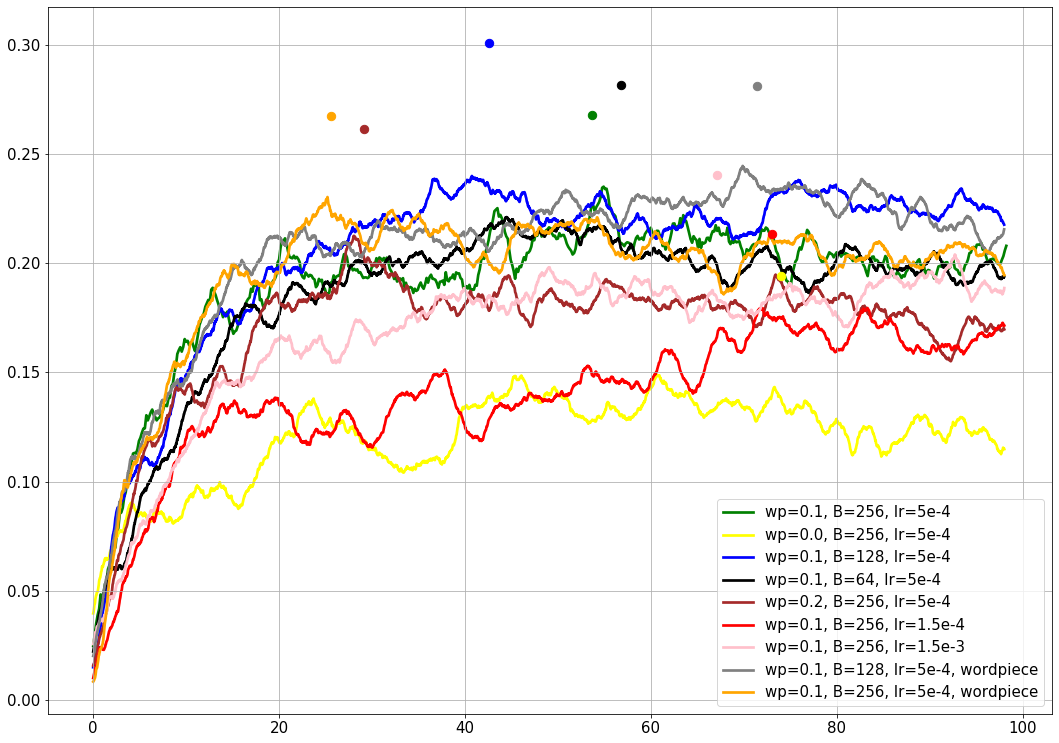

In [84]:
x_max = 100
smooth_factor = 2.0
fig = plt.figure(figsize=(18, 13))
ax = plt.gca()

for i, (label, data) in enumerate(bert_line_data.items()):
    smooth_n = int(len(data)/100*smooth_factor)
    data_smooth = smooth_series(data, N=smooth_n)
    xs = np.linspace(start=0, stop=x_max*(len(data_smooth)/len(data)), num=len(data_smooth))
    ax.plot(xs, data_smooth, label=label, lw=2.7, c=cls[i], zorder=1)
    max_idx = np.argmax(data.values)
    ax.scatter(x_max*max_idx/len(data), data[max_idx], marker="o", c=cls[i], s=70, zorder=2)

for label, e, data in bert_in_progress:
    smooth_n = int(len(data)/e*smooth_factor)
    data_smooth = smooth_series(data, N=smooth_n)
    xs = np.linspace(start=0, stop=e, num=len(data_smooth))
    ax.plot(xs, data_smooth, label=label, lw=1, linestyle="--", marker='.')

ax.legend()
ax.grid()
plt.show()

**Conclusions**
- Adam with $\eta=5\times10^{-4}$ is the best learning algo
- warmup proportion is best at 10 epochs (no warmup or 20 warmup epochs are worse)
- optimal batch size is 128 (both 64 and 256 are slightly worse)

## How the gradients exploded in the biggest BERT student
On CoLA, W=4, D=3. Epochs: 7.26.

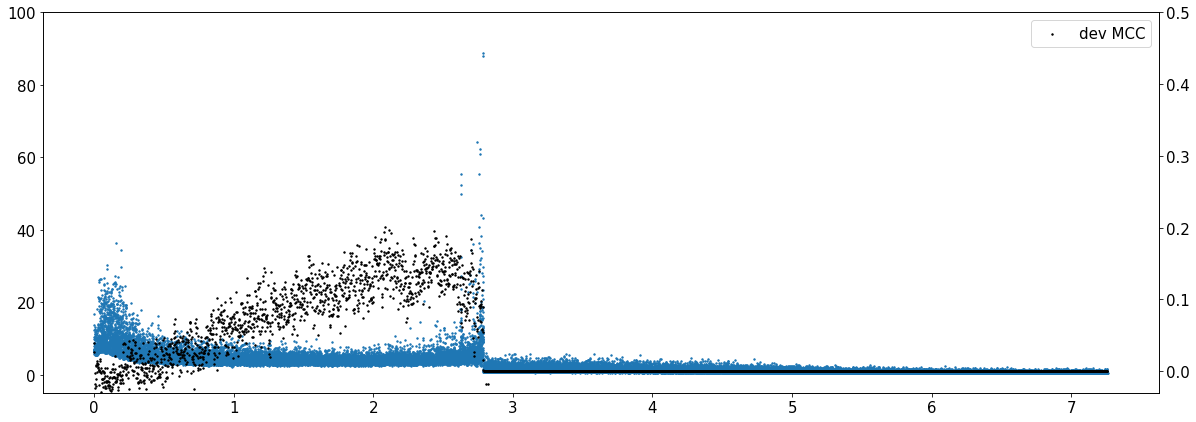

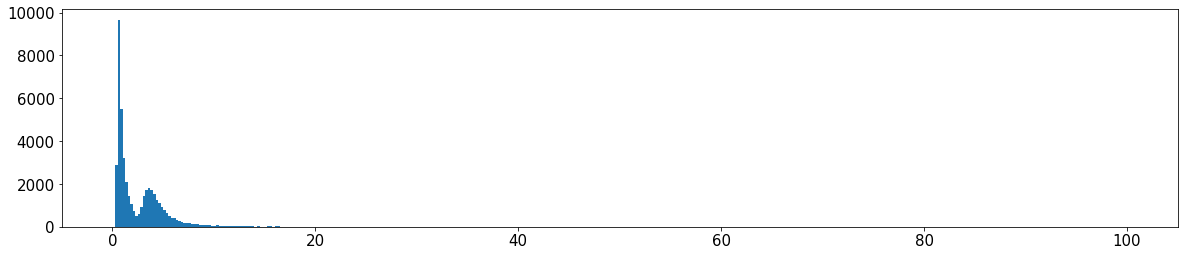

In [18]:
grads = pd.read_csv("logs/grads.txt", names=["grad"])
mccs = pd.read_csv("logs/mccs.txt", names=["mcc"])
fig = plt.figure(figsize=(20, 7))
ax = plt.gca()
E = 7.26
xs = np.arange(len(grads))*E/len(grads)
ax.scatter(xs, grads["grad"], s=2, label="gradient norm")
ax2 = ax.twinx()
xs = np.arange(len(mccs))*E/len(mccs)
ax2.scatter(xs, mccs["mcc"], s=2, c="black", label="dev MCC")
ax.set_ylim(bottom=-5, top=100)
ax2.set_ylim(bottom=-0.03, top=0.5)
plt.legend()
plt.show()

fig = plt.figure(figsize=(20, 4))
plt.hist(grads["grad"], bins=400, range=(0, 100))
plt.show()

### Gradient diagnostics from MCC
`mccs1.txt`: W=2, D=1 (L=5 H=408 A=6 I=1500), 9.6M,  B=1x128, distil-bert-CoLA-Jan28-09:23:07

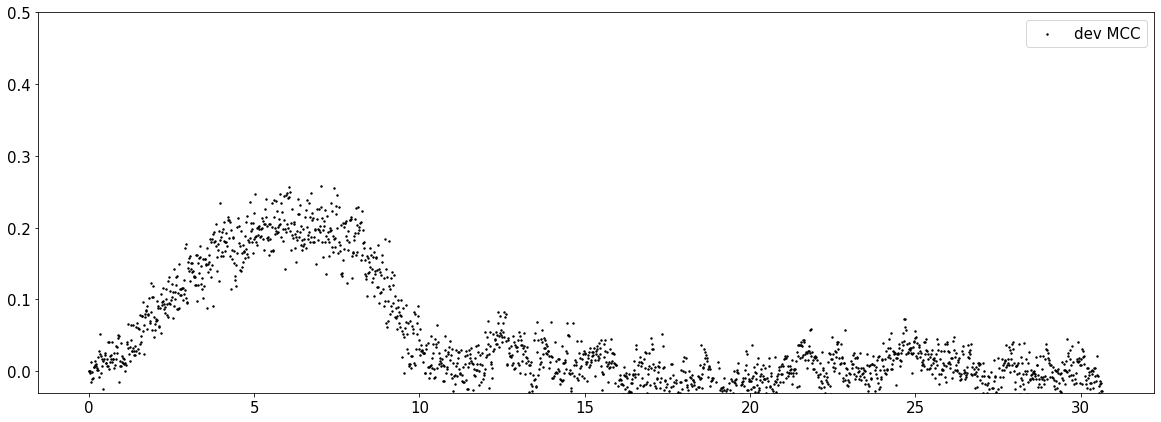

In [4]:
mccs = pd.read_csv("logs/mccs1.txt", names=["mcc"])
fig = plt.figure(figsize=(20, 7))
ax = plt.gca()
E = 30.7
xs = np.arange(len(mccs))*E/len(mccs)
ax.scatter(xs, mccs["mcc"], s=2, c="black", label="dev MCC")
ax.set_ylim(bottom=-0.03, top=0.5)
plt.legend()
plt.show()